# Points to note:

1. We use some files from the repository: model_library

2. Passing storage_path while creating instance of PathHandling

3. Adding folder with pretrained model and train, test files

4. path_results folder for storing the generated plots

In [9]:
# Imports
import os
import shutil
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import re
from model.multi_output_classifier import Classifier
from path_handling import PathHandling
import math
from lime import lime_tabular
from matplotlib.ticker import FuncFormatter
import copy
from scipy.stats import norm

from sklearn.metrics import pairwise_distances
from functools import partial
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from matplotlib.gridspec import GridSpec

In [10]:
# Providing storage path for model_library
path = PathHandling(storage_path=f'{os.getcwd()}/storage')
experiment_name_split = "Subsample for bins - 300000, frac 0.9, freq 2"
experiment_name_gain = "Subsample for bins - 300000, frac 0.9, freq 2, feature_importance gain"
experiment_dir_split = PathHandling.get_experiment_path(experiment_name_split)
experiment_dir_gain = PathHandling.get_experiment_path(experiment_name_gain)
model_path_split = os.path.join(experiment_dir_split, f"model.mod")
model_path = os.path.join(experiment_dir_gain, f"model.mod")
path_results = os.path.join(path.storage_path,"results")

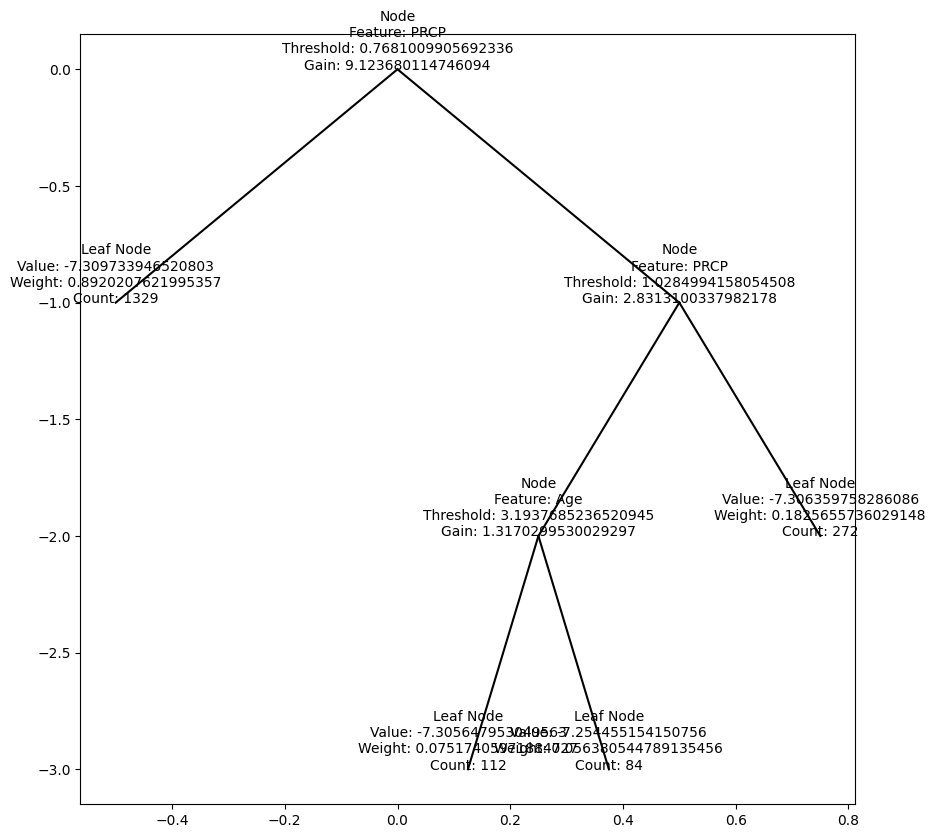

In [11]:
import lightgbm as lgb
pd.set_option('display.max_columns', None)
# Loading model from model path
classifier_split = Classifier.load_model(model_path_split)
classifier = Classifier.load_model(model_path)
# Assuming your model is named `classifier`
booster = classifier.estimators_[0].booster_

# Create a pandas DataFrame from all trees
df = booster.trees_to_dataframe()

# Display the DataFrame
df

def plot_node(node, depth=0, position=0, offset=1.0):
    if pd.isna(node['split_feature']):
        plt.text(position, -depth, f'Leaf Node\nValue: {node["value"]}\nWeight: {node["weight"]}\nCount: {node["count"]}',
                 horizontalalignment='center')
    else:
        plt.text(position, -depth, f'Node\nFeature: {node["split_feature"]}\nThreshold: {node["threshold"]}\nGain: {node["split_gain"]}',
                 horizontalalignment='center')

        left_child = df_tree.loc[df_tree['node_index'] == node['left_child']].iloc[0]
        right_child = df_tree.loc[df_tree['node_index'] == node['right_child']].iloc[0]

        plt.plot([position, position-offset/2], [-depth, -depth-1], color='k')
        plt.plot([position, position+offset/2], [-depth, -depth-1], color='k')

        plot_node(left_child, depth+1, position-offset/2, offset/2)
        plot_node(right_child, depth+1, position+offset/2, offset/2)

df_tree = df[df['tree_index'] == 0]

plt.figure(figsize=(10, 10))
plot_node(df_tree.iloc[1])
plt.show()


In [571]:
def filter_infrequent_features(feature_counts, frequency_threshold):
    # Calculate the total number of trees
    total_trees = len(dumped['tree_info'])
    threshold = frequency_threshold * total_trees
    return {feature: count for feature, count in feature_counts.items() if count >= threshold}

def filter_self_interactions(interactions):
    return {(f1, f2): strength for (f1, f2), strength in interactions.items() if f1 != f2}

def filter_weak_interactions(interactions, strength_threshold):
    return {(f1, f2): strength for (f1, f2), strength in interactions.items() if strength >= strength_threshold}

def get_filtered_interactions(interaction_strength, feature_counts, frequency_threshold, strength_threshold):
    # Filter infrequent features
    significant_features = filter_infrequent_features(feature_counts, frequency_threshold)
    
    # Filter self interactions and interactions with insignificant features
    filtered_interactions = {(f1, f2): strength for (f1, f2), strength in interaction_strength.items() if f1 in significant_features and f2 in significant_features and f1 != f2}
    
    # Filter weak interactions
    strong_interactions = filter_weak_interactions(filtered_interactions, strength_threshold)
    
    # Sort interactions by strength
    sorted_interactions = {k: v for k, v in sorted(strong_interactions.items(), key=lambda item: item[1], reverse=True)}
    
    return sorted_interactions

def compute_interactions_for_estimator(estimator):
    dumped = estimator.booster_.dump_model()
    interactions = {}
    feature_counts = {}

    # For each tree in the LGBM model...
    for tree in dumped['tree_info']:
        tree_structure = tree['tree_structure']
        
        # This set keeps track of unique features we've encountered in the current tree.
        seen_features = set()
        
        # The stack keeps track of nodes we still need to process. 
        stack = [(tree_structure, None)]  # We start with the root node, which has no parent feature.

        # While there are still nodes to process...
        while stack:
            node, parent_feature = stack.pop()

            # If the current node is a split node...
            if 'split_feature' in node:
                current_feature = node['split_feature']
                seen_features.add(current_feature)
                
                if parent_feature is not None:
                    interaction_pair = tuple(sorted([parent_feature, current_feature]))
                    interactions[interaction_pair] = interactions.get(interaction_pair, 0) + 1
                
                stack.extend([(child, current_feature) for child in [node['left_child'], node['right_child']]])
        
        # Add counts for individual features
        for feature in seen_features:
            feature_counts[feature] = feature_counts.get(feature, 0) + 1

    # Calculate interaction strength based on joint occurrence and individual occurrence
    interaction_strength = {}
    for (feature1, feature2), joint_count in interactions.items():
        if feature1 == feature2:
            individual_count = feature_counts[feature1]
        else:
            individual_count = feature_counts[feature1] + feature_counts[feature2] - joint_count * 2
            
        total_count = individual_count + joint_count
        
        interaction_strength[(feature1, feature2)] = round(joint_count / total_count, 2)
        
    frequency_threshold = 0.05 # threshold how often a feature has to be present in the total tree
    strength_threshold = 0.1 # threshold how often this interaction has to occur 
    
    # Filter interactions 
    sorted_filtered_interactions = get_filtered_interactions(interaction_strength, feature_counts, frequency_threshold, strength_threshold)
    return sorted_filtered_interactions


# Iterate over each estimator and compute interactions
classifier_interactions = {}
for i, estimator in enumerate(classifier.estimators_):
    classifier_interactions[i] = compute_interactions_for_estimator(estimator)

{(52, 54): 0.52, (54, 180): 0.33, (24, 62): 0.29, (50, 180): 0.28, (10, 39): 0.25, (52, 62): 0.23, (29, 33): 0.22, (29, 60): 0.21, (33, 60): 0.2, (39, 180): 0.19, (56, 180): 0.19, (52, 180): 0.17, (39, 60): 0.16, (33, 50): 0.13, (24, 29): 0.12, (39, 50): 0.1}


In [12]:
# Loading features and labels for training and test
x_train = pd.read_csv(os.path.join(experiment_dir_split, "training_features.csv"))
y_train = pd.read_csv(os.path.join(experiment_dir_split, "training_labels.csv"))
x_test = pd.read_csv(os.path.join(experiment_dir_split, "test_features.csv"))
y_test = pd.read_csv(os.path.join(experiment_dir_split, "test_labels.csv"))

In [13]:
# There is a column named "Energy" that has no values, LIME throws an error in this case
print(x_train.columns[x_train.isna().any()].tolist())
x_test.fillna(0, inplace=True)
x_train.fillna(0, inplace=True)
print(x_train.columns[x_train.isna().any()].tolist())

['Exercise']
[]


In [101]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
def highlight_nonzero(val):
    color = 'yellow' if val >= 0.7 or val <= -0.7 else ''
    return f'background-color: {color}'
# Rename the columns of y_train
y_train_output = y_train.copy()
y_train_output.columns = [f"{col}_output" for col in y_train.columns]

# Concatenate x_train and y_train
df = pd.concat([x_train.iloc[:,2:], y_train_output.iloc[:,2:]], axis=1)

# Compute the correlation matrix
corr_matrix = df.corr()

# Get correlation pairs with absolute value above threshold
pairs_to_check = []
for i in range(50):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 0.1:
            pairs_to_check.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Print pairs that meet the condition
for pair in pairs_to_check:
    print(f"Correlation between {pair[0]} and {pair[1]}: {pair[2]}")


Correlation between Adrenalinsufficiency and Gastrointestinalnervoussystemdisorders: 0.17489159960307413
Correlation between Adrenalinsufficiency and Heartdisorders: 0.13096053716515774
Correlation between Adrenalinsufficiency and Lethargy: 0.22277544847198427
Correlation between Adrenalinsufficiency and Skindisorders: 0.11204444000968107
Correlation between Adrenalinsufficiency and Softtissueinjuries: 0.10925681563470474
Correlation between Adrenalinsufficiency and Thyroiddisorders: 0.19998617814716327
Correlation between Adrenalinsufficiency and Adrenal insufficiency_output: 0.39172140961290103
Correlation between Adrenalinsufficiency and Heart disorders_output: 0.20150168558036224
Correlation between Adrenalinsufficiency and Thyroid disorders_output: 0.18880444292177403
Correlation between Analglanddisorders and Cushingsyndrome: 0.10612480514912448
Correlation between Analglanddisorders and Eardisorders: 0.13582642915148005
Correlation between Analglanddisorders and Lethargy: 0.1141

In [160]:
from sklearn.inspection import permutation_importance
def get_permutation_importance(model, df_features, df_targets):
    for disease, disease_model in zip(model.output_names, model.estimators_):
            random_fixed_seed=10
            pfi_result = permutation_importance(disease_model, df_features, df_targets[disease], n_jobs=-1,
                                                n_repeats=5, max_samples=min(len(df_features), 5000),
                                                scoring="roc_auc", random_state=random_fixed_seed)
            
    return pfi_result

permuation_importance=get_permutation_importance(classifier, x_train.iloc[:, 2:], y_train )


3

Mean Reduction: 89.72527472527473


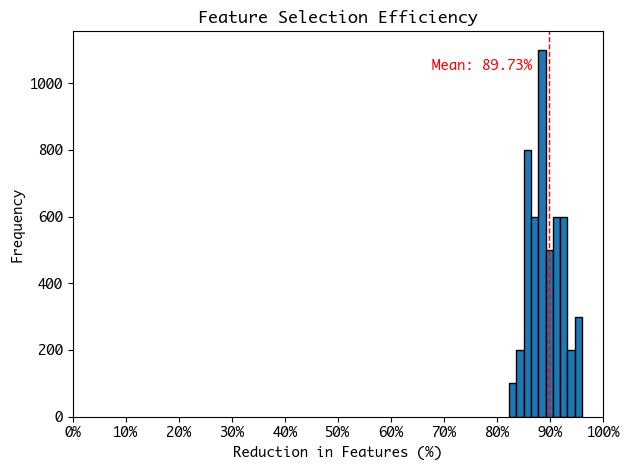

In [283]:
def select_features(classifier, threshold, disease_index, data=None, median=False, add_disease=False, remove_breed=False, add_non_zero= False):
    feature_importance_indices = get_minmax_feature_importance_indices(classifier, threshold, disease_index)
    if median:
        #get above median feature importances
        feature_importance_indices = get_median_feature_importance_indices(classifier, disease_index)

    if add_disease:
        # add disease indices that are non zero to features
        feature_importance_indices = np.union1d(feature_importance_indices, get_diseases_indices_non_zero(data))

    if remove_breed:
        # Remove matching indices in breed_zero_indices from feature_importance_indices
        feature_importance_indices = exclude_zero_breed_features(data, feature_importance_indices)
        
    if add_non_zero:
        # add non zero indices to features
        feature_importance_indices = np.union1d(feature_importance_indices, get_non_zero_indices(data))
    
    
    return feature_importance_indices

def get_minmax_feature_importance_indices(classifier, threshold, disease_index):
    # Get feature importance values from the classifier
    feature_importance = np.array(classifier.get_feature_importance())
    # Apply MinMaxScaler to each row
    scaler = MinMaxScaler()
    # normalze features inside of the classifier
    normalized_features = np.apply_along_axis(
        lambda row: scaler.fit_transform(row.reshape(-1, 1)).flatten(), 1, feature_importance)
#     normalize features with themselves
#     normalized_features = np.apply_along_axis(
#         lambda column: scaler.fit_transform(column.reshape(-1, 1)).flatten(), 0, feature_importance)
    # Create an empty list to store the indices
    indices_above_threshold = []

    # Check if values in the row are above the threshold
    for i in range(len(normalized_features)):
        row_indices = np.where(normalized_features[i] > threshold)[0]
        indices_above_threshold.append(row_indices)

    return np.array(indices_above_threshold[disease_index])

def get_median_feature_importance_indices(classifier, disease_index):
    # Get feature importance values from the classifier
    feature_importance = np.array(classifier.get_feature_importance())
    
    # Create an empty list to store the indices
    indices_above_median = []

    # Calculate the median for each row excluding zeros and get indices of values above the median
    for i in range(len(feature_importance)):
        non_zero_importances = feature_importance[i][np.nonzero(feature_importance[i])]
        if non_zero_importances.size > 0:  # To avoid attempting to calculate the median of an empty array
            row_median = np.median(non_zero_importances)
            row_indices = np.where(feature_importance[i] > row_median)[0]
            indices_above_median.append(row_indices)
        else:
            indices_above_median.append(np.array([]))

    return np.array(indices_above_median[disease_index])

def get_diseases_indices_non_zero(data, start_index=0, end_index=50):
    diseases_indices_non_zero = np.array(np.where(data[start_index:end_index].values != 0))[0] + start_index
    return diseases_indices_non_zero

def get_non_zero_indices(data):
    non_zero_indices = np.array(np.where(data.values != 0))[0]
    return non_zero_indices

def exclude_zero_breed_features(data, feature_importance_indices):
    breed_info = {
        "breed_type": list(range(64, 73)),
        "sub_breed": list(range(78, 99)),
        "super_breed": list(range(110, 128)),
        "breed_name": list(range(128, 178))
    }
    breed_zero_indices = []
    for breed_key, breed_indices in breed_info.items():
        for index in breed_indices:
            if data[index] == 0:
                breed_zero_indices.append(index)
    breed_zero_indices = np.array(breed_zero_indices)
    filtered_breed_indices = np.setdiff1d(feature_importance_indices, breed_zero_indices)
    return filtered_breed_indices

# # Maximum number of features
# MAX_FEATURES = 182

# # List to store percentage reductions
# reductions = []

# for j in range(100):
#     pet_rows = x_test.iloc[j]
    
#     for i in range(0,50):
#         indices_gain = select_features(classifier, threshold=0.05, disease_index=i,
#                                        data=pet_rows[2:], 
#                                        median=False,
#                                        add_disease=False, 
#                                        remove_breed=False, 
#                                        add_non_zero=False)
#         reduction_percentage = (1 - len(indices_gain) / MAX_FEATURES) * 100
#         reductions.append(reduction_percentage)

# Create histogram with specific bins to capture the range between 30% to 90%
bins = np.linspace(80, 90, 10)

# Calculate the mean
mean_reduction = np.mean(reductions)
print("Mean Reduction:", mean_reduction)

# Plot histogram
plt.hist(reductions, bins=10, edgecolor='black', align='left')
plt.xlabel('Reduction in Features (%)')
plt.ylabel('Frequency')
plt.title('Feature Selection Efficiency')

# Add vertical line for mean
plt.axvline(mean_reduction, color='r', linestyle='dashed', linewidth=1)

# Add text annotation for mean
plt.text(mean_reduction -22, plt.ylim()[1] * 0.9, f'Mean: {mean_reduction:.2f}%', color='r')

# Adjust x-axis limits and y-axis labels
plt.xlim([0, 100])
plt.xticks(np.arange(0, 101, 10))
plt.gca().xaxis.set_major_formatter(lambda x, _: f'{int(x)}%')

plt.tight_layout()  # Adjust layout so everything fits
plt.show()

In [18]:
feature_names = np.array(classifier.estimators_[0].feature_name_)

# Set this to True to print feature names, and False to print indices
use_feature_names = False
for i in range(0, 50):
    indices_gain = select_features(classifier, threshold=0.0, disease_index=i,
                              data=pet_rows[2:], 
                              median=False,
                              add_disease=False, 
                              remove_breed=False, 
                              add_non_zero=False)
                              
    indices_split = select_features(classifier_split, threshold=0.0, disease_index=i,
                          data=pet_rows[2:], 
                          median=False,
                          add_disease=False, 
                          remove_breed=False, 
                          add_non_zero=False)
                          
    # Find the common and unique indices
    common = list(set(indices_gain) & set(indices_split))
    unique_gain = list(set(indices_gain) - set(indices_split))
    unique_split = list(set(indices_split) - set(indices_gain))

    # Replace indices with feature names for readability, if use_feature_names is True
    indices_gain_disp = [feature_names[idx] for idx in indices_gain] if use_feature_names else indices_gain
    indices_split_disp = [feature_names[idx] for idx in indices_split] if use_feature_names else indices_split
    common_disp = [feature_names[idx] for idx in common] if use_feature_names else common
    unique_gain_disp = [feature_names[idx] for idx in unique_gain] if use_feature_names else unique_gain
    unique_split_disp = [feature_names[idx] for idx in unique_split] if use_feature_names else unique_split

    # Print the results in a readable format
    print(f"Disease Index: {i}")
    print(f"Indices_Gain: {', '.join(map(str, indices_gain_disp))}")
    print(f"Indices_Split: {', '.join(map(str, indices_split_disp))}")
    print(f"Common: {', '.join(map(str, common_disp))}")
    print(f"Unique_Gain: {', '.join(map(str, unique_gain_disp))}")
    print(f"Unique_Split: {', '.join(map(str, unique_split_disp))}")
    print("\n")

Disease Index: 0
Indices_Gain: 10, 23, 24, 29, 31, 33, 34, 35, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 174, 176, 180
Indices_Split: 10, 23, 24, 29, 31, 33, 34, 35, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 100, 102, 180
Common: 10, 23, 24, 29, 31, 33, 34, 35, 39, 48, 50, 51, 52, 53, 54, 55, 56, 180, 57, 59, 60, 61, 62
Unique_Gain: 176, 174
Unique_Split: 100, 102


Disease Index: 1
Indices_Gain: 1, 3, 12, 15, 16, 17, 18, 21, 24, 25, 26, 27, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 86, 87, 89, 90, 103, 106, 107, 112, 115, 116, 132, 135, 140, 147, 148, 150, 154, 156, 158, 161, 162, 163, 164, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180
Indices_Split: 1, 3, 12, 15, 16, 17, 18, 21, 24, 25, 26, 27, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59

Disease Index: 28
Indices_Gain: 3, 10, 12, 15, 16, 17, 19, 21, 22, 24, 25, 26, 29, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 67, 69, 72, 74, 75, 77, 78, 79, 80, 84, 87, 90, 91, 101, 102, 116, 117, 118, 120, 140, 143, 146, 147, 155, 156, 158, 161, 162, 163, 164, 167, 168, 171, 172, 173, 174, 175, 176, 178, 179, 180
Indices_Split: 3, 10, 12, 15, 16, 17, 19, 21, 22, 24, 25, 26, 29, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 81, 83, 84, 86, 87, 88, 89, 93, 96, 99, 100, 101, 102, 103, 104, 105, 106, 108, 111, 114, 115, 123, 126, 137, 138, 152, 153, 154, 156, 176, 180
Common: 3, 10, 180, 12, 15, 16, 17, 19, 21, 22, 24, 25, 26, 156, 29, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 67, 69, 72, 74, 77, 84, 87, 101, 102, 176
Unique_Gain: 

In [10]:
# Functions for extracting Pet Data from Files to create synthetic Pet Data
def get_pet_column_names(df, *column_ranges):
    return [df.columns[i] if isinstance(i, int) else df.columns[i[0]:i[1]].tolist() for i in column_ranges]

def create_synthetic_instances(original_df, synthetic_df, columns, num_synthetic_instances, country_determination=False):
    random_indices = np.random.choice(original_df.index, size=num_synthetic_instances)
    current_row_index = 0
    for index in random_indices:
        row = original_df.loc[index]
        if not row.empty:
            for column in columns:
                synthetic_df.loc[current_row_index, column] = row[column]
            
            if country_determination:
                if row['postal_fsa'].isnumeric():
                    synthetic_df.loc[current_row_index, 'Country_US'] = 1
                    synthetic_df.loc[current_row_index, 'Country_CAN'] = 0
                else:
                    synthetic_df.loc[current_row_index, 'Country_US'] = 0
                    synthetic_df.loc[current_row_index, 'Country_CAN'] = 1
                
            current_row_index += 1

    return synthetic_df

def normalize_string(s):
    rename_dict = {
        'total_population': 'TotalPopulation',
        'med_hh_income': 'MedHHIncome',
        'population_density': 'PopulationDensity',
        'area_type': 'AreaType',
    }
    
    s = s.translate(str.maketrans('', '', ' /-()+,'))
    return rename_dict.get(s, s)

def fill_na_with_median(df, column):
    median = df[column].median()
    df[column].fillna(median, inplace=True)
    return df

def load_and_prepare_data(file_path, one_hot_columns, string_normalization=False):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file type. Only .csv and .xlsx files are supported.")
    
    if string_normalization:
        df = df.applymap(normalize_string)
    else:
        df.columns = [normalize_string(col) for col in df.columns]
        
    df = pd.get_dummies(df, columns=one_hot_columns)
    df.columns = [normalize_string(col) for col in df.columns]

    # Check if these columns exist in DataFrame and if so, fill NAs with column median
    for col in ['TotalPopulation', 'MedHHIncome', 'PopulationDensity','TAVG', 'PRCP',
       'DT32', 'DP01', 'DP10', 'DX70', 'DX90']:
        if col in df.columns:
            # Standardize the column
            standard_scaler = StandardScaler()
            df[col] = standard_scaler.fit_transform(df[col].values.reshape(-1, 1)).flatten()
            df = fill_na_with_median(df, col)
      
    return df

def create_synthetic_data(columns, file_Residential_Features_df, file_Breed_Info_df, file_Breed_Groups_df, residential_columns_df, breed_info_columns_df, breed_columns_df, num_synthetic_instances):
    # Create an empty dataframe with the specified size
    Synthetic_X = pd.DataFrame(index=range(num_synthetic_instances), columns=columns)
    
    # Call the create_synthetic_instances function for different data frames
    Synthetic_X = create_synthetic_instances(file_Residential_Features_df, Synthetic_X, residential_columns_df, num_synthetic_instances, country_determination=True)
    Synthetic_X = create_synthetic_instances(file_Breed_Info_df, Synthetic_X, breed_info_columns_df, num_synthetic_instances)
    Synthetic_X = create_synthetic_instances(file_Breed_Groups_df, Synthetic_X, breed_columns_df, num_synthetic_instances)
    
    # Create random genders
    random_gender = np.random.randint(2, size=num_synthetic_instances)
    
    # Assign 'Gender_feminine' to True and 'Gender_masculine' to False in Synthetic_X
    Synthetic_X[['Gender_feminine', 'Gender_masculine']] = pd.DataFrame(np.random.randint(2, size=(num_synthetic_instances, 2)), columns=['Gender_feminine', 'Gender_masculine'])

    # Assign unique PetId
    Synthetic_X['PetId'] = range(1, len(Synthetic_X) + 1)

    # Fill diseases with 0 (assuming dogs are all zero years old)
    Synthetic_X.fillna(0, inplace=True)

    return Synthetic_X

def simulate_diseases(Synthetic_X, classifier, num_years):
    # Get the column names of the disease features
    disease_features = Synthetic_X.columns[2:52]

    for year in range(num_years):
        # Take only the latest year instances for prediction
        last_year_instances = Synthetic_X[Synthetic_X['Age'] == year].copy()
        # Increment the 'Age' column for the new instances
        new_instances = last_year_instances.copy()
        new_instances['Age'] += 1
        # Get a fresh prediction for each year
        output = classifier.run(last_year_instances.iloc[:, 2:].values)
        # Get a mask of instances where disease value is 0
        mask = (last_year_instances[disease_features] == 0)

        # Define a vectorized version of np.random.choice
        rand_choice_vec = np.vectorize(lambda o: np.random.choice([0, 1], p=[1-o, o]))

        # Simulate the occurrence of diseases for each new instance
        new_values = rand_choice_vec(output)
        new_instances[disease_features] = new_instances[disease_features].where(~mask, new_values)
        # Append the new instances to Synthetic_X and reset the index
        Synthetic_X = pd.concat([Synthetic_X, new_instances]).reset_index(drop=True)

    return Synthetic_X

def calculate_kernel_widths(indices_dict):
    kernel_widths = {}
    for category, indices in indices_dict.items():
        if category in ['age']:
            # Compute standard deviation for these categories
#             kernel_widths[category] = np.std(x_train.iloc[:, indices].values)
            kernel_widths[category]=2.36 # equivalent to to np.std(x_train.iloc[:, indices].values)
        elif category in ['TotalPopulation', 'MedHHIncome', 'PopulationDensity', 'TAVG', 'PRCP', 'DT32', 'DP01', 'DP10', 'DX70', 'DX90']:
            # Set kernel width to 1 for these categories
            kernel_widths[category] = 1
    return kernel_widths

def median_and_kernel(d, kernel_widths):
    """Kernel function for calculating weights."""
    kernel_width = float(kernel_widths * .75)
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

def reversed_distance_weights(d):
    """Weight function for reversing distance."""
    return 1 - d

def one_hot_distance(a, b):
    """Compute distance for one-hot encoded data: 0 if identical, 1 if different"""
    return 0 if np.array_equal(a, b) else 1

def disease_distance(a, b):
    """Compute custom distance for disease data."""
    a, b = np.array(a, dtype=bool), np.array(b, dtype=bool)  # Ensure boolean type
    intersection = np.sum(a & b)  # Count shared diseases
    union = np.sum(a | b)  # Count all diseases

    # Compute Jaccard similarity
    jaccard_similarity = intersection / union if union != 0 else 0
    # Compute the complement
    not_a, not_b = ~a, ~b
    intersection_complement = np.sum(not_a & not_b)  # Count shared non-diseases
    union_complement = np.sum(not_a | not_b)  # Count all non-diseases
    # Compute Jaccard similarity for the complement and scale
    jaccard_similarity_complement = intersection_complement / union_complement if union_complement != 0 else 0
    jaccard_similarity_complement = max(0, (jaccard_similarity_complement - 0.85) / 0.15)

    # Return the average of the two measures of distance
    return (1 - jaccard_similarity + 1 - jaccard_similarity_complement) / 2


def process_continuous_data(category, synthetic_data, real_data, kernel_widths, distances_df, weights_df):
#     print(f"\nCalculated Distance for: {category}")
#     print("Using euclidean distance metric")
#     print(f"\nDistance calculated to: {real_data}")
    distances = pairwise_distances(synthetic_data, real_data.reshape(1, -1), metric='euclidean').ravel()
    distances_df[category] = distances
    kernel_fn = partial(median_and_kernel, kernel_widths=kernel_widths[category])
    kernel_weights = kernel_fn(distances)
    weights_df[category] = kernel_weights
#     for i, (dist, weight, instance_value) in enumerate(zip(distances, kernel_weights, synthetic_data)):
#         print(f"Instance {i+1} - Value: {np.round(instance_value, 2)}, Distance to Real Instance: {np.round(dist, 2)}, Weight: {np.round(weight, 2)}")
    return weights_df, distances_df

def process_categorical_data(category, synthetic_data, real_data, distance_fn, distances_df, weights_df):
#     print(f"\nCalculating distances for: {category}")
#     print(f"\nDistance calculated to: {real_data}")
    distances = np.array([distance_fn(x, real_data) for x in synthetic_data])
    distances_df[category] = distances
    weights = reversed_distance_weights(distances)
    weights_df[category] = weights
#     for i, (dist, weight, instance_value) in enumerate(zip(distances, weights, synthetic_data)):
#         print(f"Instance {i+1} - Value: {np.round(instance_value, 2)}, Distance to Real Instance: {np.round(dist, 2)}, Weight: {np.round(weight, 2)}")
    return weights_df, distances_df

def get_distance_and_weight(Synthetic_X, instance_x):
    indices_dict = {
        #categorical data one-hot encoded
        "breed_type": list(range(66, 75)),
        "sub_breed": list(range(80, 101)),
        "super_breed": list(range(112, 130)),
        "breed_name": list(range(130, 180)),
        "demeanor": list(range(101, 105)),
        "trainability": list(range(107, 112)),
        "sheds": list(range(105, 107)),
        "gender": list(range(75, 77)),
        "country": list(range(180, 182)),
        "area_type": list(range(77, 80)),
        #categorical data
        "diseases": list(range(2, 52)),
        # continuous data
        'TotalPopulation': [52], #residential_info
        'MedHHIncome': [53], 
        'PopulationDensity': [54],
        'TAVG': [55], #weather_info
        'PRCP': [56], 
        'DT32': [57], 
        'DP01': [58], 
        'DP10': [59], 
        'DX70': [60], 
        'DX90': [61],
        "energy_level": [62],
        "coat_length": [63],
        "size": [64],
        "age": [182]
    }

    # Getting the list of columns from the indices_dict
    columns = list(indices_dict.keys())
    # Initialize distances_df and weights_df with zeros and the right columns
    distances_df = pd.DataFrame(0, index=np.arange(len(Synthetic_X)), columns=columns)
    weights_df = pd.DataFrame(0, index=np.arange(len(Synthetic_X)), columns=columns)
    # Calculate kernel widths
    kernel_widths = calculate_kernel_widths(indices_dict)
    # Distance calculations
    for category, indices in indices_dict.items():
        synthetic_data = Synthetic_X.iloc[:, indices].values
        real_data = instance_x[indices]
        if category in ['age', 'TotalPopulation', 'MedHHIncome', 'PopulationDensity', 'TAVG', 'PRCP', 'DT32', 'DP01', 'DP10', 'DX70', 'DX90']:
            process_continuous_data(category, synthetic_data, real_data, kernel_widths, distances_df, weights_df)
        elif category in ['breed_type', 'sub_breed', 'super_breed', 'breed_name', 'demeanor', 'trainability', 
                          'sheds', 'gender', 'country', 'area_type', 'energy_level', 'coat_length', 'size']:
            distance_fn = one_hot_distance if category in ['breed_type', 'sub_breed', 'super_breed', 'breed_name', 'demeanor', 
                                                           'trainability', 'sheds', 'gender', 'country', 'area_type'] else \
            lambda x, y: pairwise_distances(x.reshape(1, -1), y.reshape(1, -1), metric='euclidean').ravel()[0]
            weights_df, distances_df = process_categorical_data(category, synthetic_data, real_data, distance_fn, distances_df, weights_df)
        else: 
            weights_df, distances_df = process_categorical_data(category, synthetic_data, real_data, disease_distance, distances_df, weights_df)
    return distances_df, weights_df


def compute_final_weights(weights_df):
    combined_weights = {
        "breed": ["breed_type", "sub_breed", "super_breed", "breed_name", "demeanor",
                  "trainability", "sheds", "energy_level", "coat_length", "size"],
        "disease": ["diseases"],
        "residence": ["TotalPopulation", "MedHHIncome", "PopulationDensity", "country", "area_type"],
        "weather": ["TAVG", "PRCP", "DT32", "DP01", "DP10", "DX70", "DX90"],
        "sex": ["gender"],
        "age": ["age"]
    }

    multiplication_factors = {
        "breed": 10,
        "disease": 10,
        "residence": 1,
        "weather": 1,
        "sex": 5,
        "age": 5
    }

    multiplication_factors["sum"] = sum(multiplication_factors.values())

    final_weights_df = pd.DataFrame()
    multiplication_factors_df = pd.DataFrame([multiplication_factors])

    for combined_category, categories in combined_weights.items():
        combined_weight = np.zeros_like(weights_df[categories[0]], dtype=float)
        for category in categories:
            combined_weight += weights_df[category].astype(float)
        combined_weight /= len(categories)
        multiplication_factor = multiplication_factors[combined_category]
        final_weights_df[combined_category] = combined_weight
        multiplication_factors_df[combined_category] = [multiplication_factor]

    final_weights_df["final_weight"] = np.zeros_like(final_weights_df[list(final_weights_df.columns)[0]])

    for combined_category in combined_weights.keys():
        final_weights_df["final_weight"] += final_weights_df[combined_category] * \
                                            multiplication_factors_df[combined_category].values[0]

    return final_weights_df, multiplication_factors_df


def extract_duplicate_indices(weights_batch):
    # Identify the rows that have duplicate 'disease' entries.
    duplicates = weights_batch[weights_batch.duplicated(subset='disease', keep=False)]

    # Identify the rows that are unique in 'disease' entries.
    uniques = weights_batch.drop_duplicates(subset='disease', keep=False)

    # Group the duplicates by the 'disease' column.
    grouped_duplicates = duplicates.groupby('disease')

    disease_indices = {}
    # Loop over each group in the grouped duplicates.
    for disease, group in grouped_duplicates:
        indices = group.index.tolist()
        disease_indices[disease] = indices

    # Loop over each row in the uniques.
    for idx, row in uniques.iterrows():
        disease_indices[row['disease']] = [idx]

    return disease_indices


def filter_data(data, weights, num_years, max_weight):
    """Filters synthetic data based on final weight and duplicate disease indices"""
    threshold = max_weight // 2
    batch_size = len(data) // num_years
    unique_indices_below_threshold = []

    for i in range(batch_size):
        # Extract the current batch data and corresponding weights
        current_batch_index = data[data['PetId'] == i + 1].index
        weights_batch = weights.loc[current_batch_index]

        # Identify indices with weights below threshold
        below_threshold_indices = weights_batch[weights_batch['final_weight'] > threshold].index
        # Identify duplicate diseases in the batch and find the maximum weight for each
        duplicate_indices = extract_duplicate_indices(weights_batch)
        max_weight_indices = {
            disease: weights_batch.loc[indices]['final_weight'].idxmax()
            for disease, indices in duplicate_indices.items()}
        # Find intersection between max_weight_indices and below_threshold_indices
        indices_below_threshold = {
            disease: index
            for disease, index in max_weight_indices.items()
            if index in below_threshold_indices}

        # Save unique indices and their weights
        unique_indices_below_threshold.extend(indices_below_threshold.values())

    return data.loc[unique_indices_below_threshold], weights.loc[unique_indices_below_threshold]


def generate_and_filter_data(min_data_rows,
                             columns,
                             file_Residential_Features_df,
                             file_Breed_Info_df,
                             file_Breed_Groups_df,
                             residential_columns_df,
                             breed_info_columns_df,
                             breed_columns_df,
                             classifier,
                             instance,
                             simulate_num_years=9):
    # Initialize an empty DataFrame to store filtered data
    filtered_data = pd.DataFrame()
    filtered_weights = pd.DataFrame()
    # Start with num_synthetic_instances as half of min_data_rows
    num_synthetic_instances = int(min_data_rows // 1.5)

    # While the number of rows in filtered_data is less than the specified minimum
    while filtered_data.shape[0] < min_data_rows:
        # Create random dogs
        Synthetic_X = create_synthetic_data(columns,
                                            file_Residential_Features_df,
                                            file_Breed_Info_df,
                                            file_Breed_Groups_df,
                                            residential_columns_df,
                                            breed_info_columns_df,
                                            breed_columns_df,
                                            num_synthetic_instances)

        # Simulate diseases for the dogs
        Synthetic_X = simulate_diseases(Synthetic_X, classifier, simulate_num_years)

        # Calculate distance between simulated dogs and instance of interest
        distances_df, weights_df = get_distance_and_weight(Synthetic_X, instance)
        final_weights_df, multiplication_factors_df = compute_final_weights(weights_df)

        # Filter simulated dogs based on distance threshold and get rid of duplicates
        new_filtered_data, new_filtered_weights = filter_data(Synthetic_X,
                                                              final_weights_df,
                                                              num_years=simulate_num_years + 1,
                                                              max_weight=multiplication_factors_df['sum'][0])
        # Append new filtered data to the existing filtered_data DataFrame
        filtered_data = pd.concat([filtered_data, new_filtered_data])
        filtered_weights = pd.concat([filtered_weights, new_filtered_weights])
        # Update num_synthetic_instances to half of the remaining rows needed
        num_synthetic_instances = max(1, int((min_data_rows - filtered_data.shape[0]) // 1.5))
    # If the number of rows exceeded min_data_rows, trim to the specified amount
    if filtered_data.shape[0] > min_data_rows:
        filtered_data = filtered_data.iloc[:min_data_rows]
        filtered_weights = filtered_weights.iloc[:min_data_rows]
    return filtered_data.reset_index(drop='index'), filtered_weights.reset_index(drop='index')

In [8]:
pd.set_option('display.max_columns', None)

base_path = '/Users/marvinseiferling/storage'

column_names =['PetId', 'Date', 'Adrenalinsufficiency', 'Analglanddisorders', 'Anxietyorphobia', 'Arthritis', 'Behavioraldisorders', 'Bloodcancers', 'Canceroustumors', 'Conformationaldisordersrelatedtotheskeleton', 'Cushingsyndrome', 'Diabetes', 'Digestivedisorders', 'Discdiseases', 'Eardisorders', 'Eyeabnormalities', 'Eyelidabnormalities', 'Foreignbodyingestion', 'Gaitabnormalities', 'Gastrointestinaldisorders', 'Gastrointestinalnervoussystemdisorders', 'Heartdisorders', 'Immunedisorders', 'Infectiousdiseases', 'Inflammation', 'Inflammationoftheeyes', 'Injuries', 'Internalparasites', 'Intoxicationorpoisoning', 'Itching', 'Kidneydisorders', 'Kneeinjuries', 'Leginjuries', 'Lethargy', 'Liverdisorders', 'Masslesions', 'Paindisorders', 'Periodontaldiseases', 'Preventive', 'Respiratoryinfections', 'Seizures', 'Skindisorders', 'Skininfections', 'Softtissueinjuries', 'Surgical', 'Thyroiddisorders', 'Toothabnormalities', 'Treatment', 'Unspecifiedallergies', 'Urinaryincontinence', 'Urinarytractinfections', 'Vomitinganddiarrhea', 'TotalPopulation', 'MedHHIncome', 'PopulationDensity', 'TAVG', 'PRCP', 'DT32', 'DP01', 'DP10', 'DX70', 'DX90', 'EnergyLevelValue', 'CoatLengthValue', 'SizeValue', 'Exercise', 'BreedType_AncientandSpitz', 'BreedType_Herdingdogs', 'BreedType_MastiffLike', 'BreedType_Mixed', 'BreedType_Retriever', 'BreedType_Spaniels', 'BreedType_Terriers', 'BreedType_Toydogs', 'BreedType_Workingdogs', 'Gender_feminine', 'Gender_masculine', 'AreaType_rural', 'AreaType_suburban', 'AreaType_urban', 'SubBreed_AncientandSpitz', 'SubBreed_Australian', 'SubBreed_Bulldogs', 'SubBreed_Chihuahua', 'SubBreed_CollieCorgiSheepdog', 'SubBreed_Golden', 'SubBreed_Goldenmix', 'SubBreed_Labmix', 'SubBreed_Labs', 'SubBreed_Large', 'SubBreed_Maltese', 'SubBreed_Medium', 'SubBreed_Nonsport', 'SubBreed_Setter', 'SubBreed_Shepherd', 'SubBreed_ShihTzu', 'SubBreed_Similartoretrievers', 'SubBreed_Small', 'SubBreed_SmallTerriers', 'SubBreed_Sporting', 'SubBreed_ToyOther', 'DemeanorCategory_AlertResponsive', 'DemeanorCategory_Friendly', 'DemeanorCategory_Outgoing', 'DemeanorCategory_ReservedwithStrangers', 'Sheds_No', 'Sheds_Yes', 'TrainabilityCategory_Agreeable', 'TrainabilityCategory_EagertoPlease', 'TrainabilityCategory_EasyTraining', 'TrainabilityCategory_Independent', 'TrainabilityCategory_MaybeStubborn', 'SuperBreed_AncientandSpitz', 'SuperBreed_Australianlike', 'SuperBreed_Chihuahua', 'SuperBreed_Golden', 'SuperBreed_HerdingdogsOther', 'SuperBreed_Labs', 'SuperBreed_MastifflikeGroup1', 'SuperBreed_MastifflikeGroup2', 'SuperBreed_MixedLabandGolden', 'SuperBreed_MixedLarge', 'SuperBreed_MixedMedium', 'SuperBreed_MixedOther', 'SuperBreed_MixedSmall', 'SuperBreed_Shepherd', 'SuperBreed_Spaniels', 'SuperBreed_Terriers', 'SuperBreed_ToyOther', 'SuperBreed_WorkingdogsNonsport', 'BreedName_AmericanStaffordshireTerrierMix', 'BreedName_AustralianCattleDogMix', 'BreedName_AustralianShepherd', 'BreedName_AustralianShepherdminiature', 'BreedName_BorderCollie', 'BreedName_BorderCollieMix', 'BreedName_BostonTerrier', 'BreedName_Boxer', 'BreedName_CavalierKingCharlesSpaniel', 'BreedName_Chihuahua', 'BreedName_ChihuahuaMix', 'BreedName_Cockapoo', 'BreedName_CockerSpaniel', 'BreedName_EnglishBulldog', 'BreedName_FrenchBulldog', 'BreedName_GermanShepherd', 'BreedName_GermanShepherdMix', 'BreedName_GoldenRetriever', 'BreedName_Goldendoodle', 'BreedName_GreatDane', 'BreedName_Havanese', 'BreedName_HavaneseMix', 'BreedName_IrishSetter', 'BreedName_Labradoodle', 'BreedName_LabradorMix', 'BreedName_LabradorRetriever', 'BreedName_LabradorRetrieverBlack', 'BreedName_LabradorRetrieverChocolate', 'BreedName_LabradorRetrieverYellow', 'BreedName_MaltAPoo', 'BreedName_Maltese', 'BreedName_MalteseMix', 'BreedName_MixedBreedLarge71lb', 'BreedName_MixedBreedMedium2370lb', 'BreedName_MixedBreedSmallupto22lb', 'BreedName_PembrokeWelshCorgi', 'BreedName_PitBullMix', 'BreedName_Pomeranian', 'BreedName_PoodleStandard', 'BreedName_PoodleToy', 'BreedName_PoodleMix', 'BreedName_Pug', 'BreedName_ShetlandSheepdog', 'BreedName_ShihTzu', 'BreedName_ShihTzuMix', 'BreedName_SiberianHusky', 'BreedName_TerrierMix', 'BreedName_Vizsla', 'BreedName_YorkshireTerrier', 'BreedName_YorkshireTerrierMix', 'Country_CAN', 'Country_US', 'Age']
column_names_df = pd.DataFrame(columns=column_names)

file_Residential_Features_df = load_and_prepare_data(os.path.join(base_path, '00_Residential_Features.csv'), ['AreaType'])
file_Breed_Info_df = load_and_prepare_data(os.path.join(base_path, '04_Breed_Info_v3.xlsx'), ['DemeanorCategory', 'TrainabilityCategory', 'Sheds'])
file_Breed_Groups_df = load_and_prepare_data(os.path.join(base_path, '01_BreedGroups_V6.xlsx'), ['BreedType', 'SubBreed', 'SuperBreed','BreedName'], string_normalization=True)

# Get the column names of the features
residential_columns_df = get_pet_column_names(column_names_df, (52, 62), (77, 80))
breed_info_columns_df = get_pet_column_names(column_names_df, (101, 105), 62, (107, 112), 63, (105, 107), 64)
breed_columns_df = get_pet_column_names(column_names_df, (66, 75), (80, 101), (112, 130), (130, 180))

filtered_data, weights = generate_and_filter_data(min_data_rows=10, 
                                         columns=column_names, 
                                         file_Residential_Features_df=file_Residential_Features_df, 
                                         file_Breed_Info_df=file_Breed_Info_df, 
                                         file_Breed_Groups_df=file_Breed_Groups_df, 
                                         residential_columns_df=residential_columns_df, 
                                         breed_info_columns_df=breed_info_columns_df, 
                                         breed_columns_df=breed_columns_df, 
                                         classifier=classifier,
                                         instance=x_test.iloc[2].values)
filtered_data

PetId  Date  Adrenalinsufficiency  Analglanddisorders  Anxietyorphobia  \
0      2     0                     0                   0                0   
1      3     0                     0                   0                0   
2      4     0                     0                   0                0   
3      4     0                     0                   0                0   
4      4     0                     0                   0                0   
5      5     0                     0                   0                0   
6      7     0                     0                   0                0   
7     11     0                     0                   0                0   
8     16     0                     0                   0                0   
9     19     0                     0                   0                0   

   Arthritis  Behavioraldisorders  Bloodcancers  Canceroustumors  \
0          0                    0             0                0   
1          0                    0             0                0   
2          0                    0             0                0   
3          0                    0             0                0   
4          0                    0             0                0   
5          0                    0             0                0   
6          0                    0             0                0   
7          0                    0             0                0   
8          0                    0             0                0   
9          0                    0             0                0   

   Conformationaldisordersrelatedtotheskeleton  Cushingsyndrome  Diabetes  \
0                                            0                0         0   
1                                            0                0         0   
2                                            0                0         0   
3                                            0                0         0   
4                                            0                0         0   
5                                            0                0         0   
6                                            0                0         0   
7                                            0                0         0   
8                                            0                0         0   
9                                            0                0         0   

   Digestivedisorders  Discdiseases  Eardisorders  Eyeabnormalities  \
0                   0             0             0                 0   
1                   0             0             0                 0   
2                   0             0             0                 0   
3                   0             0             0                 0   
4                   0             0             0                 0   
5                   0             0             0                 0   
6                   0             0             0                 0   
7                   0             0             0                 0   
8                   0             0             0                 0   
9                   0             0             0                 0   

   Eyelidabnormalities  Foreignbodyingestion  Gaitabnormalities  \
0                    0                     0                  0   
1                    0                     0                  0   
2                    0                     0                  0   
3                    0                     0                  0   
4                    0                     0                  0   
5                    0                     0                  0   
6                    0                     0                  0   
7                    0                     1                  0   
8                    0                     1                  0   
9                    0                     0                  0   

   Gastrointestinaldisorders  Gastroin

In [11]:
def __data_inverse_pets(data_row, num_samples):

    base_path = '/Users/marvinseiferling/storage'

    column_names = ['PetId', 'Date', 'Adrenalinsufficiency', 'Analglanddisorders', 'Anxietyorphobia', 'Arthritis', 'Behavioraldisorders', 'Bloodcancers', 'Canceroustumors', 'Conformationaldisordersrelatedtotheskeleton', 'Cushingsyndrome', 'Diabetes', 'Digestivedisorders', 'Discdiseases', 'Eardisorders', 'Eyeabnormalities', 'Eyelidabnormalities', 'Foreignbodyingestion', 'Gaitabnormalities', 'Gastrointestinaldisorders', 'Gastrointestinalnervoussystemdisorders', 'Heartdisorders', 'Immunedisorders', 'Infectiousdiseases', 'Inflammation', 'Inflammationoftheeyes', 'Injuries', 'Internalparasites', 'Intoxicationorpoisoning', 'Itching', 'Kidneydisorders', 'Kneeinjuries', 'Leginjuries', 'Lethargy', 'Liverdisorders', 'Masslesions', 'Paindisorders', 'Periodontaldiseases', 'Preventive', 'Respiratoryinfections', 'Seizures', 'Skindisorders', 'Skininfections', 'Softtissueinjuries', 'Surgical', 'Thyroiddisorders', 'Toothabnormalities', 'Treatment', 'Unspecifiedallergies', 'Urinaryincontinence', 'Urinarytractinfections', 'Vomitinganddiarrhea', 'TotalPopulation', 'MedHHIncome', 'PopulationDensity', 'TAVG', 'PRCP', 'DT32', 'DP01', 'DP10', 'DX70', 'DX90', 'EnergyLevelValue', 'CoatLengthValue', 'SizeValue', 'Exercise', 'BreedType_AncientandSpitz', 'BreedType_Herdingdogs', 'BreedType_MastiffLike', 'BreedType_Mixed', 'BreedType_Retriever', 'BreedType_Spaniels', 'BreedType_Terriers', 'BreedType_Toydogs', 'BreedType_Workingdogs', 'Gender_feminine', 'Gender_masculine', 'AreaType_rural', 'AreaType_suburban', 'AreaType_urban', 'SubBreed_AncientandSpitz', 'SubBreed_Australian', 'SubBreed_Bulldogs', 'SubBreed_Chihuahua', 'SubBreed_CollieCorgiSheepdog', 'SubBreed_Golden', 'SubBreed_Goldenmix', 'SubBreed_Labmix', 'SubBreed_Labs', 'SubBreed_Large', 'SubBreed_Maltese', 'SubBreed_Medium', 'SubBreed_Nonsport', 'SubBreed_Setter', 'SubBreed_Shepherd', 'SubBreed_ShihTzu', 'SubBreed_Similartoretrievers', 'SubBreed_Small', 'SubBreed_SmallTerriers', 'SubBreed_Sporting', 'SubBreed_ToyOther', 'DemeanorCategory_AlertResponsive', 'DemeanorCategory_Friendly', 'DemeanorCategory_Outgoing', 'DemeanorCategory_ReservedwithStrangers', 'Sheds_No', 'Sheds_Yes', 'TrainabilityCategory_Agreeable', 'TrainabilityCategory_EagertoPlease', 'TrainabilityCategory_EasyTraining', 'TrainabilityCategory_Independent', 'TrainabilityCategory_MaybeStubborn', 'SuperBreed_AncientandSpitz', 'SuperBreed_Australianlike', 'SuperBreed_Chihuahua', 'SuperBreed_Golden', 'SuperBreed_HerdingdogsOther', 'SuperBreed_Labs', 'SuperBreed_MastifflikeGroup1', 'SuperBreed_MastifflikeGroup2', 'SuperBreed_MixedLabandGolden', 'SuperBreed_MixedLarge', 'SuperBreed_MixedMedium', 'SuperBreed_MixedOther', 'SuperBreed_MixedSmall', 'SuperBreed_Shepherd', 'SuperBreed_Spaniels', 'SuperBreed_Terriers', 'SuperBreed_ToyOther', 'SuperBreed_WorkingdogsNonsport', 'BreedName_AmericanStaffordshireTerrierMix', 'BreedName_AustralianCattleDogMix', 'BreedName_AustralianShepherd', 'BreedName_AustralianShepherdminiature', 'BreedName_BorderCollie', 'BreedName_BorderCollieMix', 'BreedName_BostonTerrier', 'BreedName_Boxer', 'BreedName_CavalierKingCharlesSpaniel', 'BreedName_Chihuahua', 'BreedName_ChihuahuaMix', 'BreedName_Cockapoo', 'BreedName_CockerSpaniel', 'BreedName_EnglishBulldog', 'BreedName_FrenchBulldog', 'BreedName_GermanShepherd', 'BreedName_GermanShepherdMix', 'BreedName_GoldenRetriever', 'BreedName_Goldendoodle', 'BreedName_GreatDane', 'BreedName_Havanese', 'BreedName_HavaneseMix', 'BreedName_IrishSetter', 'BreedName_Labradoodle', 'BreedName_LabradorMix', 'BreedName_LabradorRetriever', 'BreedName_LabradorRetrieverBlack', 'BreedName_LabradorRetrieverChocolate', 'BreedName_LabradorRetrieverYellow', 'BreedName_MaltAPoo', 'BreedName_Maltese', 'BreedName_MalteseMix', 'BreedName_MixedBreedLarge71lb', 'BreedName_MixedBreedMedium2370lb', 'BreedName_MixedBreedSmallupto22lb', 'BreedName_PembrokeWelshCorgi', 'BreedName_PitBullMix', 'BreedName_Pomeranian', 'BreedName_PoodleStandard', 'BreedName_PoodleToy', 'BreedName_PoodleMix', 'BreedName_Pug', 'BreedName_ShetlandSheepdog', 'BreedName_ShihTzu', 'BreedName_ShihTzuMix', 'BreedName_SiberianHusky', 'BreedName_TerrierMix', 'BreedName_Vizsla', 'BreedName_YorkshireTerrier', 'BreedName_YorkshireTerrierMix', 'Country_CAN', 'Country_US', 'Age']
    column_names_df = pd.DataFrame(columns=column_names)
    
    file_Residential_Features_df = load_and_prepare_data(os.path.join(base_path, '00_Residential_Features.csv'), ['AreaType'])
    file_Breed_Info_df = load_and_prepare_data(os.path.join(base_path, '04_Breed_Info_v3.xlsx'), ['DemeanorCategory', 'TrainabilityCategory', 'Sheds'])
    file_Breed_Groups_df = load_and_prepare_data(os.path.join(base_path, '01_BreedGroups_V6.xlsx'), ['BreedType', 'SubBreed', 'SuperBreed','BreedName'], string_normalization=True)

    # Get the column names of the features
    residential_columns_df = get_pet_column_names(column_names_df, (52, 62), (77, 80))
    breed_info_columns_df = get_pet_column_names(column_names_df, (101, 105), 62, (107, 112), 63, (105, 107), 64)
    breed_columns_df = get_pet_column_names(column_names_df, (66, 75), (80, 101), (112, 130), (130, 180))


    # get classifier for monte carlo simulation
    experiment_dir = '/Users/marvinseiferling/PycharmProjects/LIME/storage/experiments/Subsample for bins - 300000, frac 0.9, freq 2'
    model_path = os.path.join(experiment_dir, f"model.mod")
    classifier = Classifier.load_model(model_path)

    filtered_data, weights = generate_and_filter_data(min_data_rows=num_samples, 
                                             columns=column_names, 
                                             file_Residential_Features_df=file_Residential_Features_df, 
                                             file_Breed_Info_df=file_Breed_Info_df, 
                                             file_Breed_Groups_df=file_Breed_Groups_df, 
                                             residential_columns_df=residential_columns_df, 
                                             breed_info_columns_df=breed_info_columns_df, 
                                             breed_columns_df=breed_columns_df, 
                                             classifier=classifier,
                                             instance=data_row.values)
    #binary representation of data
    binary_values = np.zeros(filtered_data.shape, dtype=int) 

    for i, row in enumerate(filtered_data.values):
        comparison = row == data_row.values
        binary_values[i] = comparison.astype(int)
        
    filtered_data.iloc[0,:]=data_row
    # first instance is always the data instance itself
    binary_values[0,:]=1
    #set weight to zero because we changed data
    weights.loc[0, 'final_weight'] = 0

    return binary_values[:,2:], filtered_data.iloc[:,2:].values , weights

pet_rows = x_test.iloc[139]
x,y,z=__data_inverse_pets(pet_rows,10)

In [14]:
feature_names = [
'Adrenal Insufficiency',
'Anal Gland Disorder',
'Anxiety Or Phobia',
'Arthritis',
'Behavioral Disorder',
'Blood Cancer',
'Cancerous Tumor',
'Conformational Disorders Related to the Skeleton',
'Cushing Syndrome',
'Diabetes',
'Digestive Disorder',
'Disc Disease',
'Ear Disorder',
'Eye Abnormality',
'Eyelid Abnormality',
'Foreign Body Ingestion',
'Gait Abnormality',
'Gastrointestinal Disorder',
'Gastrointestinal Nervous System Disorder',
'Heart Disorder',
'Immune Disorder',
'Infectious Disease',
'Inflammation',
'Inflammation of the Eye',
'Injury',
'Internal Parasite',
'Intoxication or Poisoning',
'Itching',
'Kidney Disorder',
'Knee Injury',
'Leg Injury',
'Lethargy',
'Liver Disorder',
'Mass Lesion',
'Pain Disorder',
'Periodontal Disease',
'Preventive',
'Respiratory Infection',
'Seizure',
'Skin Disorder',
'Skin Infection',
'Soft Tissue Injury',
'Surgery',
'Thyroid Disorder',
'Tooth Abnormality',
'Treatment',
'Allergy',
'Urinary Incontinence',
'Urinarytract Infection',
'Vomiting and Diarrhea',
'Total Population',
'Median Household Income',
'Population Density',
'Avg Temperature',# -> 'TAVG'
'Precipitation',# -> 'PRCP'
'Days Below Freezing',# -> 'DT32'
'Days with Light Rain',# -> 'DP01'
'Days with Heavy Rain',# -> 'DP10'
'Days Above 70°F',# -> 'DX70'
'Days Above 90°F',# -> 'DX90'
'Energy Level',
'Coat Length',
'Size',
'Exercise',
'Breed Type = Ancient and Spitz',
'Breed Type = Herding dog',
'Breed Type = Mastifflike',
'Breed Type = Mixed',
'Breed Type = Retriever',
'Breed Type = Spaniel',
'Breed Type = Terrier',
'Breed Type = Toy dog',
'Breed Type = Working dog',
'Gender = Female',
'Gender = Male',
'Area = rural',
'Area = suburban',
'Area = urban',
'Sub Breed = Ancient and Spitz',
'Sub Breed = Australian',
'Sub Breed = Bulldog',
'Sub Breed = Chihuahua',
'Sub Breed = Collie Corgi Sheepdog',
'Sub Breed = Golden',
'Sub Breed = Golden mix',
'Sub Breed = Lab mix',
'Sub Breed = Lab',
'Sub Breed = Large',
'Sub Breed = Maltese',
'Sub Breed = Medium',
'Sub Breed = Nonsport',
'Sub Breed = Setter',
'Sub Breed = Shepherd',
'Sub Breed = Shih Tzu',
'Sub Breed = Similar to retriever',
'Sub Breed = Small',
'Sub Breed = Small Terrier',
'Sub Breed = Sporting',
'Sub Breed = Toy Other',
'Demeanor = Alert Responsive',
'Demeanor = Friendly',
'Demeanor = Outgoing',
'Demeanor = Reserved with Strangers',
'Sheds = No',
'Sheds = Yes',
'Trainability Category = Agreeable',
'Trainability Category = Eager to Please',
'Trainability Category = Easy Training',
'Trainability Category = Independent',
'Trainability Category = Maybe Stubborn',
'Super Breed = Ancient and Spitz',
'Super Breed = Australianlike',
'Super Breed = Chihuahua',
'Super Breed = Golden',
'Super Breed = Herding dog Other',
'Super Breed = Lab',
'Super Breed = Mastifflike Group 1',
'Super Breed = Mastifflike Group 2',
'Super Breed = Mixed Lab and Golden',
'Super Breed = Mixed Large',
'Super Breed = Mixed Medium',
'Super Breed = Mixed Other',
'Super Breed = Mixed Small',
'Super Breed = Shepherd',
'Super Breed = Spaniel',
'Super Breed = Terrier',
'Super Breed = Toy Other',
'Super Breed = Working dog Nonsport',
'Breed Name = American Staffordshire Terrier Mix',
'Breed Name = Australian Cattle Dog Mix',
'Breed Name = Australian Shepherd',
'Breed Name = Australian Shepherd miniature',
'Breed Name = Border Collie',
'Breed Name = Border Collie Mix',
'Breed Name = Boston Terrier',
'Breed Name = Boxer',
'Breed Name = Cavalier King Charles Spaniel',
'Breed Name = Chihuahua',
'Breed Name = Chihuahua Mix',
'Breed Name = Cockapoo',
'Breed Name = Cocker Spaniel',
'Breed Name = English Bulldog',
'Breed Name = French Bulldog',
'Breed Name = German Shepherd',
'Breed Name = German Shepherd Mix',
'Breed Name = Golden Retriever',
'Breed Name = Goldendoodle',
'Breed Name = Great Dane',
'Breed Name = Havanese',
'Breed Name = Havanese Mix',
'Breed Name = Irish Setter',
'Breed Name = Labradoodle',
'Breed Name = Labrador Mix',
'Breed Name = Labrador Retriever',
'Breed Name = Labrador Retriever Black',
'Breed Name = Labrador Retriever Chocolate',
'Breed Name = Labrador Retriever Yellow',
'Breed Name = MaltAPoo',
'Breed Name = Maltese',
'Breed Name = Maltese Mix',
'Breed Name = Mixed Breed Large 71lb',
'Breed Name = Mixed Breed Medium 23-70lb',
'Breed Name = Mixed Breed Small up to 22lb',
'Breed Name = Pembroke Welsh Corgi',
'Breed Name = Pitbull Mix',
'Breed Name = Pomeranian',
'Breed Name = Poodle Standard',
'Breed Name = Poodle Toy',
'Breed Name = Poodle Mix',
'Breed Name = Pug',
'Breed Name = Shetland Sheepdog',
'Breed Name = Shih Tzu',
'Breed Name = Shih Tzu Mix',
'Breed Name = Siberian Husky',
'Breed Name = Terrier Mix',
'Breed Name = Vizsla',
'Breed Name = Yorkshire Terrier',
'Breed Name = Yorkshire Terrier Mix',
'Country = Canada',
'Country = USA',
'Age']

disease_feature_names = [
'Adrenal Insufficiency',
'Anal Gland Disorder',
'Anxiety Or Phobia',
'Arthritis',
'Behavioral Disorder',
'Blood Cancer',
'Cancerous Tumor',
'Conformational Disorders Related to the Skeleton',
'Cushing Syndrome',
'Diabetes',
'Digestive Disorder',
'Disc Disease',
'Ear Disorder',
'Eye Abnormality',
'Eyelid Abnormality',
'Foreign Body Ingestion',
'Gait Abnormality',
'Gastrointestinal Disorder',
'Gastrointestinal Nervous System Disorder',
'Heart Disorder',
'Immune Disorder',
'Infectious Disease',
'Inflammation',
'Inflammation of the Eye',
'Injury',
'Internal Parasite',
'Intoxication or Poisoning',
'Itching',
'Kidney Disorder',
'Knee Injury',
'Leg Injury',
'Lethargy',
'Liver Disorder',
'Mass Lesion',
'Pain Disorder',
'Periodontal Disease',
'Preventive',
'Respiratory Infection',
'Seizure',
'Skin Disorder',
'Skin Infection',
'Soft Tissue Injury',
'Surgery',
'Thyroid Disorder',
'Tooth Abnormality',
'Treatment',
'Unspecified Allergy',
'Urinary Incontinence',
'Urinarytract Infection',
'Vomiting and Diarrhea']

environment_feature_names = [
'Total Population',
'Median Household Income',
'Population Density',
'Avg Temperature',# -> 'TAVG'
'Precipitation',# -> 'PRCP'
'Days Below Freezing',# -> 'DT32'
'Days with Light Rain',# -> 'DP01'
'Days with Heavy Rain',# -> 'DP10'
'Days Above 70°F',# -> 'DX70'
'Days Above 90°F',# -> 'DX90'
'Canada',
'USA',
'rural',
'suburban',
'urban']

dog_feature_names = [
'Energy Level',
'Coat Length',
'Size',
'Exercise',
'Ancient and Spitz',
'Herding dog',
'Mastifflike',
'Mixed',
'Retriever',
'Spaniel',
'Terrier',
'Toy dog',
'Working dog',
'Female',
'Male',
'Ancient and Spitz',
'Australian',
'Bulldog',
'Chihuahua',
'Collie Corgi Sheepdog',
'Golden',
'Golden mix',
'Lab mix',
'Lab',
'Sub Breed = Large',
'Sub Breed ≠ Large',
'Maltese',
'Medium',
'Nonsport',
'Setter',
'Shepherd',
'Shih Tzu',
'Similar to retriever',
'Sub Breed = Small',
'Sub Breed ≠ Small',
'Small Terrier',
'Sporting',
'Toy Other',
'Friendliness Level',
'Sheds',
'Trainability Level',
'Ancient and Spitz',
'Australianlike',
'Chihuahua',
'Golden',
'Herding dog Other',
'Lab',
'Mastifflike Group 1',
'Mastifflike Group 2',
'Mixed Lab and Golden',
'Mixed Large',
'Mixed Medium',
'Mixed Other',
'Mixed Small',
'Shepherd',
'Spaniel',
'Terrier',
'Toy Other',
'Working dog Nonsport',
'American Staffordshire Terrier Mix',
'Australian Cattle Dog Mix',
'Australian Shepherd',
'Australian Shepherd miniature',
'Border Collie',
'Border Collie Mix',
'Boston Terrier',
'Boxer',
'Cavalier King Charles Spaniel',
'Chihuahua',
'Chihuahua Mix',
'Cockapoo',
'Cocker Spaniel',
'English Bulldog',
'French Bulldog',
'German Shepherd',
'German Shepherd Mix',
'Golden Retriever',
'Goldendoodle',
'Great Dane',
'Havanese',
'Havanese Mix',
'Irish Setter',
'Labradoodle',
'Labrador Mix',
'Labrador Retriever',
'Labrador Retriever Black',
'Labrador Retriever Chocolate',
'Labrador Retriever Yellow',
'MaltAPoo',
'Maltese',
'Maltese Mix',
'Mixed Breed Large 71lb',
'Mixed Breed Medium 23-70lb',
'Mixed Breed Small up to 22lb',
'Pembroke Welsh Corgi',
'Pitbull Mix',
'Pomeranian',
'Poodle Standard',
'Poodle Toy',
'Poodle Mix',
'Pug',
'Shetland Sheepdog',
'Shih Tzu',
'Shih Tzu Mix',
'Siberian Husky',
'Terrier Mix',
'Vizsla',
'Yorkshire Terrier',
'Yorkshire Terrier Mix',
'Age']

In [15]:
# Defining method to convert classifier output to numpy as required by LIME
def my_classifier_run(input_data):
    output = classifier.run(input_data)
    return np.array(output)

In [16]:
# Get the top 10 disease predictions for the dog
def plot_top_10_dieases(sample_df, save=True):
    prediction = my_classifier_run(sample_df.iloc[:,2:].values) #pd.numeric converts all values to numbers
    sorted_indices = np.argsort(prediction[0])#returns an array of indices that would sort the original array
    top_10_indices = sorted_indices[-10:][::-1]
    top_10_disease_scores = prediction[0][top_10_indices]
    top_10_diseases = [classifier.features[ind] for ind in top_10_indices]
    fig = plt.figure(figsize=(5, 5))
    plt.bar(top_10_diseases, top_10_disease_scores)

    plt.xlabel('Top 10 diseases')
    plt.ylabel('Disease probability')
    plt.title('Top 10 diseases with score')

    plt.xticks(rotation=90)
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join(lime_folder_path,"Top_10_diseases.png"), bbox_inches = "tight")
    
    plt.show()

In [62]:
# For top 2 predicted disease, check 10 features that contribute positively to prediction and 10 that contribute negatively
def plot_top_bottom_features(explanation,sample_df):
    for label in explanation.available_labels():# .available_labels() Returns the list of classification labels for which we have any explanations.

        all_features = explanation.as_list(label=label)# define label for which you want explanation
        sorted_features = sorted(all_features, key=lambda x: x[1])

        features = [d[0] for d in sorted_features[:10]] + [d[0] for d in sorted_features[-10:]]
        scores = [d[1] for d in sorted_features[:10]] + [d[1] for d in sorted_features[-10:]]
        
        sorted_features = [x for _, x in sorted(zip(map(abs, scores), features))]
        sorted_scores = sorted(scores, key=abs)
        
        # Plotting the top 10 and bottom 10 features
        plt.figure(figsize=(10, 4))
        plt.barh(y = sorted_features[:10] + sorted_features[-10:], width= sorted_scores[:10] + sorted_scores[-10:], 
                color=['green' if s > 0 else 'red' for s in sorted_scores[:10]] + ['green' if s > 0 else 'red' for s in sorted_scores[-10:]])
        plt.title(f'Feature score and importance "{classifier.features[label]}"')
        plt.tight_layout()

        plt.savefig(f'{path_results}/{classifier.features[label]}.png')
        plt.show()


/Users/marvinseiferling/PycharmProjects/LIME/lime/lime/lime_tabular.py:405: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


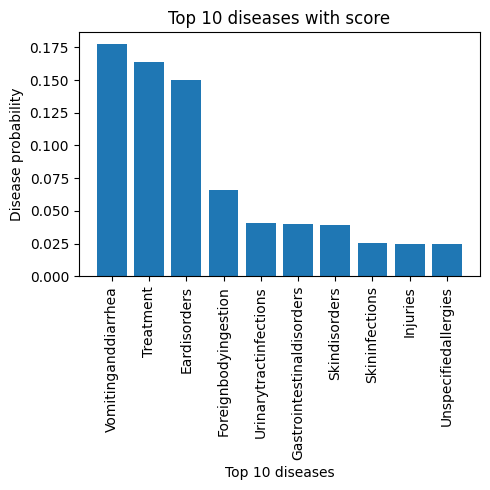

NameError: name 'plot_top_bottom_features' is not defined

In [13]:
categorical_dict = {
    "breed_type": list(range(64, 73)),
    "sub_breed": list(range(78, 99)),
    "super_breed": list(range(110, 128)),
    "breed_name": list(range(128, 178)),
    "demeanor": list(range(99, 103)),
    "trainability": list(range(105, 110)),
    "sheds": list(range(103, 105)),
    "gender": list(range(73, 75)),
    "country": list(range(178, 180)),
    "area_type": list(range(75, 78)),
    "diseases": list(range(0, 50))
}

# Create list of categorical indices
categorical_indices = []
for key in categorical_dict:
    categorical_indices.extend(categorical_dict[key])
    
# sample = x_test.iloc[139] # knee injuries 14%
sample = x_test.iloc[145]
# Initialize explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=x_train.iloc[:, 2:].values, 
    training_labels=y_train, 
    feature_names=list(x_train.columns[2:]), 
    categorical_features=categorical_indices, 
    mode="classification"
)
explanation = explainer.explain_instance((sample), my_classifier_run, num_samples=1000,
                                         feature_selection_threshold=0.0,
                                         median=False,
                                         add_non_zero=False,
                                         add_disease=False,
                                         remove_breed=True,
                                         top_labels=4)
sample_df = pd.DataFrame(sample).transpose()
plot_top_10_dieases(sample_df)
plot_top_bottom_features(explanation,sample_df)

In [137]:
def compare_feature(feature_list, feature_name):
    feature_strings = []
    # Search for strings containing the given feature name
    for feature in feature_list:
        if feature_name in feature:
            feature_strings.append(feature)
    # Check if there are two strings containing the feature
    if len(feature_strings) == 2:
        # Extract the boolean truth values from the strings
        bools = ['True' if "=" in string else 'False' for string in feature_strings]
        # Check if the two strings have opposite boolean truth values
        if bools[0] != bools[1]:
            # Find the string with the boolean value 'True'
            false_index = bools.index('False')
            
            # Delete the feature from feature_list
            feature_to_remove = feature_strings[false_index]
            
            return True, feature_to_remove
    return False, []

def update_result_values(classifier_results,feature_name, label):
    # Find keys that contain 'feature_name' but don't contain an '&'
    feature_name_keys = [key for key in classifier_results[label].keys() if feature_name in key and '&' not in key]
    # Initialize an array for the sums
    feature_name_sum = np.array([])

    # Sum up corresponding elements in the 'feature_name' arrays
    for key in feature_name_keys:
        if feature_name_sum.size == 0:
            # If feature_name is empty, assign the first array to it
            feature_name_sum = np.array(classifier_results[label][key])
        else:
            # If feature_name is not empty, add the next array element-wise
            feature_name_sum += np.array(classifier_results[label][key])
    # Convert back to list and store the result back into each 'feature_name' key
    for key in feature_name_keys:
        classifier_results[label][key] = feature_name_sum.tolist()
    return classifier_results

def update_results_if_required(feature_list, classifier_results, feature_name, label):
    bool_feature, feature_to_remove = compare_feature(feature_list, feature_name)
    if bool_feature == True:
        classifier_results = update_result_values(classifier_results, feature_name, label)
        feature_list = [feature for feature in feature_list if feature != feature_to_remove]
        del classifier_results[label][extract_feature_name(feature_to_remove)]
    return feature_list

def get_all_descendants(tree):
    descendants = []
    children = tree.get("children", [])
    for child in children:
        descendants.append(child.get("name"))
        descendants.extend(get_all_descendants(child))
    return descendants

# Recursive function to traverse the tree and generate mapping from each node to its descendants
def traverse_tree(tree):
    mapping = {}
    node_name = tree.get("name")
    descendants = get_all_descendants(tree)
    
    if node_name in mapping:
        mapping[node_name].extend(descendants)
    else:
        mapping[node_name] = descendants

    # Create a mapping for each child node
    for child in tree.get("children", []):
        child_mapping = traverse_tree(child)
        for key, value in child_mapping.items():
            if key in mapping:
                mapping[key].extend(value)
            else:
                mapping[key] = value

    return mapping
  
# Function to intersect keys list with removal lists and update breed features and removal lists accordingly  
def intersect_and_remove(keys_list, removal_lists, breed_children, breed_features):
    for key in keys_list:
        breed_child_values = set(breed_children[key])
        overlapping_keys = list(breed_child_values.intersection(sum(removal_lists, [])))
        breed_features[key] = overlapping_keys
        # Remove overlapping keys
        for overlap in overlapping_keys:
            for removal_list in removal_lists:
                if overlap in removal_list:
                    removal_list.remove(overlap)

def load_and_process_tree():
    # Load the JSON file
    with open('/Users/marvinseiferling/storage/breed_hierarchie/breed_groups.json', 'r') as f:
        trees = json.load(f)
    # Create a mapping from each node to its descendants
    node_to_descendants = {}
    for tree in trees:
        node_to_descendants.update(traverse_tree(tree)) 
    return node_to_descendants

def create_hierarchy_dict(breed_children, breed_features):
    # Separate keys based on breed category
    breed_type_keys = [key for key in breed_children.keys() if 'Breed Type' in key]
    super_breed_keys = [key for key in breed_children.keys() if 'Super Breed' in key]
    sub_breed_keys = [key for key in breed_children.keys() if 'Sub Breed' in key]
    breed_name_keys = [key for key in breed_children.keys() if 'Breed Name' in key]

    # Intersect and remove overlapping keys
    intersect_and_remove(breed_type_keys, [super_breed_keys, sub_breed_keys, breed_name_keys], breed_children, breed_features)
    intersect_and_remove(super_breed_keys, [sub_breed_keys, breed_name_keys], breed_children, breed_features)
    intersect_and_remove(sub_breed_keys, [breed_name_keys], breed_children, breed_features)

    # Combine all keys and update breed features accordingly
    breed_features_combined = breed_type_keys + super_breed_keys + sub_breed_keys + breed_name_keys
    breed_features = {key: breed_features[key] for key in breed_features_combined}
    return breed_features

def process_breed_tree(label, results, feature_list, node_to_descendants):
    # Identify keys related to breed information
    search_strings = ['Sub Breed', 'Super Breed', 'Breed Name', 'Breed Type']
    found_breed_keys = []
    for key in results[label]:
        for search_string in search_strings:
            if search_string in key:
                found_breed_keys.append(key)
    
    # Create dictionaries to store breed children and features
    breed_children = {item: node_to_descendants.get(item, []) for item in found_breed_keys}
    breed_features = {item: [] for item in found_breed_keys}
    
    #seperate features with = sign and ≠ sign into seperate dicts
    breed_children_equal = {}
    breed_children_unequal = {}
    for key,value in breed_children.items():
        if key in feature_list: 
            #key has = sign
            breed_children_equal[key] = value
        else:
            #key has ≠ sign
            breed_children_unequal[key] = value
            
    # create the hierarchy of dog breeds 
    updated_breed_features_equal = create_hierarchy_dict(breed_children_equal, breed_features)
    updated_breed_features_unequal = create_hierarchy_dict(breed_children_unequal, breed_features)
    # combine both hierarchies
    combined_breed_features = {**updated_breed_features_equal, **updated_breed_features_unequal}
    #delete names in feature list
    combined_values = [value for sublist in combined_breed_features.values() for value in sublist]
    feature_list=[feature for feature in feature_list if extract_feature_name(feature) not in combined_values]    
    return combined_breed_features, feature_list

def process_breeds_in_results(label, breed_features, results):
    # accumulate the feature importances inside the Key Breed 
    for key in breed_features:
        for breed_name in breed_features[key]:
            results[label][key] = [a + b for a, b in zip(results[label][key], results[label][breed_name])]
            # Replace the Feature Importance Values for the Breeds that have been accumulated in the Key Breed
            del results[label][breed_name]


def find_features_in_category(feature_names, mean_scores_percentage, boxplot_data_percentage, features):
    overlapping_features = []
    associated_mean_scores = []
    associated_boxplot_data = []
    for index, feature_value in enumerate(features):
        for feature in feature_names:
            if feature in feature_value:
                overlapping_features.append(feature_value)
                associated_mean_scores.append(mean_scores_percentage[index])
                associated_boxplot_data.append(boxplot_data_percentage[index])
                break
    return overlapping_features, associated_mean_scores, associated_boxplot_data

def plot_pie_chart(ax, mean_scores_percentage):
    # Calculate the total percentage based on the absolute values of the first three elements
    total_percentage = np.sum(np.abs(mean_scores_percentage))
    colors = ['grey', 'white']
    # Plot a pie chart with the total percentage and the remaining percentage
    ax.pie([total_percentage, 100 - total_percentage], colors=colors, startangle=90, wedgeprops=dict(edgecolor='black', linewidth=1))
    ax.axis('equal')
    # Add a legend with the total percentage
    legend = ax.legend([f'{int(np.round(total_percentage))}%'], title='Sum Feature Importances', loc='lower left')
    frame = legend.get_frame()
    bbox = frame.get_bbox()
    # Add a text description below the legend
    description = 'Explanations accounted for in Bar Chart'
    plt.text(bbox.x0+0.218, bbox.y0-0.1, description, ha='center', va='baseline', transform=ax.transAxes, color='grey')
    
def get_min_max(mean_scores_percentage):
    def round_to_nearest_five(n):
        if n < 0:
            return int(math.floor(n / 5)) * 5
        else:
            return int(math.ceil(n / 5)) * 5

    biggest_value = max(mean_scores_percentage)
    lowest_value = min(mean_scores_percentage)

    biggest_value_rounded = round_to_nearest_five(biggest_value)
    lowest_value_rounded = round_to_nearest_five(lowest_value)

    # Increment by 5 only if the original values, when rounded, are multiples of 5
    if round(biggest_value) % 5 == 0:
        biggest_value_rounded += 5

    if round(lowest_value) % 5 == 0:
        lowest_value_rounded -= 5

    return lowest_value_rounded, biggest_value_rounded

def delete_unequal(features, mean_scores, boxplot):
    equal_features = []
    equal_scores = []
    equal_boxplot = []
    for index, feature in enumerate(features):
        if "≠" not in feature:
            equal_features.append(feature)
            equal_scores.append(mean_scores[index])
            equal_boxplot.append(boxplot[index])
    return equal_features, equal_scores, equal_boxplot


def other_split(features, mean_scores, boxplot, other_threshold):
    equal_features = []
    equal_scores = []
    equal_boxplot = []
    
    other_positive_scores = []
    other_negative_scores = []
    for index, feature in enumerate(features):
        if "≠" in feature or abs(mean_scores[index]) < other_threshold:
            if mean_scores[index] > 0:
                other_positive_scores.append(mean_scores[index])
            else:
                other_negative_scores.append(mean_scores[index])
        else:
            equal_features.append(feature)
            equal_scores.append(mean_scores[index])
            equal_boxplot.append(boxplot[index])
            
    # simplify graph by adding the positive and negative scores of the additional scores       
    other_sum=sum(other_positive_scores)+sum(other_negative_scores)
    other_data = [(f'Others', other_sum,[])]
    
    # Calculate the absolute maximum value in equal_scores
    max_value = max([abs(score) for score in equal_scores]) if equal_scores else 0

    # Check if the other_sum is at least 1% of max_value
    is_visible = abs(other_sum) >= 0.01 * max_value
    
    # Append to equal features
    for feature_name, score, boxplot_data in other_data:
        if score != 0 and is_visible:
            equal_features.insert(0, feature_name)
            equal_scores.insert(0, score)
            equal_boxplot.insert(0, boxplot_data)
            
    return equal_features, equal_scores, equal_boxplot

def format_feature_name(feature):
    padding_length = 35  # Adjust this value as necessary

    if "\n&\n" in feature:
        feature_1, feature_2 = feature.split("\n&\n")
        length=int(len(feature_1)/2)
        return feature_1.rjust(padding_length) + "\n" + "&".ljust(length) + "\n" + feature_2.rjust(padding_length)
    else:
        return feature.rjust(padding_length)
    
def plot_lime_feature_importance(mean_scores_percentage, boxplot_data_percentage, selected_features, feature_names, label, min_mean, max_mean, top_title, other_threshold=0):
    # only show features that directly apply to dog and are siginifcant => above threshold
    selected_features, mean_scores_percentage, boxplot_data_percentage = other_split(
    selected_features, mean_scores_percentage, boxplot_data_percentage, other_threshold) 

    # Calculate the number of bars and the height of the figure
    num_bars = max(1, len(selected_features))
    bar_height = 0.8
    fig = plt.figure(figsize=(10, num_bars+1))
    # Create a grid layout for the plot
    gs = GridSpec(2, 1, height_ratios=[1, num_bars+1], hspace=0.8/num_bars)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    # Plot the pie chart
    plot_pie_chart(ax1, mean_scores_percentage)
    xlim=max(abs(min_mean),max_mean)
    ax2.set_xlim(-xlim, xlim)
    plt.rcParams['font.family'] = 'monaco'
    
    # Set the x-axis label and tick parameters
    ax2.set_xlabel('Contribution to Disease Prediction (%)', fontsize=12)
    ax2.tick_params(axis='both', labelsize=12)
    # add padding for feature names
    selected_features = [format_feature_name(feature) for feature in selected_features]
    
    # Plot the bar and boxplot if mean_scores_percentage is provided
    if mean_scores_percentage:
        # Determine the color of bars based on the sign of the score
        color_palette = ['red' if score > 0 else 'green' for score in mean_scores_percentage]
        feature_positions = np.arange(len(selected_features))
        # Plot horizontal bars and boxplot
        ax2.barh(feature_positions, mean_scores_percentage, color=color_palette, height=bar_height)
        #only show boxplot if distribution range is larger than 1% of mode value
        show_boxplot_for_feature = [max(data) - min(data) > abs(0.1 * mean_score) if (data.any() if isinstance(data, np.ndarray) else data) else False
                                    for data, mean_score in zip(boxplot_data_percentage, mean_scores_percentage)]
        for i, show_boxplot in enumerate(show_boxplot_for_feature):
            if show_boxplot:
                ax2.boxplot(boxplot_data_percentage[i], vert=False, positions=[feature_positions[i]], widths=0.4, whis=(0, 100))
            
        # Format the x-axis labels as percentages
        formatter = FuncFormatter(lambda x, _: '{:.0f}%'.format(abs(x)))
        ax2.xaxis.set_major_formatter(formatter)
        # Set y-axis ticks and labels
        ax2.set_yticks(feature_positions)
        ax2.set_yticklabels(selected_features)
        # Set the top title
        ax1.set_title(f'{top_title}:', fontsize=18)
    else:
        # In case of no mean_scores_percentage, remove y-ticks and set an error title
        ax2.set_yticks([])   
        ax1.set_title(f'No {top_title}', fontsize=16, color='red')

    # Set the title for the feature importance plot
    title_text = f'Lime Explanation: Feature Importance for "{feature_names[label]}"'
    ax2.set_title(title_text, fontsize=14)
    # save plots in folder
    save_plot(feature_names[label], top_title, fig, True)

    plt.show()
    
def save_plot(feature_name, top_title, fig, include_boxplot):
    disease_dir = f"{feature_name.replace(' ', '_')}"
    disease_dir_path = os.path.join(lime_folder_path, disease_dir)

    # Check if the folder already exists
    if not os.path.exists(disease_dir_path):    
        os.makedirs(disease_dir_path)

    filename = f"{top_title.replace(' ', '_').replace('/', '_')}.png"
    if include_boxplot:
        filename = f"{top_title.replace(' ', '_').replace('/', '_')}.png"
    else:
        filename = f"{top_title.replace(' ', '_').replace('/', '_')}_no_boxplot.png"
    file_path = os.path.join(disease_dir_path, filename)
    fig.savefig(file_path, bbox_inches='tight')
    
def save_results_in_folder(data, data_name, pet_number, num_runs, num_samples):
    pet_id = data.iloc[pet_number]['PetId']
    super_folder = f"{pet_id}_{data_name}_{pet_number}"
    sub_folder= f"runs_{num_runs}_samples_{num_samples}"
    
    # Define the base path
    base_path = "/Users/marvinseiferling/XAI/Lime_plots"
    
    # Combine with the result string to create the full path
    super_folder_path = os.path.join(base_path, super_folder)
    sub_folder_path = os.path.join(super_folder_path, sub_folder)
    
    # Check if the folder already exists
    if not os.path.exists(super_folder_path):    
        os.makedirs(super_folder_path)
        
    if os.path.exists(sub_folder_path):
        # Remove it if it does
        shutil.rmtree(sub_folder_path)
    
    os.makedirs(sub_folder_path)

    return sub_folder_path
    
def get_half_sample_with_smallest_spread(sample):
    n = len(sample)
    sample.sort()
    
    # Initialize minimum spread and corresponding half sample
    min_spread = float('inf')
    best_half_sample = []
    
    # Iterate through all possible half-sized sub-samples
    for i in range(0, n - n//2 + 1):  # +1 ensures the loop considers the last n//2 elements
        current_half_sample = sample[i:i + n//2]
        current_spread = current_half_sample[-1] - current_half_sample[0]
        
        if current_spread < min_spread:
            min_spread = current_spread
            best_half_sample = current_half_sample
            
    return best_half_sample

def get_half_sample_with_highest_density(sample):
    sample.sort()

    min_value, max_value = min(sample), max(sample)
    half_range = (max_value - min_value) / 2

    max_count = 0
    best_start_index = 0
    end = 0

    # Use two pointers to efficiently compute the number of elements in each window
    for start in range(len(sample)):
        # Move the end pointer as far to the right as possible while keeping the difference less than half_range
        while end < len(sample) and sample[end] - sample[start] <= half_range:
            end += 1
        
        # Calculate number of elements in the current window
        count = end - start

        # Update best_start_index if current window has more elements
        if count > max_count:
            max_count = count
            best_start_index = start

    # Extract elements from the densest window
    dense_sample = sample[best_start_index:end]

    return dense_sample


def half_sample_mode(data):
    # Get half of the sample with the smallest spread
    half_data = get_half_sample_with_highest_density(data)
    
    # Determine number of bins based on full data length
    num_bins = int(np.sqrt(len(data)))

    # Compute bin width using half sample
    min_value, max_value = min(half_data), max(half_data)
    # mode is already known if all values are the same 
    if min_value == max_value:
        return min_value
    bin_width = (max_value - min_value) / num_bins

    # Initialize count vector for bin frequencies
    bin_counts = [0] * num_bins

    # Assign each data point in the half sample to a bin
    for value in half_data:     
        bin_index = int((value - min_value) / bin_width)
        
        # Handling edge case where value is exactly the max value
        if bin_index == num_bins:
            bin_index -= 1
        
        # Update bin counts
        bin_counts[bin_index] += 1

    # Find the bin with the maximum count and determine the mode estimate
    bin_with_max_count = np.argmax(bin_counts)
    mode_estimate = min_value + (bin_with_max_count + 0.5) * bin_width 

    return mode_estimate

from scipy.stats import gaussian_kde

def kde_mode(data):

    # Generate sample points for evaluation (over a dense grid)
    min_data, max_data = min(data), max(data)
    # mode is already known if all values are the same 
    if min_data == max_data:
        return min_data
    x_grid = np.linspace(min_data, max_data, 1000)
    
    # Create a KDE estimate of the data
    kde = gaussian_kde(data)
    # Evaluate the KDE at each point on the grid
    kde_values = kde(x_grid)

    # Find the x value where the KDE is the highest (this is our mode estimate)
    mode_estimate = x_grid[np.argmax(kde_values)]
    
#     # Visualization
#     fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#     # Plot Histogram
#     axs[0].hist(data, bins=30, color='gray', alpha=0.7)
#     axs[0].set_title('Histogram of Data')
#     axs[0].set_xlabel('Value')
#     axs[0].set_ylabel('Frequency')
#     axs[0].grid(True)

#     # Plot KDE
#     axs[1].plot(x_grid, kde_values, label='KDE', color='blue')
#     axs[1].axvline(mode_estimate, color='red', linestyle='dashed', label=f'Mode Estimate: {mode_estimate:.2f}')
#     axs[1].set_title('Kernel Density Estimation and Mode')
#     axs[1].set_xlabel('Value')
#     axs[1].set_ylabel('Density')
#     axs[1].legend()
#     axs[1].grid(True)

#     plt.tight_layout()
#     plt.show()


    return mode_estimate

def half_sample_mode_with_kde(data):
    # Get half of the sample with the smallest spread
    half_data = get_half_sample_with_highest_density(data)
    
    # Use KDE to estimate the mode
    mode_estimate = kde_mode(half_data)

    return mode_estimate

def bootstrap_features(results, label, num_samples=1000, confidence_level=0.95):
    bootstrap_results = {label: {}}
    boxplot_modes={}
    z_value = norm.ppf((1 + confidence_level) / 2)
    for feature_name in results[label]:
        if feature_name != 'importance_weights':
            importance_values = results[label][feature_name]
            importance_weights = results[label]['importance_weights']
            # get non-Nan values from importance_values and their corresponding importance_weights
            importance_values, importance_weights = zip(*[(value, weight) for value, weight in zip(importance_values, importance_weights) if not np.isnan(value)])
            #normalize the weights between 0-1
            importance_weights_normalized = np.array(importance_weights) / sum(importance_weights)      
            
            bootstrap_modes = []
            np.random.seed(42)
            for _ in range(num_samples):
                bootstrap_sample = np.random.choice(importance_values, len(importance_values), p=importance_weights_normalized)
                bootstrap_sample_mode=kde_mode(bootstrap_sample)
                bootstrap_modes.append(bootstrap_sample_mode)
                std_standard_error = np.nanstd(bootstrap_modes) / np.sqrt(num_samples) # Standard error
                margin_of_error = z_value * std_standard_error
                
            mode_value= kde_mode(bootstrap_modes)
            bootstrap_results[label][feature_name] = (mode_value, std_standard_error, margin_of_error)
            boxplot_modes[feature_name]=bootstrap_modes
            #visualize_bootstrapping_histogram(bootstrap_modes)
    return bootstrap_results,boxplot_modes
    
def visualize_bootstrapping_histogram(bootstrap_modes):
    plt.figure(figsize=(5, 3))
    
    num_bins = int(np.sqrt(len(bootstrap_modes)))
    
    # Plot histogram of bootstrap means
    plt.hist(bootstrap_modes, bins=num_bins, color='gray', alpha=0.6, edgecolor='black')

    
    # Overlaying the average importance line
    #mode_value= kde_mode(bootstrap_modes)
    #plt.axvline(mode_value, color='red', linewidth=2, label='Average Importance Across Bootstraps')
    
    plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    
    plt.xlabel('Feature Importance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Feature Importance Modes')
    plt.show()

    
def visualize_margins_of_error(bootstrap_results, label):
    margins_of_error_percent = []
    for feature_name, values in bootstrap_results[label].items():
        mean_bootstrap_means, _, margin_of_error = values
        margin_of_error_percent = abs(100 * margin_of_error / mean_bootstrap_means)
        margins_of_error_percent.append(margin_of_error_percent)

    plt.hist(margins_of_error_percent,bins=3, edgecolor='black')
    plt.title('Histogram of Margins of Error (as percentage of mean)')
    plt.xlabel('Margin of Error (%)')
    plt.ylabel('Frequency')
    max_ytick = max(plt.yticks()[0]) # Get the maximum y-tick
    plt.yticks(np.arange(0, max_ytick+1, 5)) 
    plt.show()
    
def extract_feature_name(feature_string,split=False):
    """Extracts the feature name from the string."""
    # Detect and replace unequal sign (≠) with equals sign (=)
    feature_string = feature_string.replace('≠', '=')
    
    # Check for combined feature names and handle recursively
    if '\n&\n' in feature_string:
        if split:
            # return both feature names 
            return list(map(extract_feature_name, feature_string.split('\n&\n')))
        else:
            return '\n&\n'.join(map(extract_feature_name, feature_string.split('\n&\n')))
    
    # Match patterns 'No xxx', 'xxx Present', 'Energy Level', and general pattern.
    for pattern in [r'No (.+)', r'(.+) Present', r'Energy Level', r'([A-Za-z]+[A-Za-z0-9-=\s%°]*)']:
        match = re.search(pattern, feature_string)
        if match:
            # If pattern matches 'Energy Level', just return it directly
            if pattern == 'Energy Level':
                return 'Energy Level'
            # Extract matched group excluding None values
            return next(group for group in match.groups() if group is not None).strip()
    return None 
    
def get_feature_names_from_explanation(explainer, explanation, label):
    #Generate feature names based on the explanation for a given label.
    
    feature_indices = [feature_index[0] for feature_index in explanation.local_exp[label]]
    used_feature_names = []
    
    for index in feature_indices:
        if isinstance(index, tuple):  # it's an interaction
            feature1_name = explainer.feature_names[index[0]]
            feature2_name = explainer.feature_names[index[1]]
            combined_name = feature1_name + "\n&\n" + feature2_name
            used_feature_names.append(combined_name)
        else:  # it's a single feature
            used_feature_names.append(explainer.feature_names[index])
    
    return used_feature_names

def filter_interaction_features(sorted_features, bootstrap_results, label):
    # Initialize a set to store features that should be deleted
    del_features = set()

    # Iterate through each feature in the sorted list
    for feature in sorted_features:
        # Check if the feature is an interaction feature (indicated by the '\n&\n' substring)
        if '\n&\n' in feature:
            # Extract the combined feature name and individual features involved in the interaction
            combined_feature = extract_feature_name(feature)
            feature_1, feature_2 = extract_feature_name(feature, split=True)

            # Retrieve the values associated with each of the features from the bootstrap results
            combined_value = bootstrap_results[label].get(combined_feature, [0])[0]
            feature_1_value = bootstrap_results[label].get(feature_1, [0])[0]
            feature_2_value = bootstrap_results[label].get(feature_2, [0])[0]

            # Calculate the combined value of the two individual features
            absolute_sum = abs(feature_1_value + feature_2_value)
            absolute_largest_feature = max(abs(feature_1_value), abs(feature_2_value))
            independent_value = max(absolute_sum, absolute_largest_feature)

            # Compare the interaction feature's value with the combined individual values
            # Decide which features to remove based on their absolute values
            if abs(combined_value) > independent_value:
                del_features.add(feature_1)
                del_features.add(feature_2)
            else:
                del_features.add(combined_feature)
    # Generate a new list excluding the features identified for deletion
    feature_list = [feature for feature in sorted_features if extract_feature_name(feature) not in del_features]
    # Remove identified features from the bootstrap copy
    for feature in del_features:
        bootstrap_results[label].pop(feature, None)
    
    return feature_list, bootstrap_results

def sort_features_by_score(bootstrap_results, label):
    results = bootstrap_results[label]
    
    # Extracting feature names and their corresponding scores
    features = [(feature_name, values[0]) for feature_name, values in results.items()]
    
    # Sorting the features based on scores in descending order
    sorted_features = sorted(features, key=lambda x: abs(x[1]), reverse=False)
    
    # Extracting and returning the sorted list of feature names
    return [feature[0] for feature in sorted_features]

def features_to_remove(results, label):
    features_to_remove = []

    for feature, importance_values in results[label].items():
        # Calculate the 2.5th and 97.5th percentiles
        lower_bound, upper_bound = np.percentile(importance_values, [2.5, 97.5])
        
        # If the confidence interval contains zero, mark the feature for removal
        if lower_bound <= 0 and upper_bound >= 0:
            features_to_remove.append(feature)

    return features_to_remove

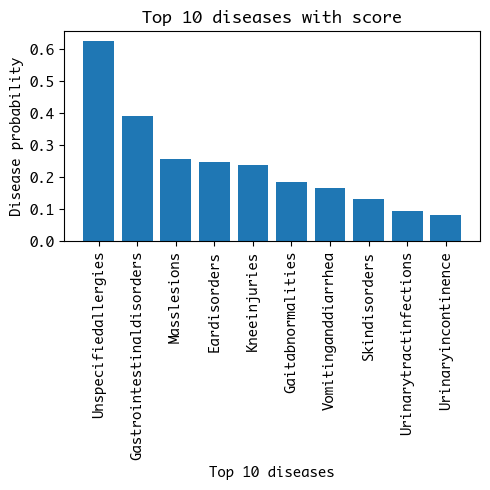

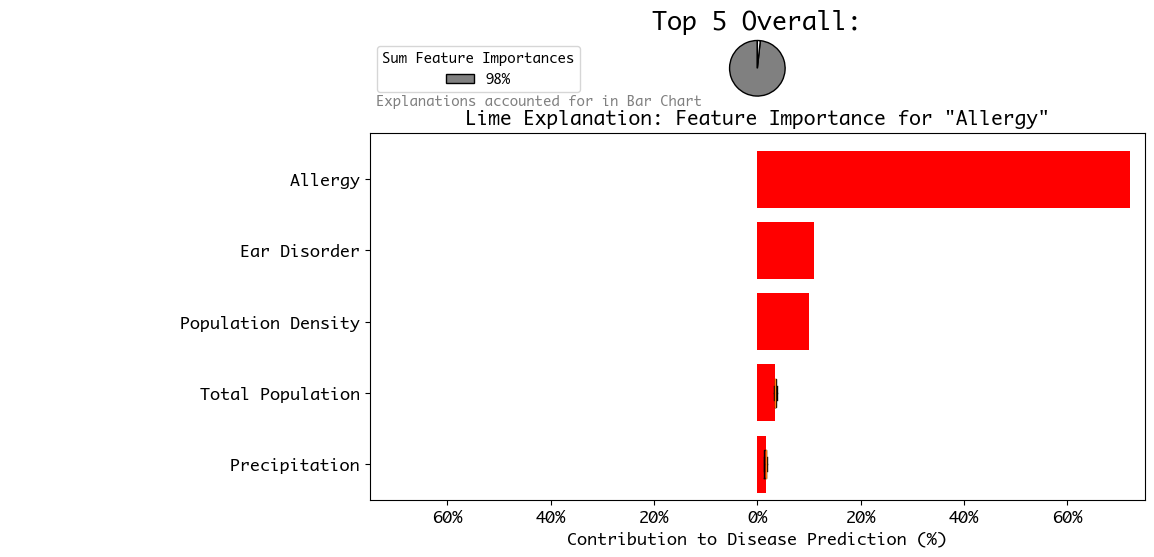

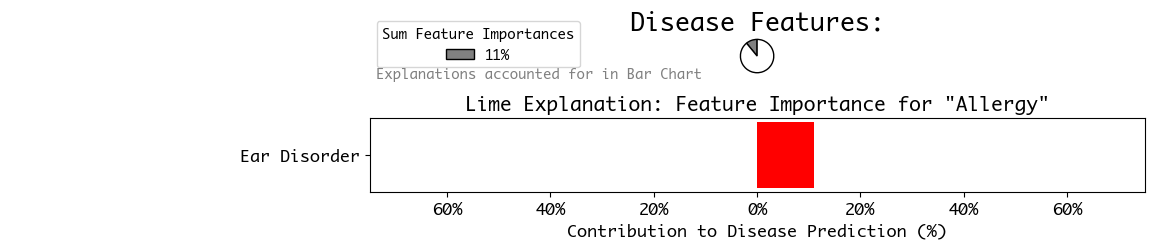

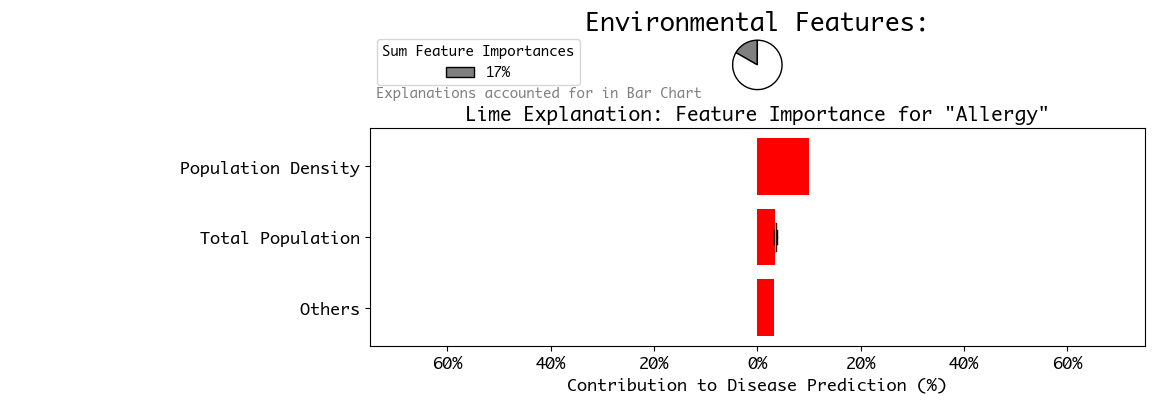

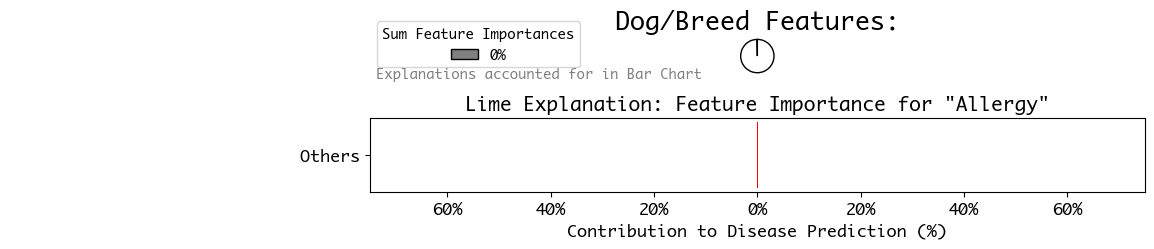

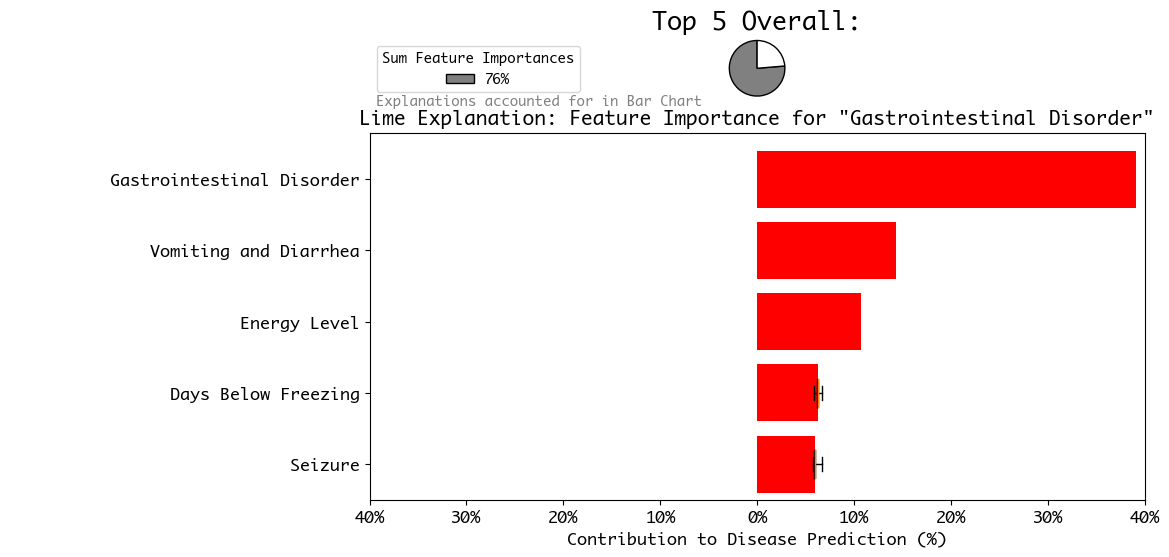

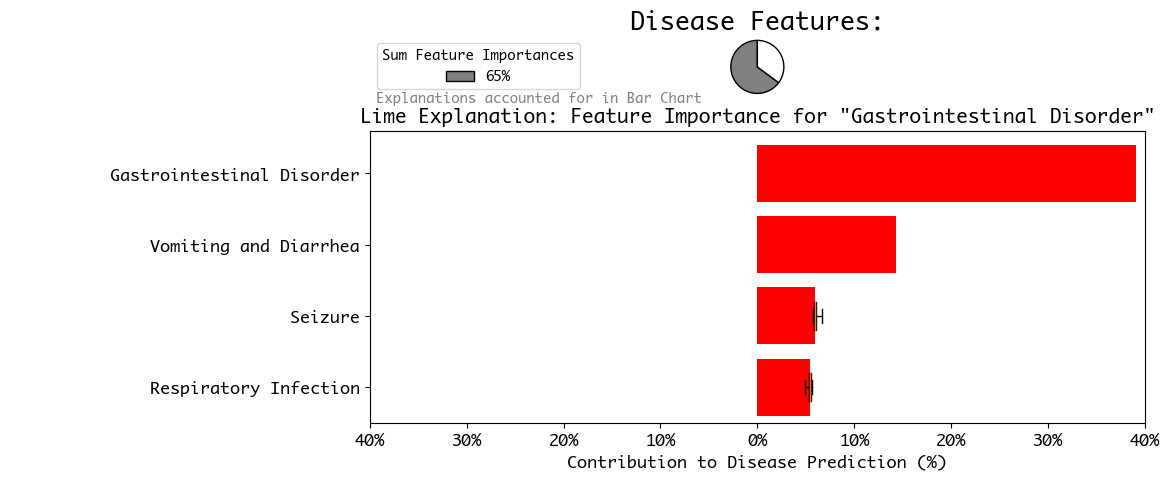

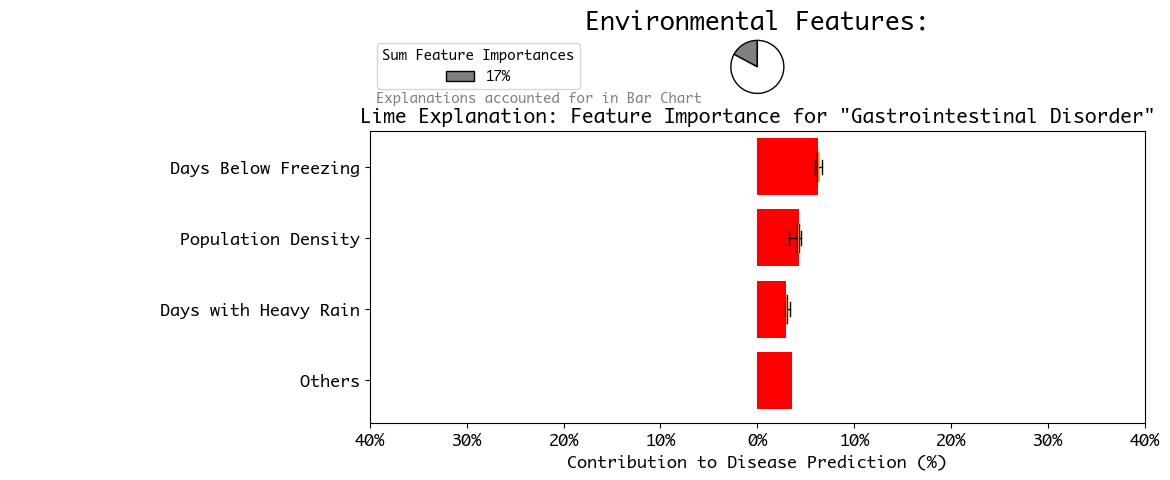

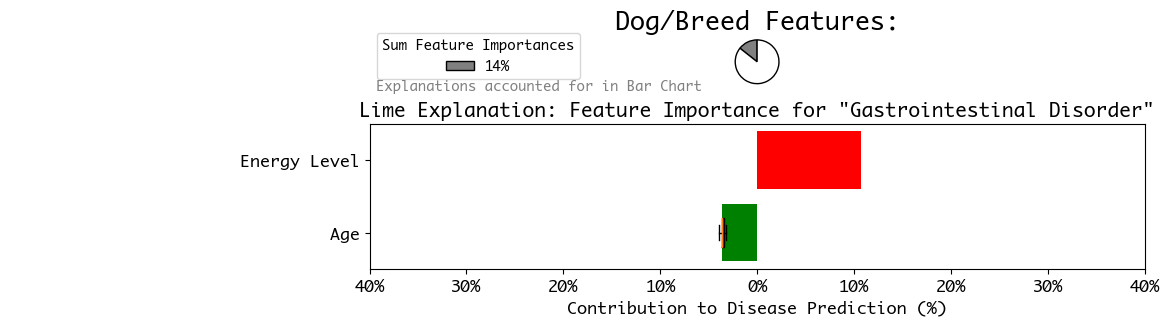

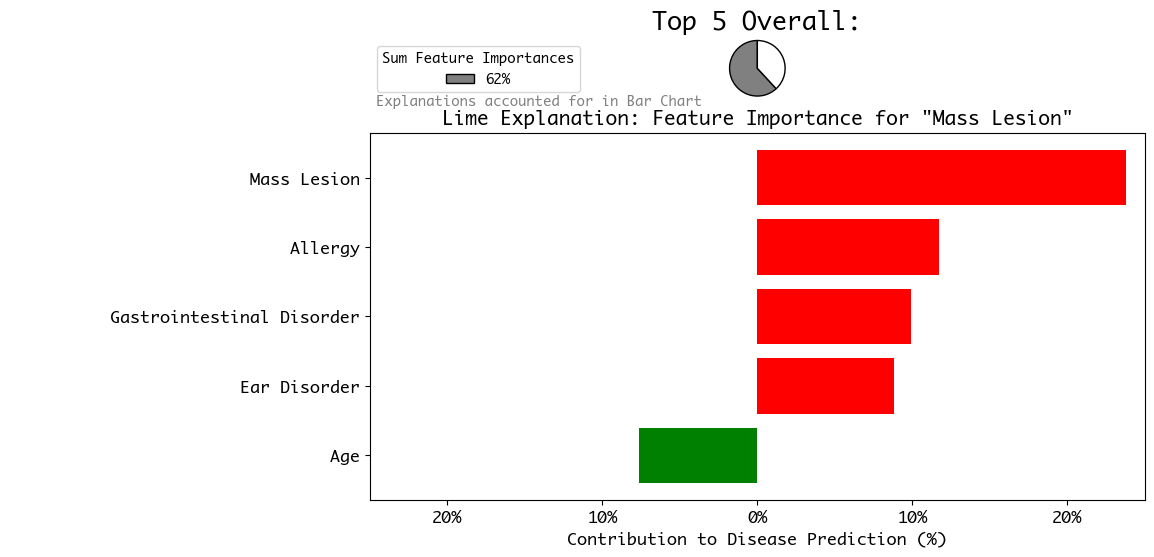

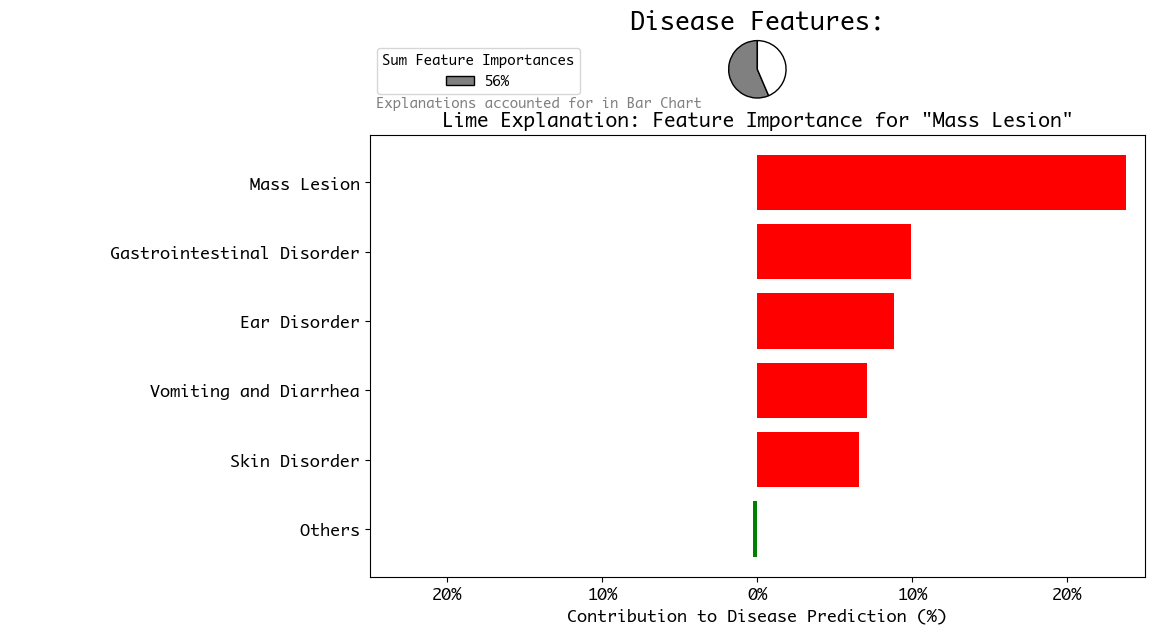

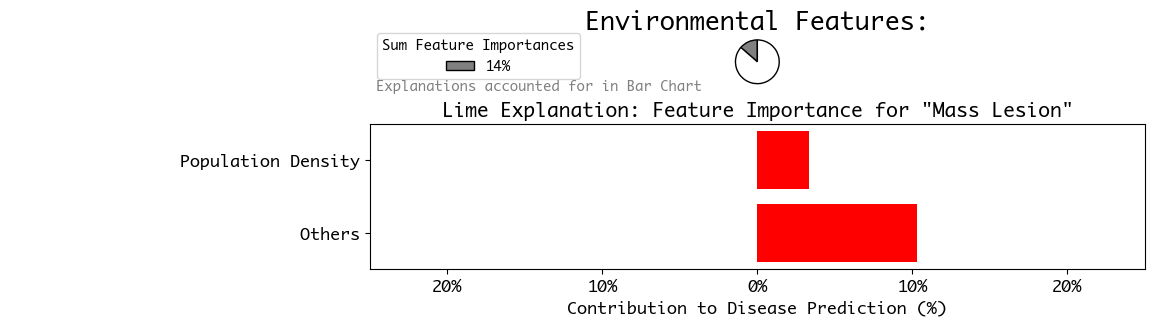

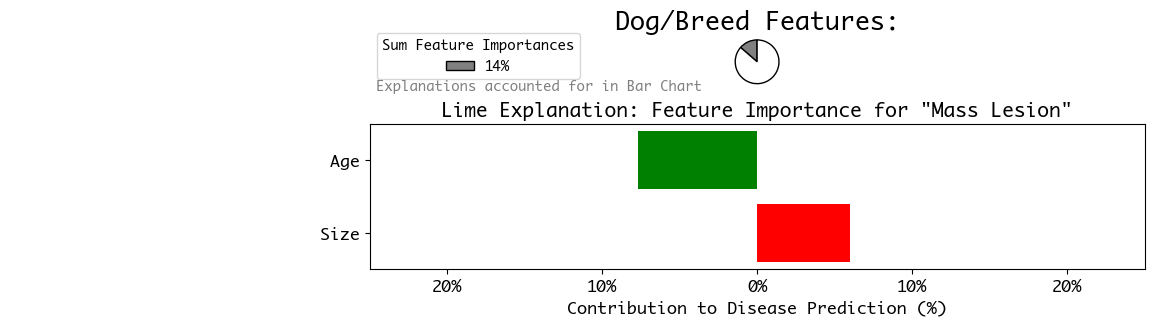

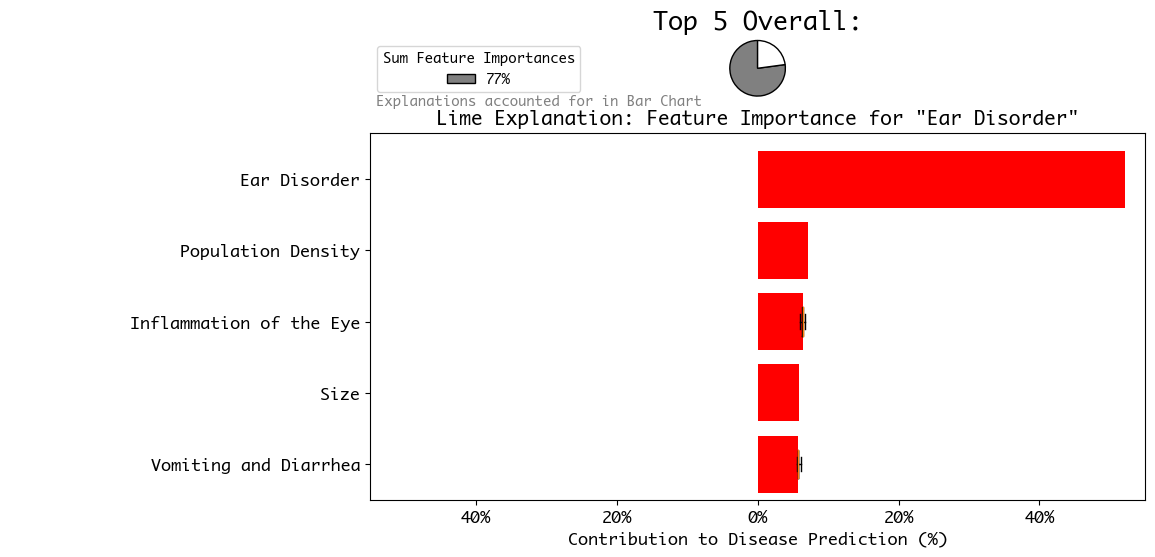

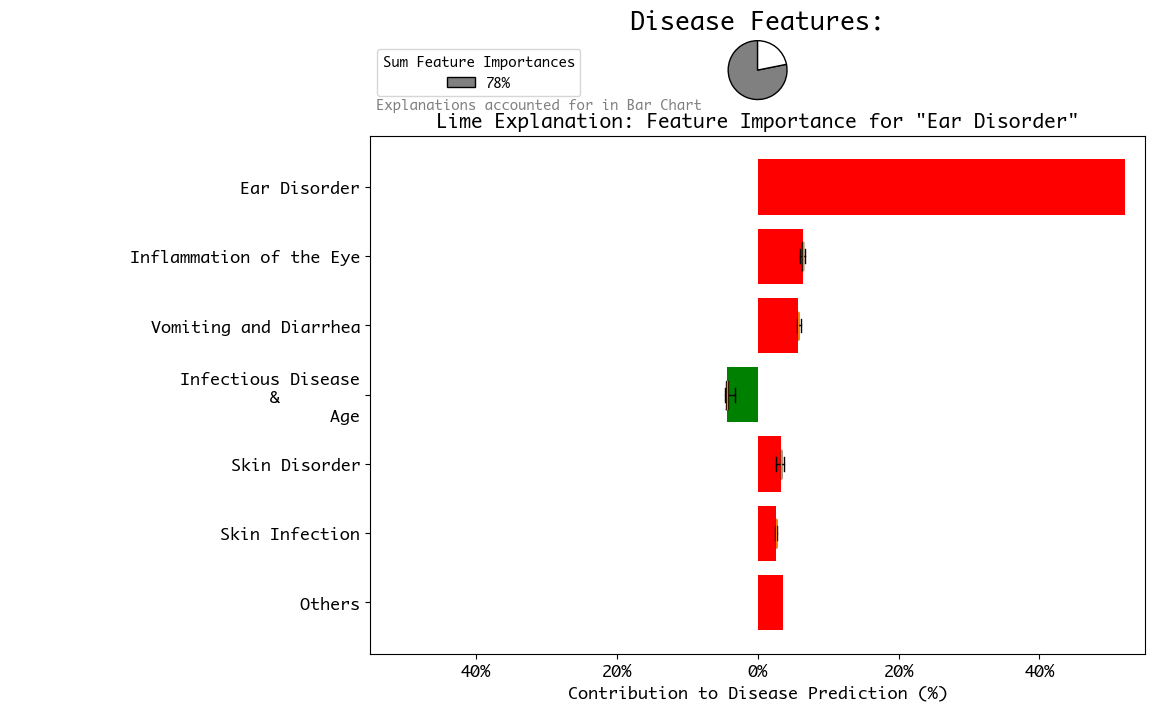

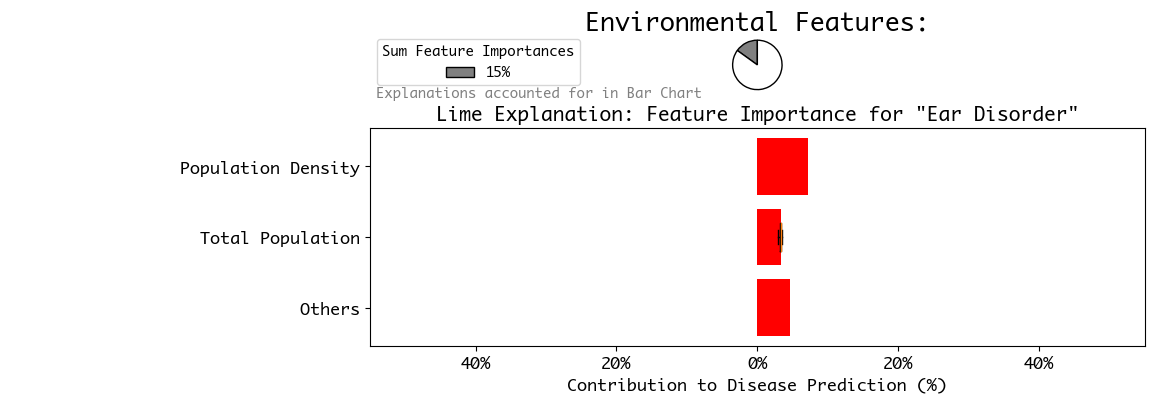

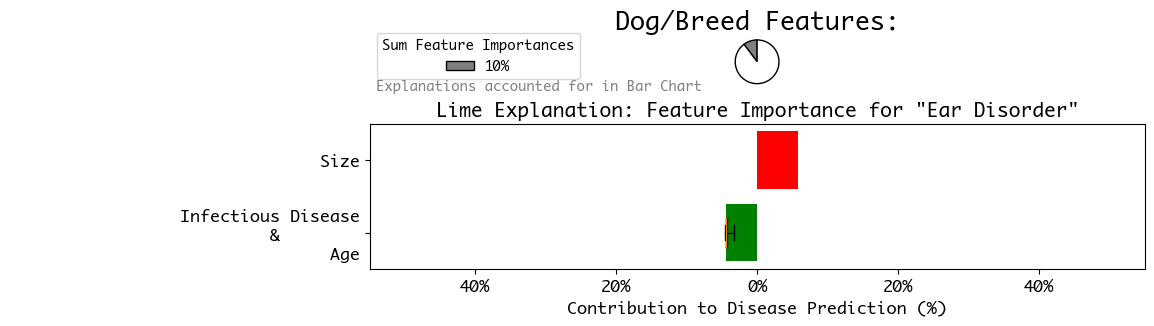

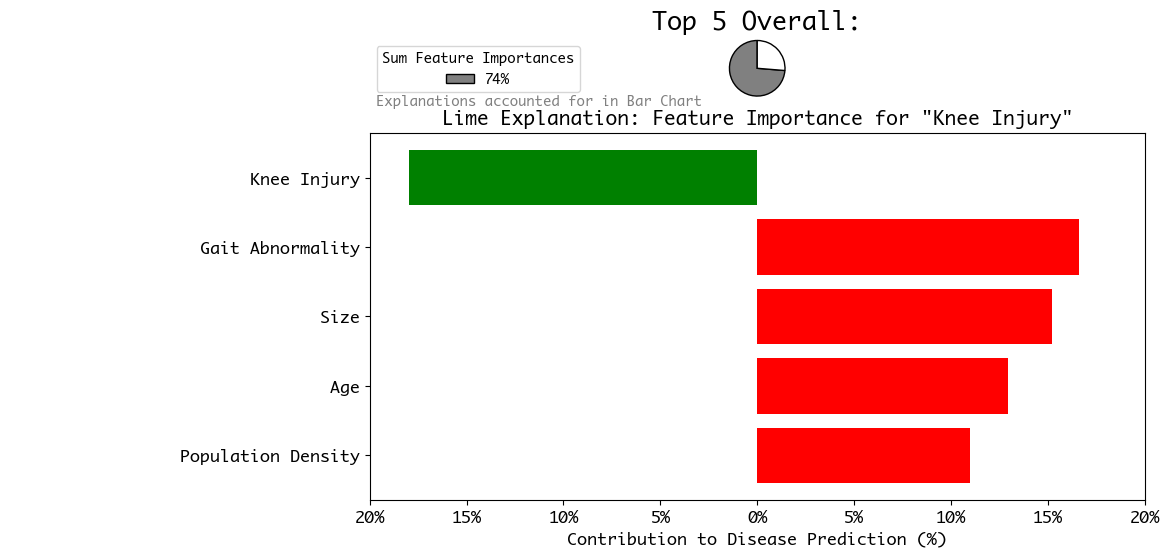

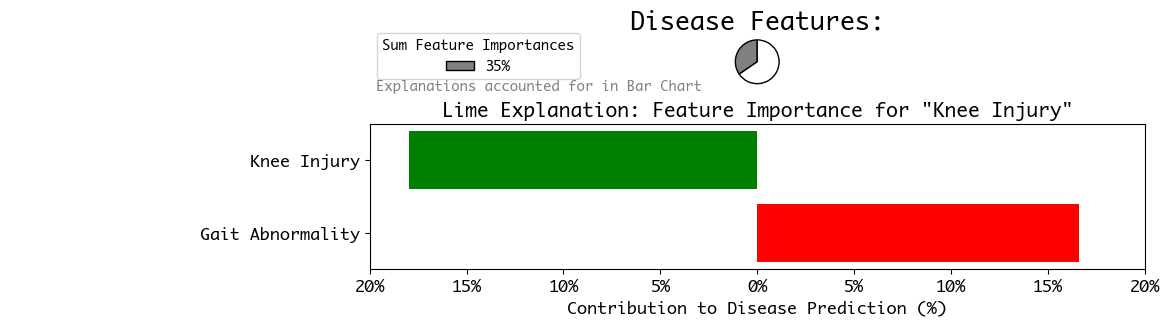

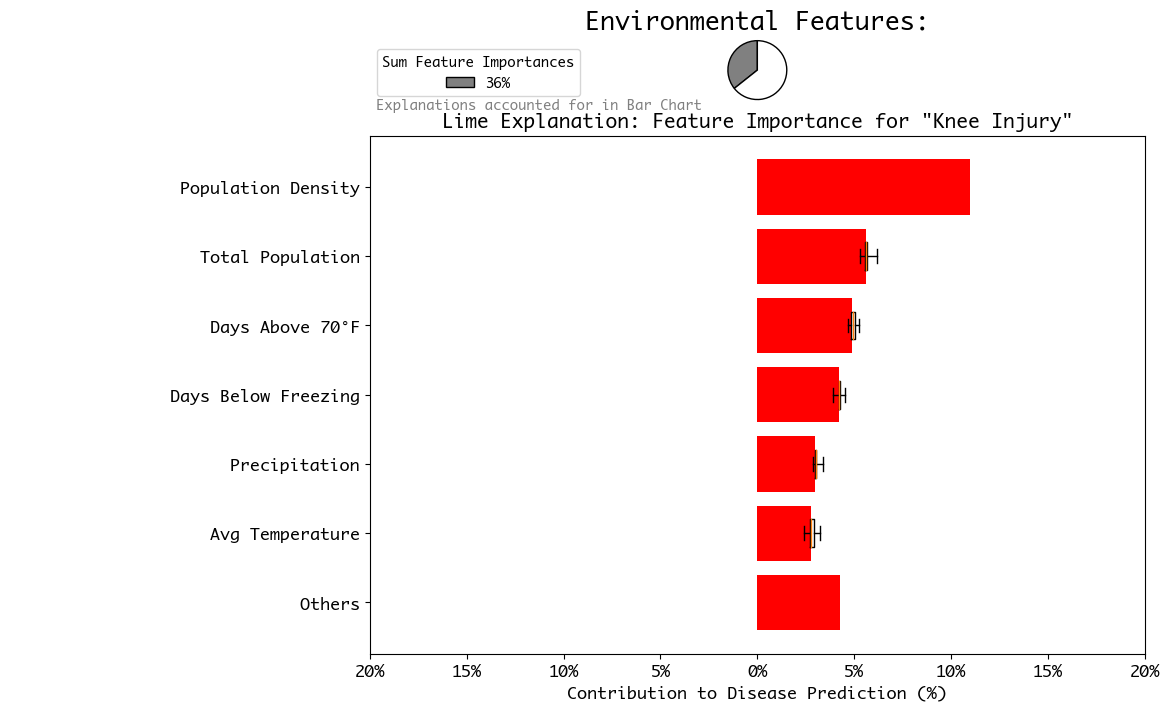

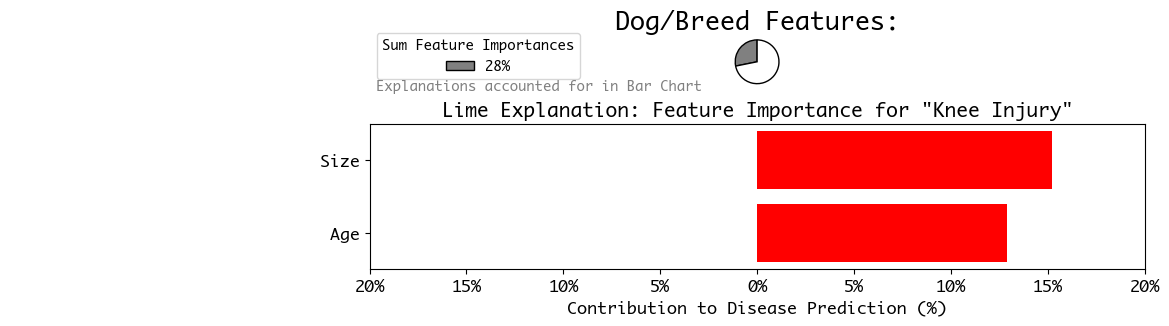

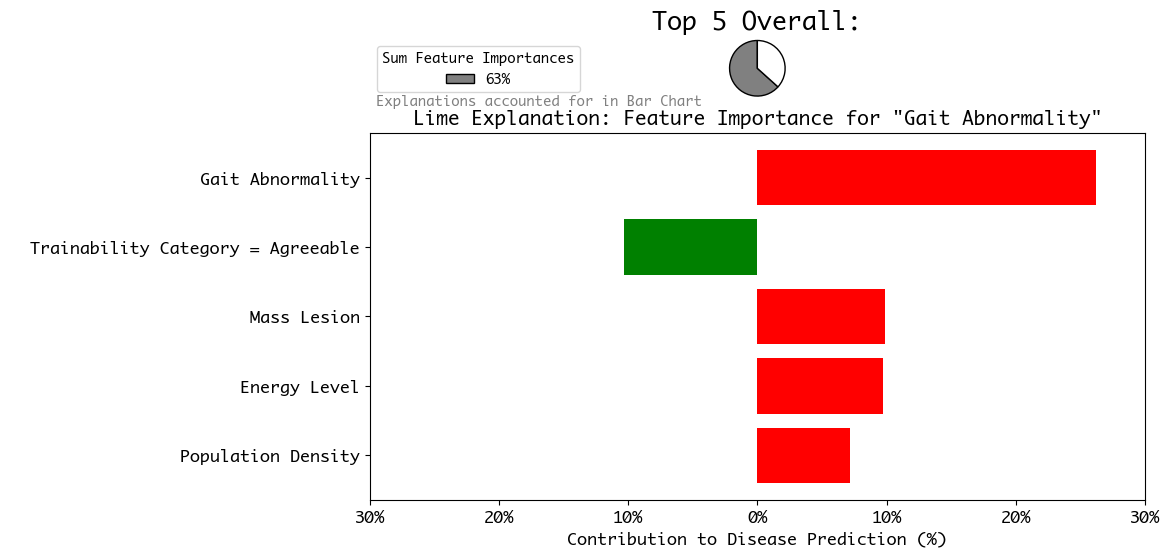

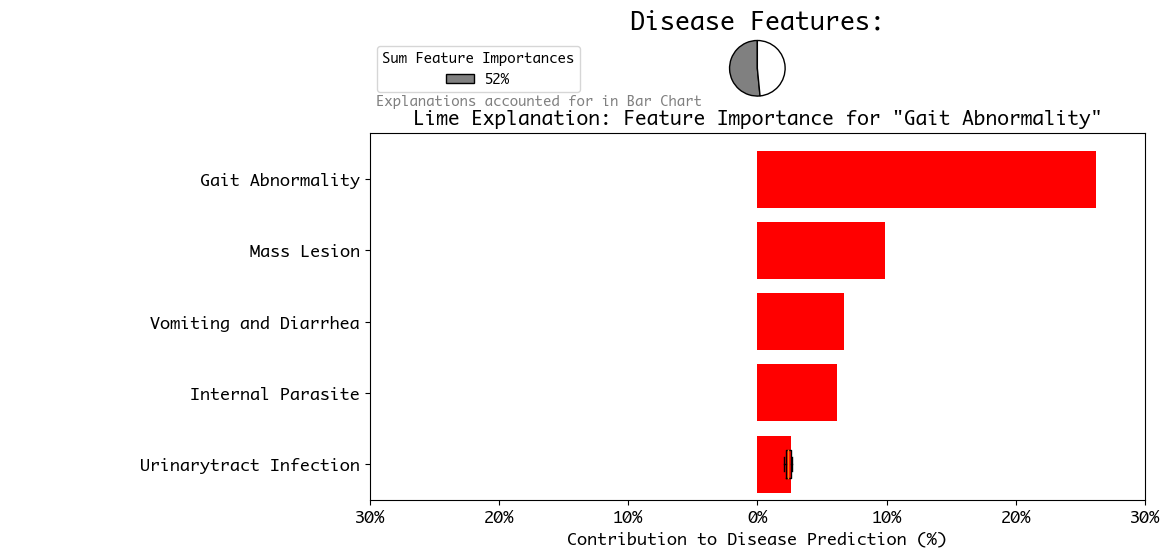

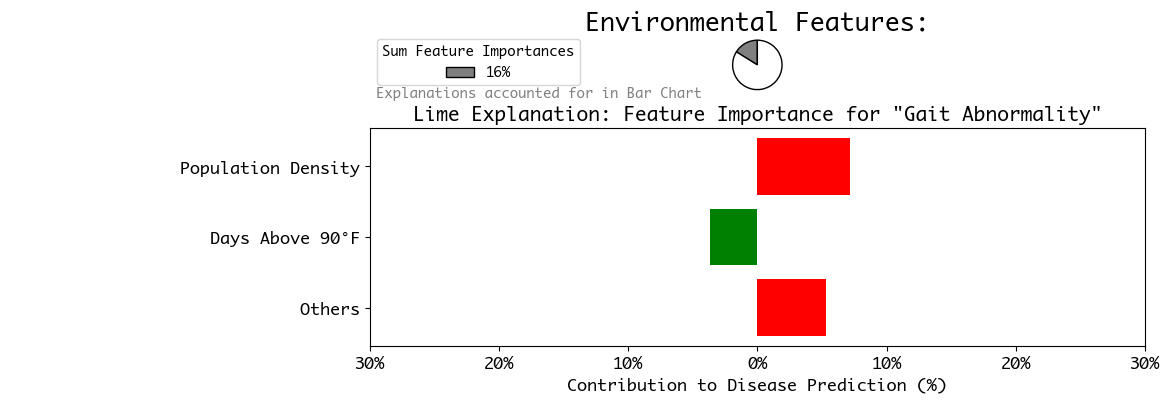

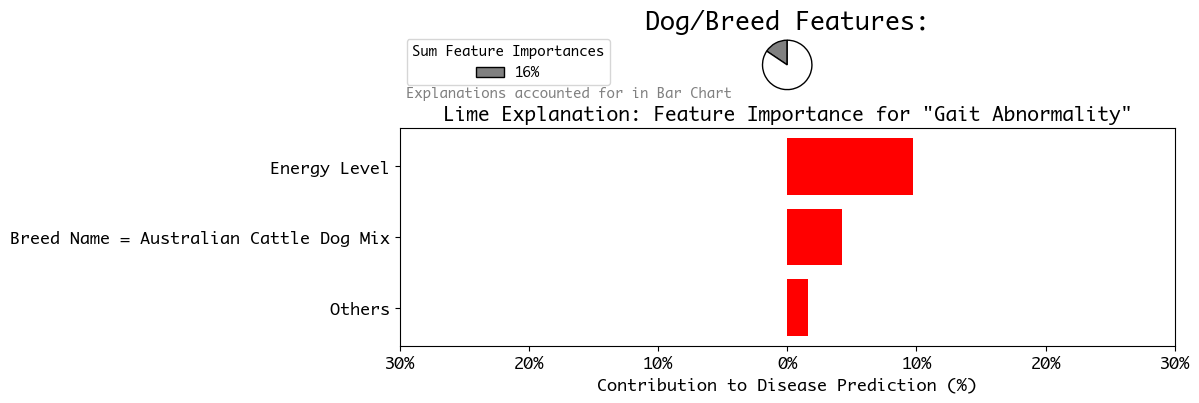

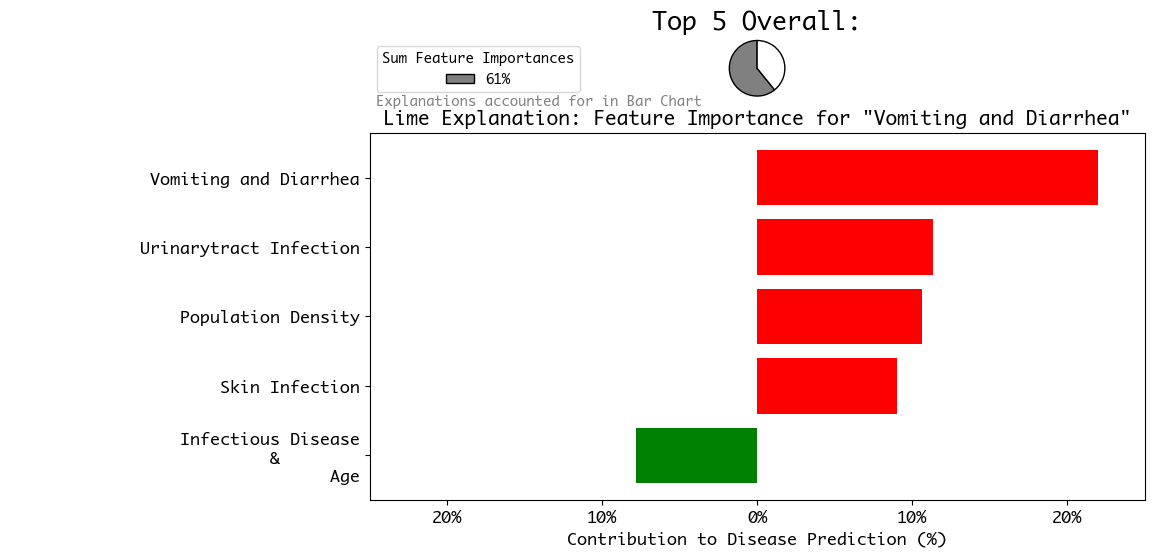

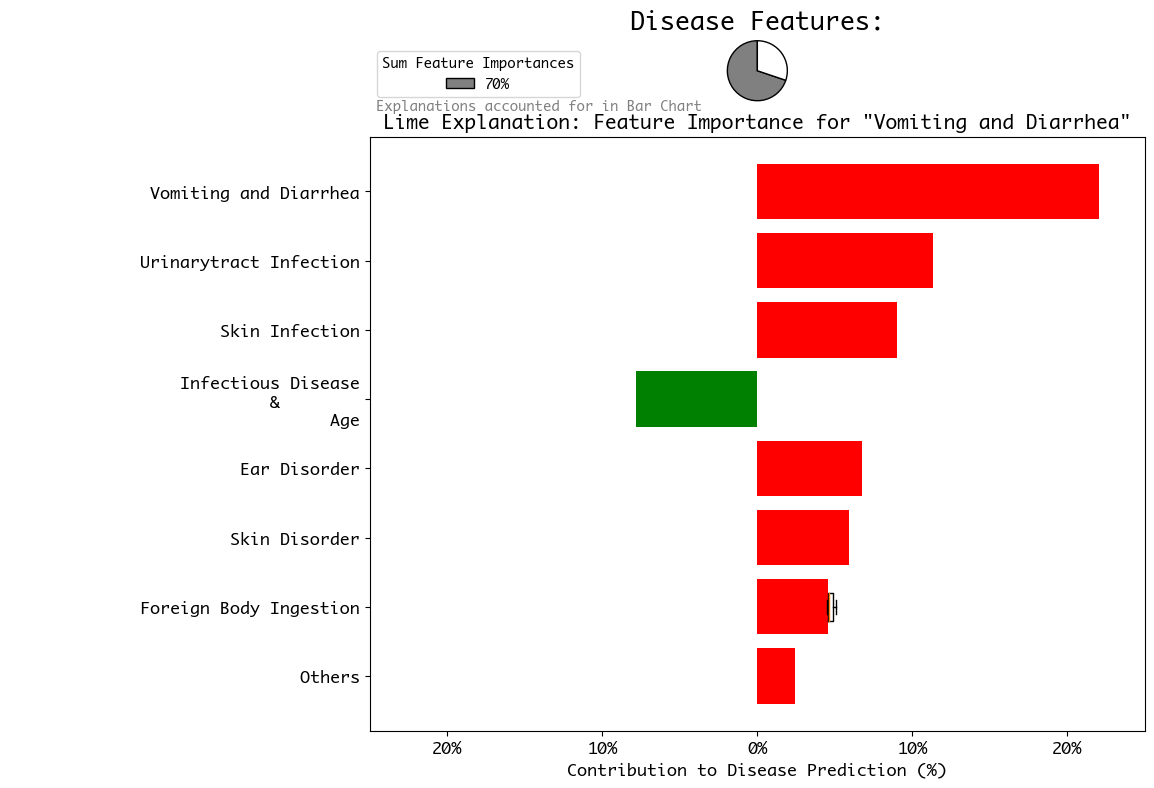

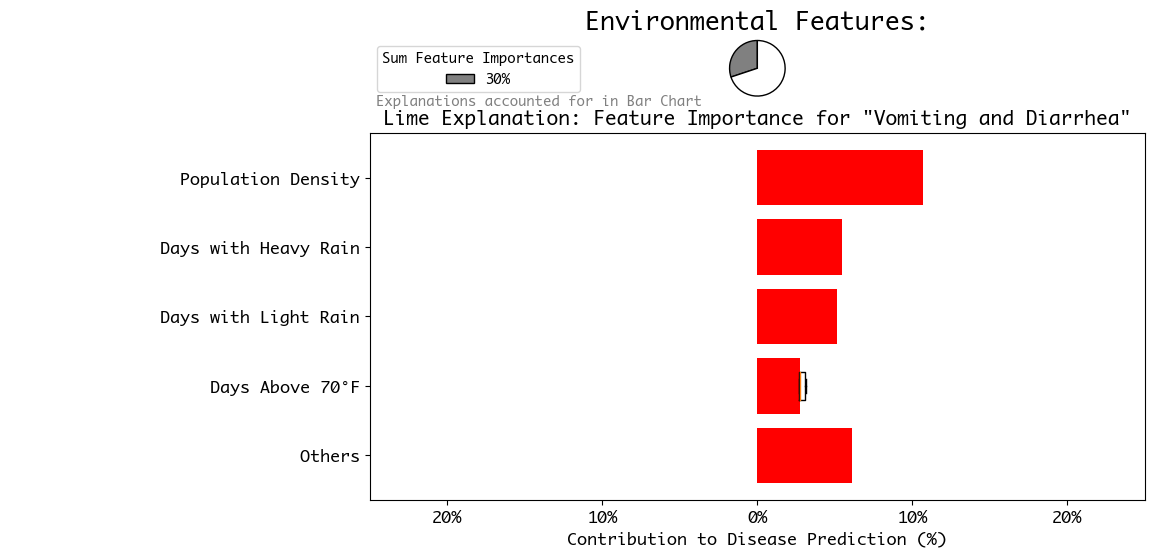

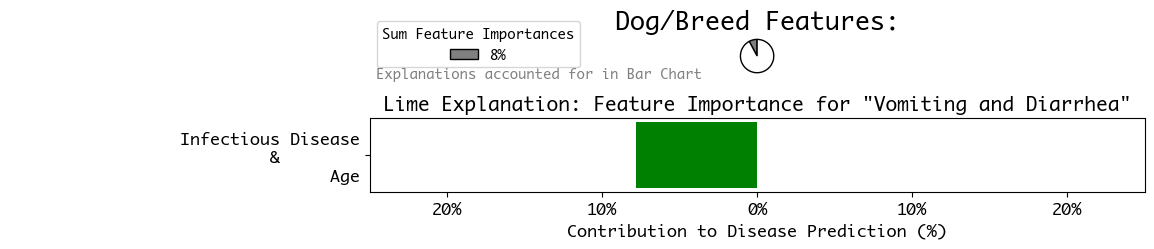

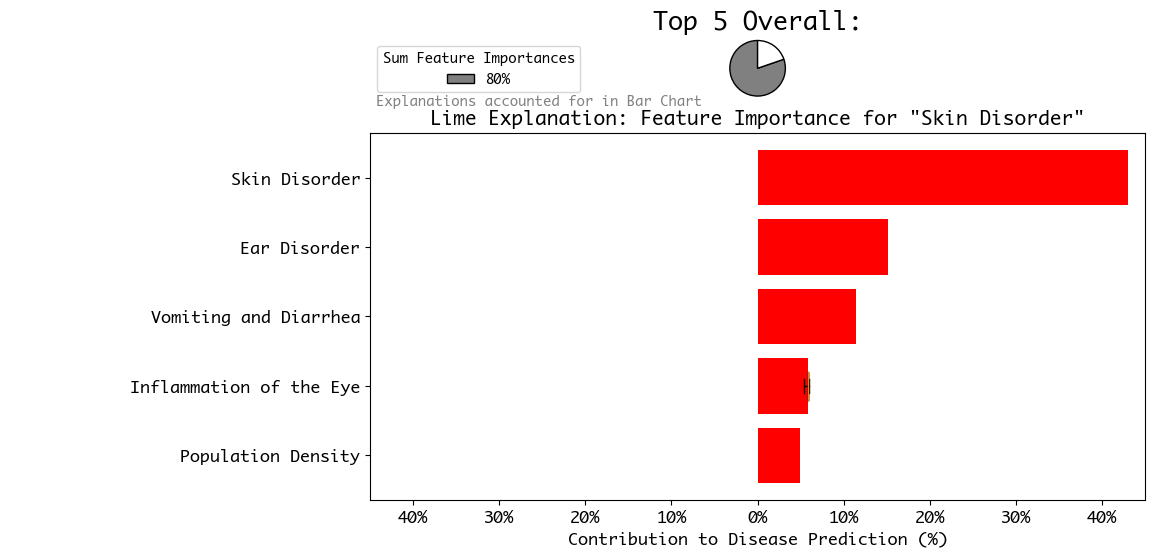

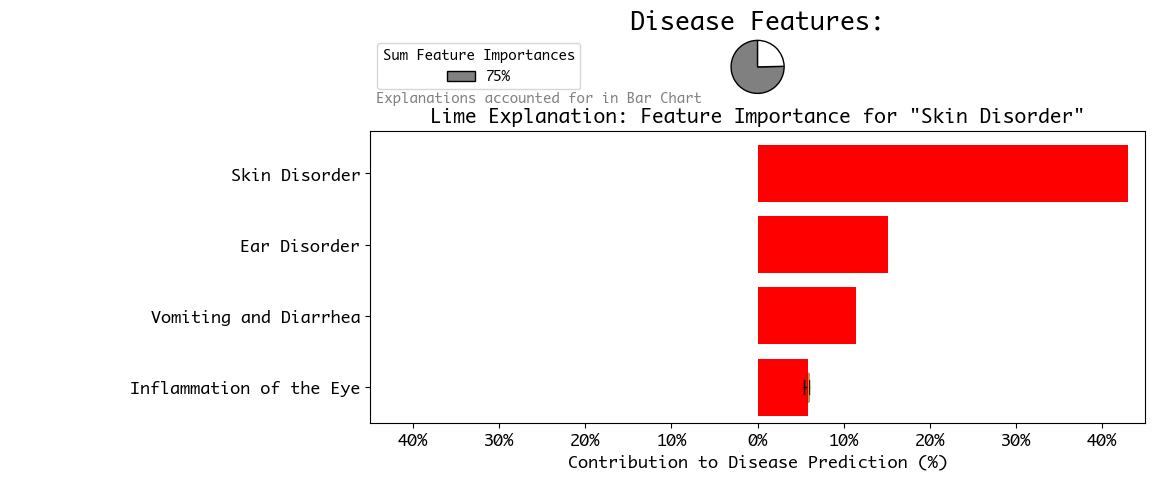

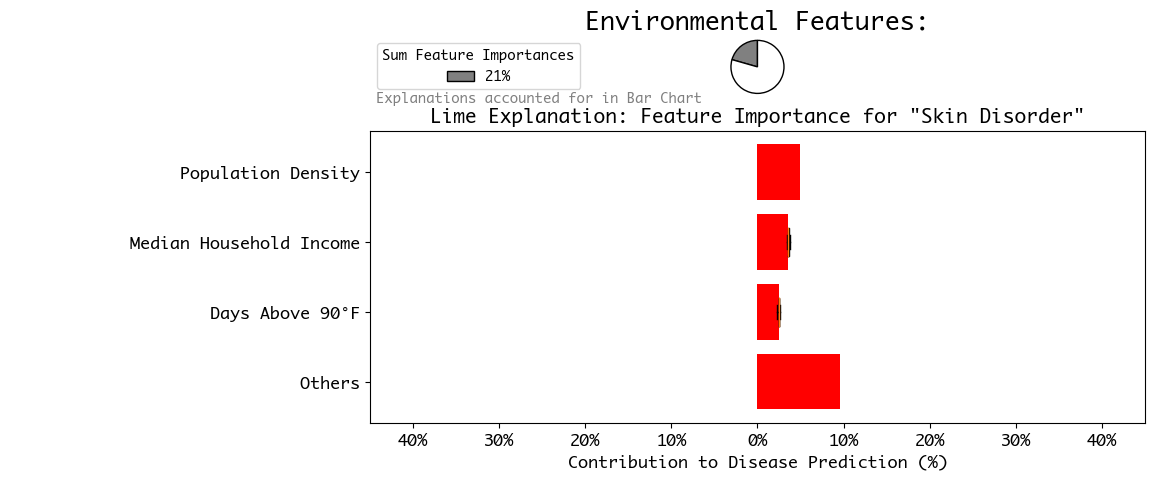

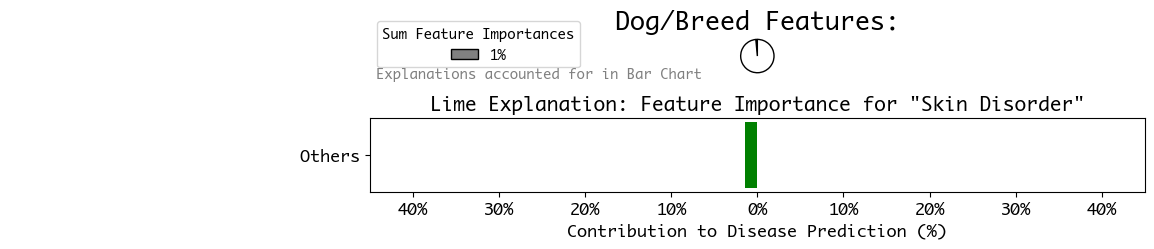

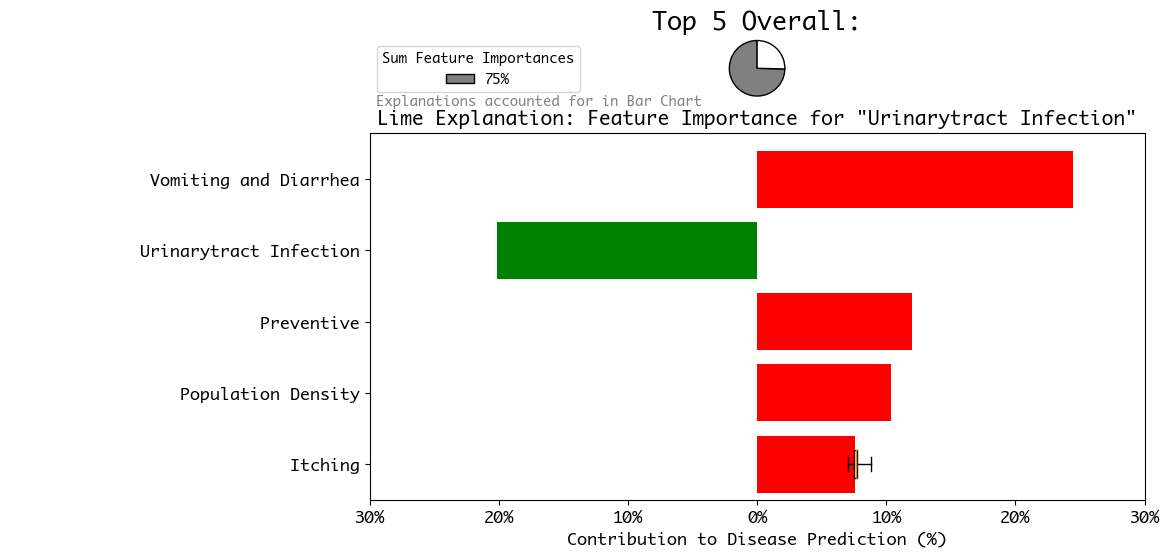

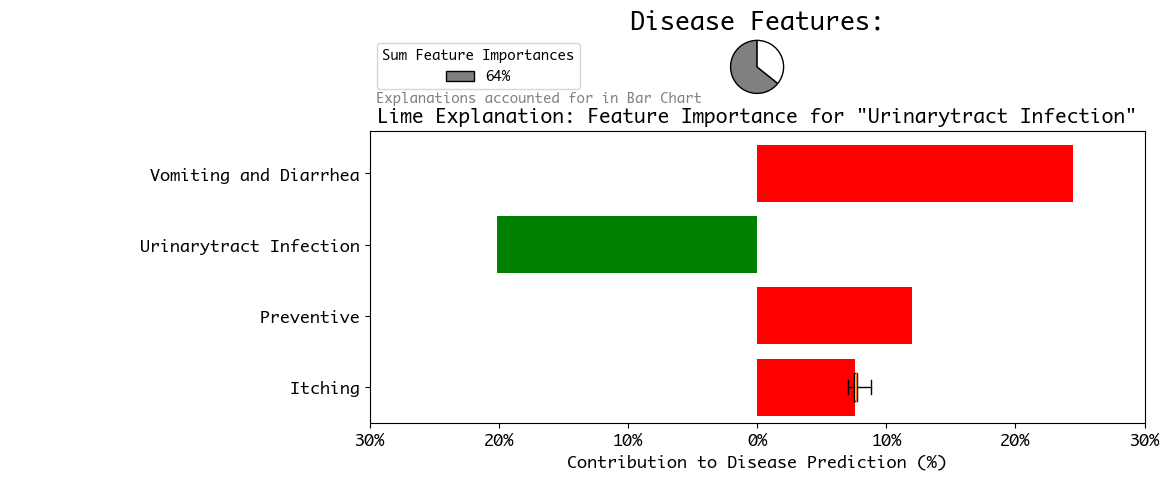

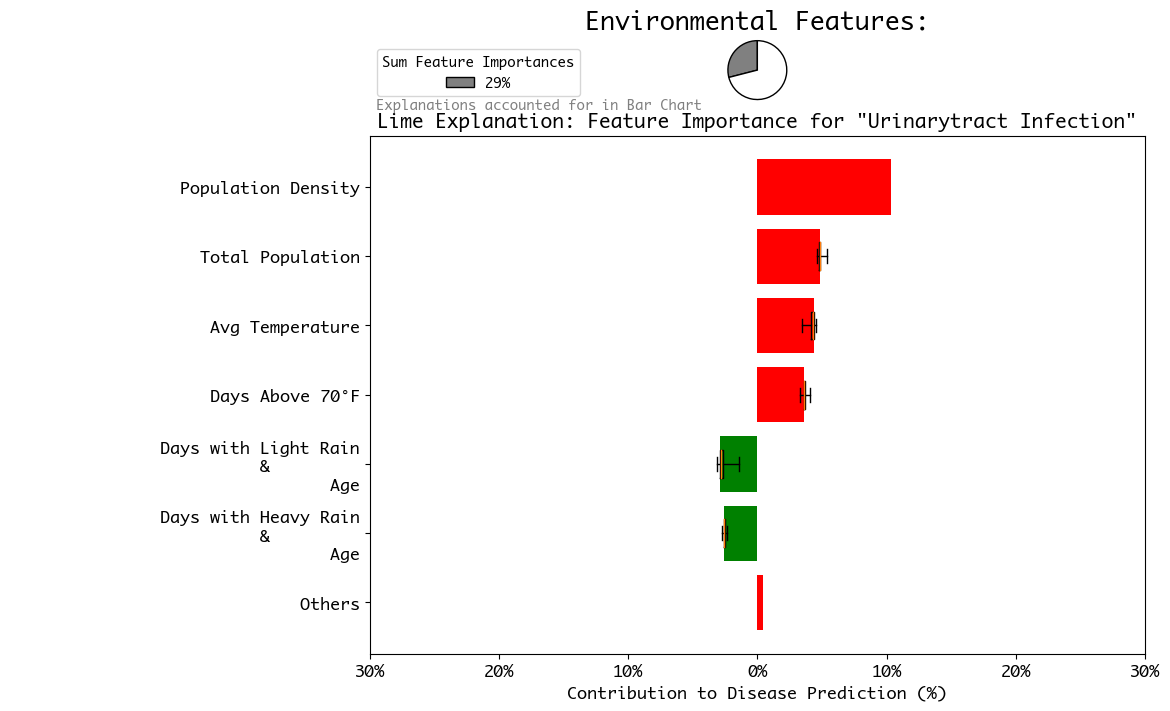

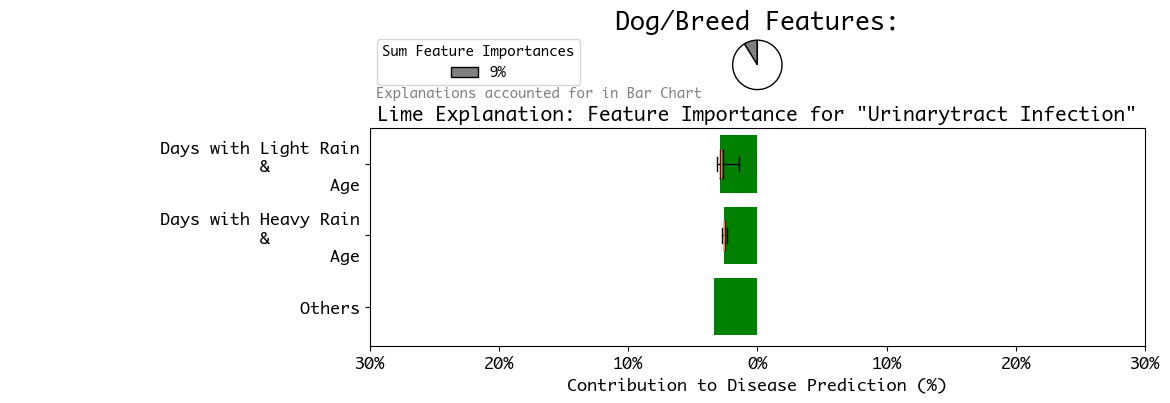

In [136]:
def plot_feature_importance(explanation, sample_dataframe, classifier_results):
    # Set up descendent structure from hierarchical Breed Tree
    node_to_descendants=load_and_process_tree()    
    # Create a local copy of classifier_results
    results = copy.deepcopy(classifier_results)
    for label in copy.deepcopy(classifier_results):
        label_feature_list = explanation.as_list(label=label)
        # Extract features and their respective scores for this label
        feature_list = [data[0] for data in label_feature_list]
        # add Bias as Feature to the Explanation
        # feature_list.append('Bias')
        # Extract Breed features that can be combined
        breed_features, feature_list = process_breed_tree(label, results, feature_list, node_to_descendants)
        # update results with accumulated Breed information
        process_breeds_in_results(label, breed_features, results)
        # Combine Binary Features with the same information like : Country=USA:True and Country=Canada:False 
        feature_list = update_results_if_required(feature_list, results, 'Country', label)
        feature_list = update_results_if_required(feature_list, results, 'Sheds', label)
        feature_list = update_results_if_required(feature_list, results, 'Gender', label)

        # remove features based on zero hypothesis
        features_to_be_removed = features_to_remove(results, label)
        # perform bootstrapping
        bootstrap_results, boxplot_modes = bootstrap_features(results, label)
        # sort features
        sorted_feature_names = sort_features_by_score(bootstrap_results, label)
        # Removing unwanted features from sorted_feature_names
        sorted_features = [feature for feature in sorted_feature_names if feature not in features_to_be_removed]   
        # filter the interaction features: only includes them if they are signigicant
        sorted_features, bootstrap_results = filter_interaction_features(sorted_features, bootstrap_results, label)
        boxplot_modes = [np.array(boxplot_modes[feature]) for feature in sorted_features if feature in boxplot_modes]
        # histogram of margins of error
        #visualize_margins_of_error(bootstrap_results, label)
        
        # Calculate total mean score
        total_mean_score = sum(abs(score[0]) for score in bootstrap_results[label].values())
        # Calculate each feature's mean score as a percentage of the total
        mean_scores_percentage = [(bootstrap_results[label][extract_feature_name(feature)][0] / total_mean_score) * 100 
                                  for feature in sorted_features]
        # Calculate the boxplot modes as percentages of the total mean score
        boxplot_modes_percentage = [(mode / total_mean_score) * 100 for mode in boxplot_modes]
        # Boxplot data: Each feature's scores as percentages of the total
        boxplot_data_percentage = [(results[label][extract_feature_name(feature)] / total_mean_score) * 100
                                   if extract_feature_name(feature) in results[label] else [0]
                                   for feature in sorted_features]
        # determine x-axis limits
        min_mean,max_mean=get_min_max(mean_scores_percentage)

        # generate different plots based on categorys for Lime explanation
        top_features, top_mean_scores, top_boxplot = delete_unequal(sorted_features, mean_scores_percentage, boxplot_modes_percentage)
        plot_lime_feature_importance(top_mean_scores[-5:], top_boxplot[-5:], 
                                    top_features[-5:], feature_names, label, min_mean, max_mean, top_title ='Top 5 Overall')
        disease_features,disease_mean_scores,disease_boxplot=find_features_in_category(disease_feature_names,mean_scores_percentage,boxplot_modes_percentage,sorted_features)
        plot_lime_feature_importance(disease_mean_scores, disease_boxplot, 
                                    disease_features, feature_names, label, min_mean, max_mean, top_title ='Disease Features', other_threshold=2.5)
        environment_features,environment_mean_scores,environment_boxplot=find_features_in_category(environment_feature_names,mean_scores_percentage,boxplot_modes_percentage,sorted_features)
        plot_lime_feature_importance(environment_mean_scores, environment_boxplot, 
                                    environment_features, feature_names, label, min_mean, max_mean, top_title ='Environmental Features',other_threshold=2.5)
        dog_features,dog_mean_scores,dog_boxplot=find_features_in_category(dog_feature_names,mean_scores_percentage,boxplot_modes_percentage,sorted_features)
        plot_lime_feature_importance(dog_mean_scores, dog_boxplot, 
                                    dog_features, feature_names, label, min_mean, max_mean, top_title ='Dog/Breed Features',other_threshold=2.5)

        ### visualizations without boxplots
#         top_features, top_mean_scores, top_boxplot = delete_unequal(sorted_features, mean_scores_percentage, boxplot_data_percentage)
#         plot_lime_feature_importance(top_mean_scores[-5:], top_boxplot[-5:], 
#                                     top_features[-5:], feature_names, label, min_mean, max_mean, top_title ='Top 5 Overall',include_boxplot=False)
#         environment_features,environment_mean_scores,environment_boxplot=find_features_in_category(environment_feature_names,mean_scores_percentage,boxplot_data_percentage,sorted_features)
#         plot_lime_feature_importance(disease_mean_scores, disease_boxplot, 
#                                     disease_features, feature_names, label, min_mean, max_mean, top_title ='Disease Features', other_threshold=2.5,include_boxplot=False)
#         disease_features,disease_mean_scores,disease_boxplot=find_features_in_category(disease_feature_names,mean_scores_percentage,boxplot_data_percentage,sorted_features)
#         plot_lime_feature_importance(environment_mean_scores, environment_boxplot, 
#                                     environment_features, feature_names, label, min_mean, max_mean, top_title ='Environmental Features',other_threshold=2.5,include_boxplot=False)
#         dog_features,dog_mean_scores,dog_boxplot=find_features_in_category(dog_feature_names,mean_scores_percentage,boxplot_data_percentage,sorted_features)
#         plot_lime_feature_importance(dog_mean_scores, dog_boxplot, 
#                                     dog_features, feature_names, label, min_mean, max_mean, top_title ='Dog/Breed Features',other_threshold=2.5,include_boxplot=False)
        

def run_explain_instance(num_runs, num_samples, sample):
    categorical_dict = {
        "breed_type": list(range(64, 73)),
        "sub_breed": list(range(78, 99)),
        "super_breed": list(range(110, 128)),
        "breed_name": list(range(128, 178)),
        "demeanor": list(range(99, 103)),
        "trainability": list(range(105, 110)),
        "sheds": list(range(103, 105)),
        "gender": list(range(73, 75)),
        "country": list(range(178, 180)),
        "area_type": list(range(75, 78)),
        "diseases": list(range(0, 50))}

    categorical_indices = []
    for key in categorical_dict:
        categorical_indices.extend(categorical_dict[key])
    selected_columns = sample.iloc[130:180]
    Breed_name_column=selected_columns.index[selected_columns==1].to_list() or None
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=x_train.iloc[:, 2:].values, 
        Breed_name=Breed_name_column,
        training_labels=y_train, 
        feature_names=feature_names, 
        categorical_features=categorical_indices, 
        mode="classification"
    )
    
    # count the values above 10% prediction probability 
    sample_df = pd.DataFrame(sample).transpose()
    prediction = my_classifier_run(sample_df.iloc[:,2:].values)
    top_labels_count = np.sum(prediction > 0.09)
    
    results = {}
    for current_run in range(num_runs):
        explanation = explainer.explain_instance(sample, 
                                        my_classifier_run, 
                                        num_samples=num_samples,
                                        feature_selection_threshold=0.05,
                                        balance=False,
                                        median=False,
                                        add_non_zero=False,
                                        add_disease=False,
                                        remove_breed=False,
                                        non_zero_selection=False,
                                        top_labels=top_labels_count)
        residuals = {label: abs((explanation.local_pred[label]) - explanation.predict_proba[label]) 
                     for label in explanation.top_labels}
        # Compute the weight for each label's explanation
        epsilon = 1e-2
        weights = {label: explanation.score[label].item() / residuals[label].item() + epsilon
                       for label in explanation.top_labels}
        
        for label in explanation.top_labels:
#             print('Label:',label,'local_pred:',explanation.local_pred[label])
#             print()
#             print('Label:',label,'sum_coefficents:',explanation.intercept[label]+sum(importance for _, importance in explanation.local_exp[label]))
#             print()
            #generates the feature names for single and interaction features
            used_feature_names = get_feature_names_from_explanation(explainer, explanation, label)
            # Initialize dictionaries to store results for this label
            if label not in results:
                results[label] = {}
                results[label]['importance_weights'] = []
                # results[label]['Bias'] = []
            # Check for each feature in used_feature_names whether it's present for the label in results
            for feature in used_feature_names:
                if feature not in results[label]:
                    results[label][feature] = [np.nan] * current_run
            results[label]['importance_weights'].append(weights[label])
            # dictionary to store importances for the current loop
            current_importances = {}
            # Calculate the total absolute importance for this explanation this makes each round of explanations normalized for all of the other rounds of explanations
            total_abs_importance = sum(abs(importance) for _, importance in explanation.local_exp[label]) + abs(explanation.intercept[label])
            # calculate the influence of Bias seperatly
            # results[label]['Bias'].append(explanation.intercept[label]/total_abs_importance)
            # Calculate importances and store them in the dictionary
            for i, (_, raw_importance) in enumerate(explanation.local_exp[label]):
                # Store the normalized importance score
                normalized_importance = raw_importance / total_abs_importance
                # Store the normalized importance score
                current_importances[used_feature_names[i]] = normalized_importance
            # for each feature in results[label] append either the calculated importance or np.nan
            for feature in results[label]:
                if feature in ['importance_weights', 'Bias']:
                    continue
                results[label][feature].append(current_importances.get(feature, np.nan))
    return results, explanation

num_runs = 2500
num_samples=10000
pet_number=3889
sample = x_train.iloc[pet_number]

#results, explanation = run_explain_instance(num_runs, num_samples, sample)
lime_folder_path=save_results_in_folder(x_train,'x_train',pet_number, num_runs, num_samples)
sample_df = pd.DataFrame(sample).transpose()
plot_top_10_dieases(sample_df)
plot_feature_importance(explanation,sample_df,results)

In [28]:
import pickle

# Save to file
#with open('/Users/marvinseiferling/XAI/Lime_plots/results.pkl', 'wb') as f:
#    pickle.dump(results, f)
#with open('/Users/marvinseiferling/XAI/Lime_plots/explanation.pkl', 'wb') as f:
#    pickle.dump(explanation, f)

# Load from file
with open('/Users/marvinseiferling/XAI/Lime_plots/results.pkl', 'rb') as f:
    results_pickle = pickle.load(f)
with open('/Users/marvinseiferling/XAI/Lime_plots/explanation.pkl', 'rb') as f:
    explanation_pickle = pickle.load(f)

/Users/marvinseiferling/PycharmProjects/LIME/lime/lime/lime_tabular.py:482: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""
/Users/marvinseiferling/PycharmProjects/LIME/lime/lime/lime_tabular.py:482: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""
/Users/marvinseiferling/PycharmProjects/LIME/lime/lime/lime_tabular.py:482: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not con

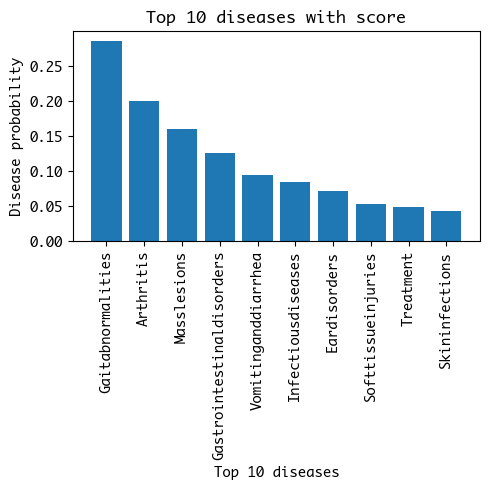

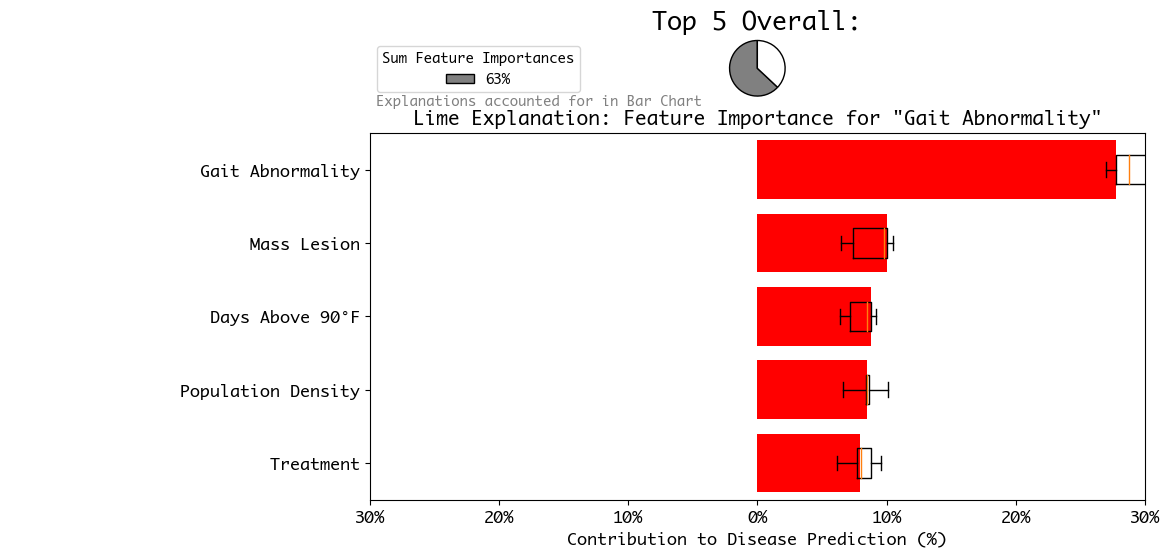

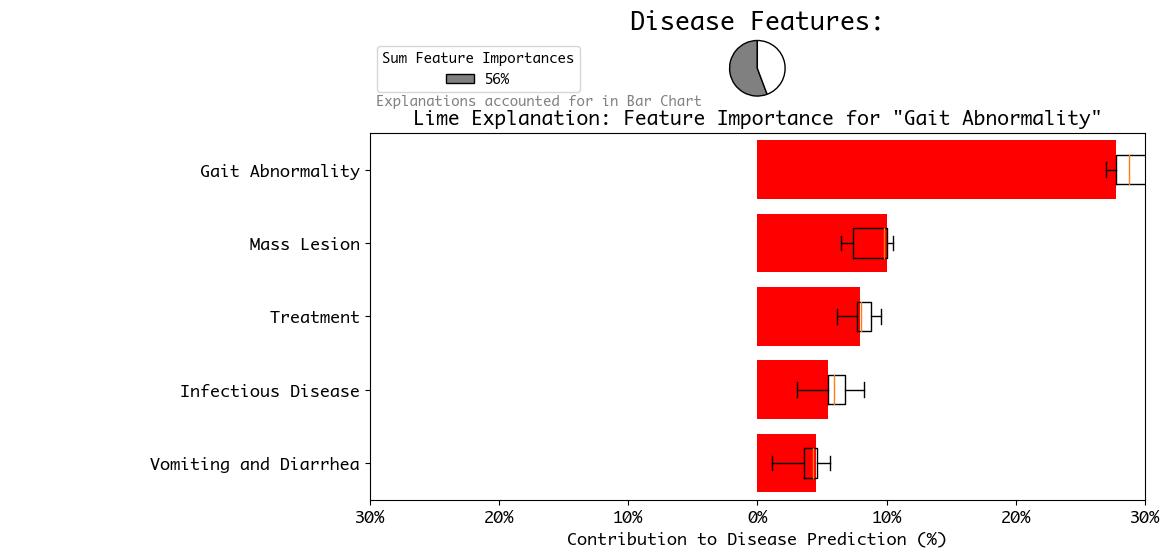

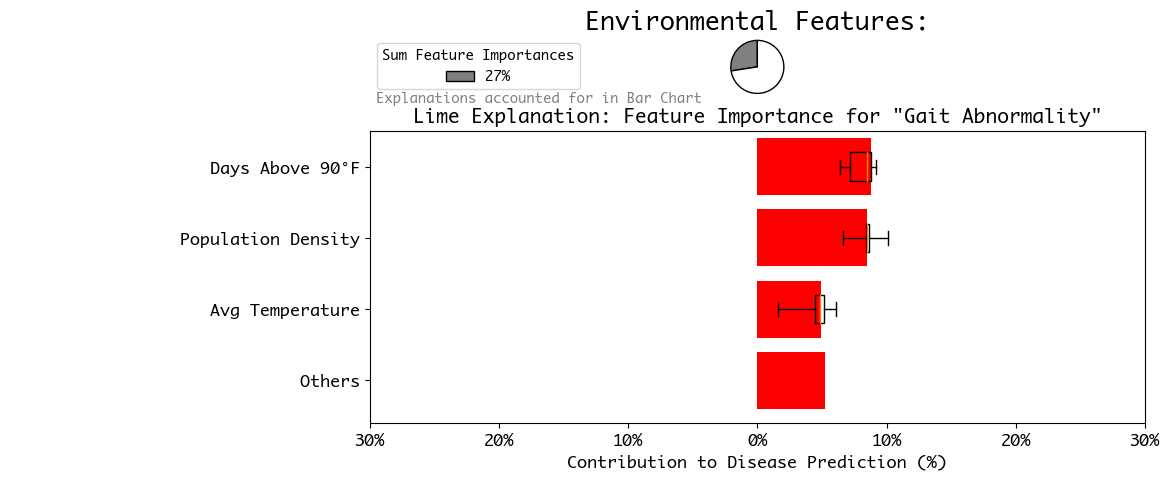

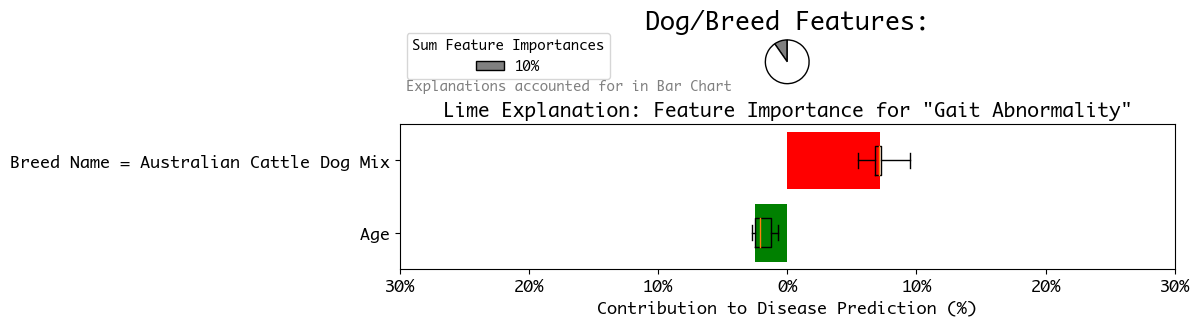

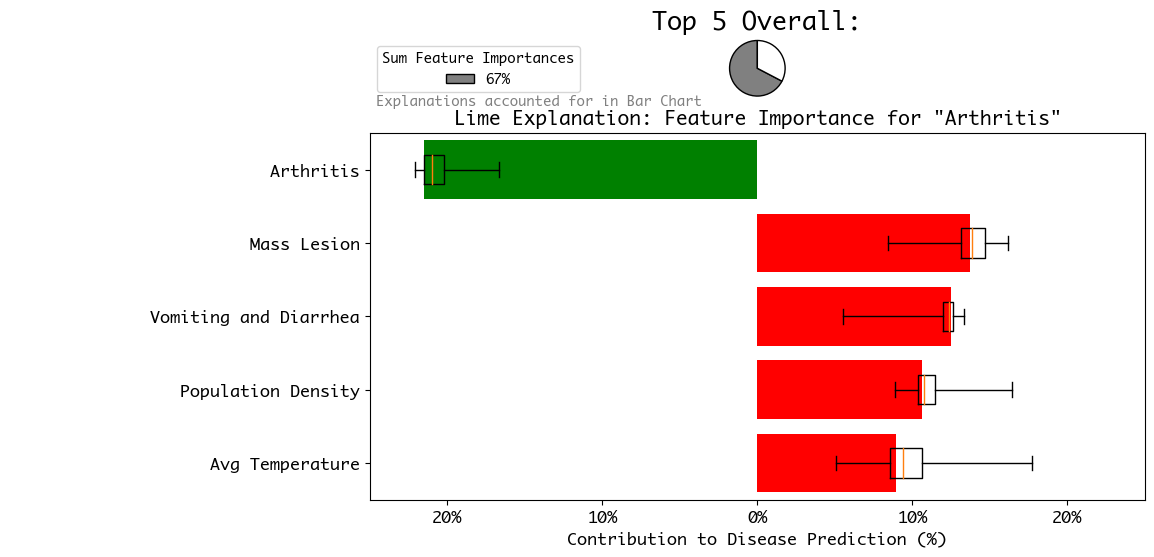

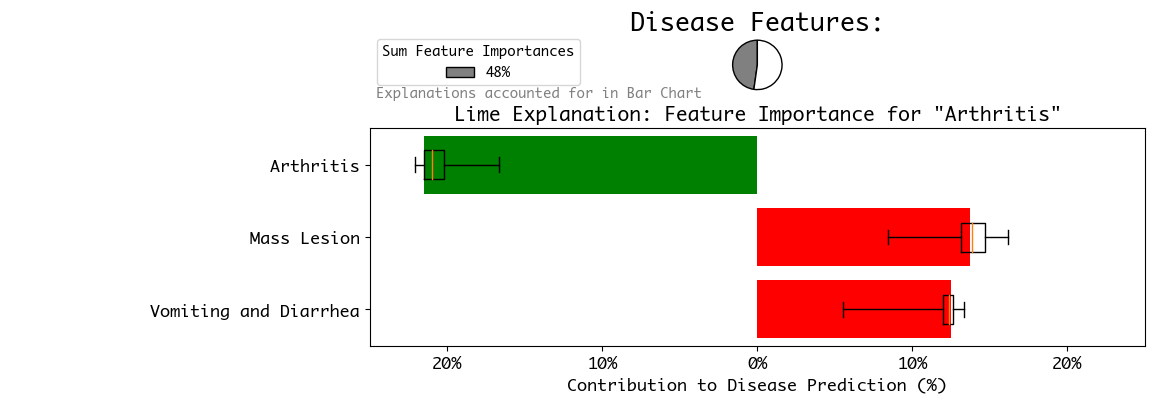

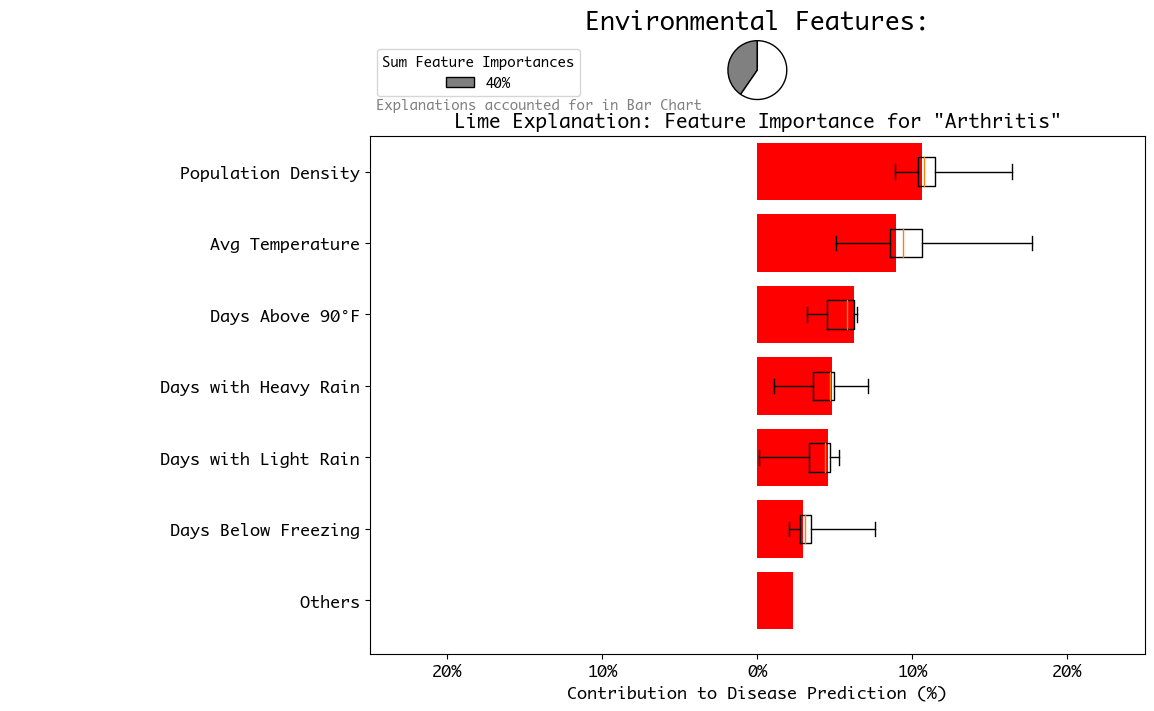

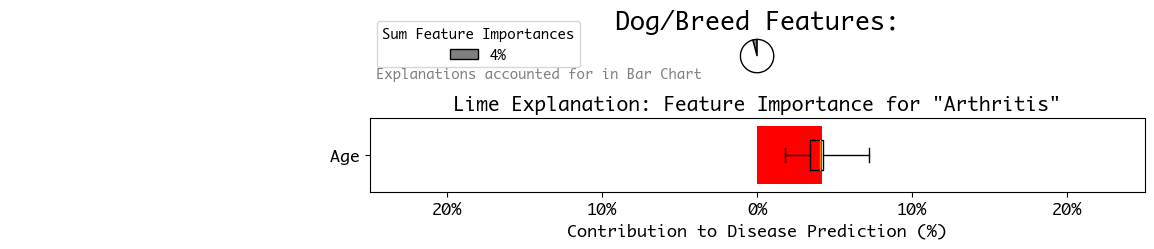

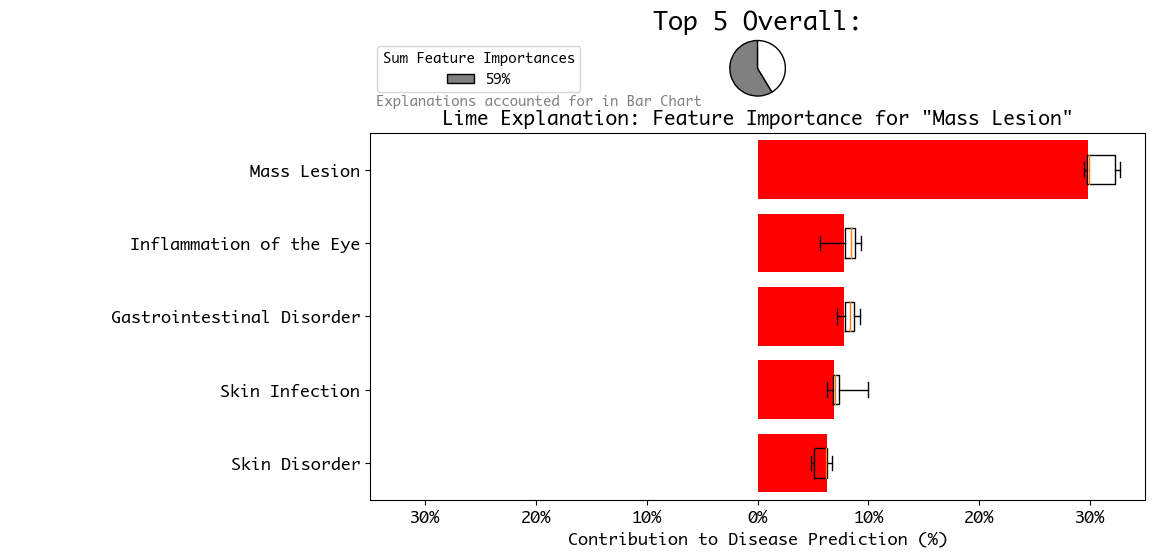

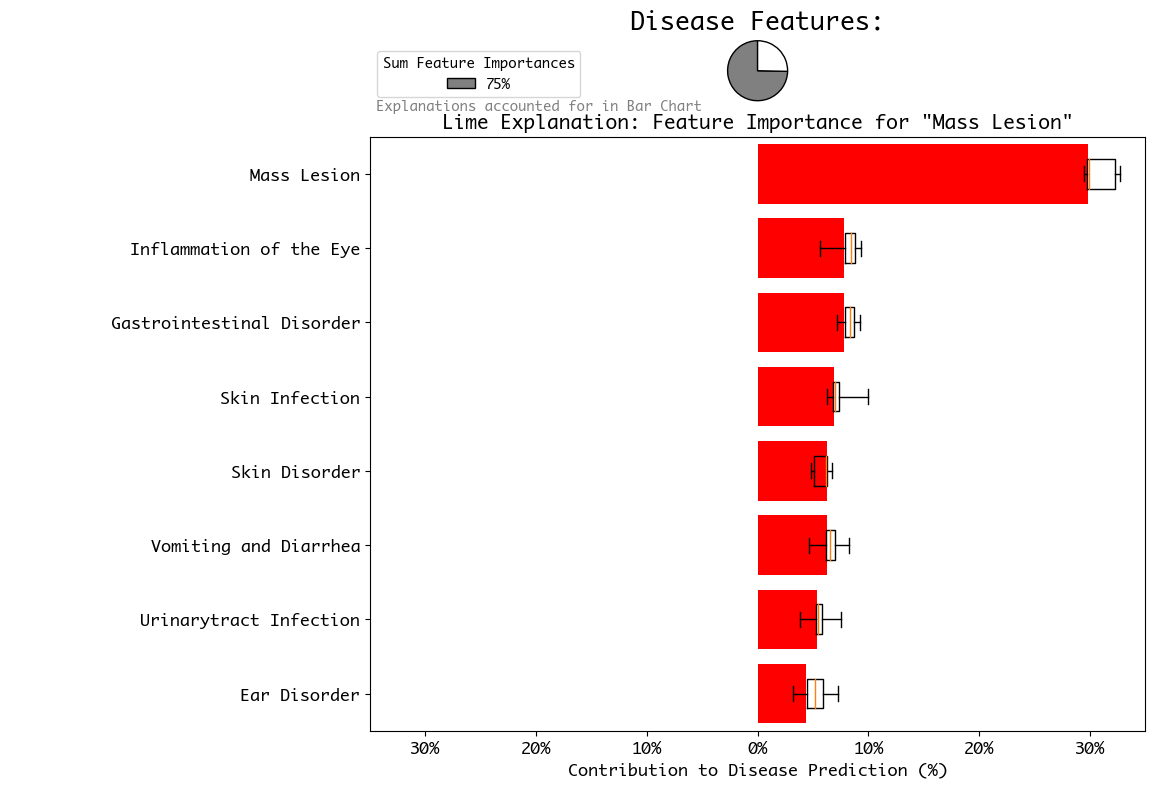

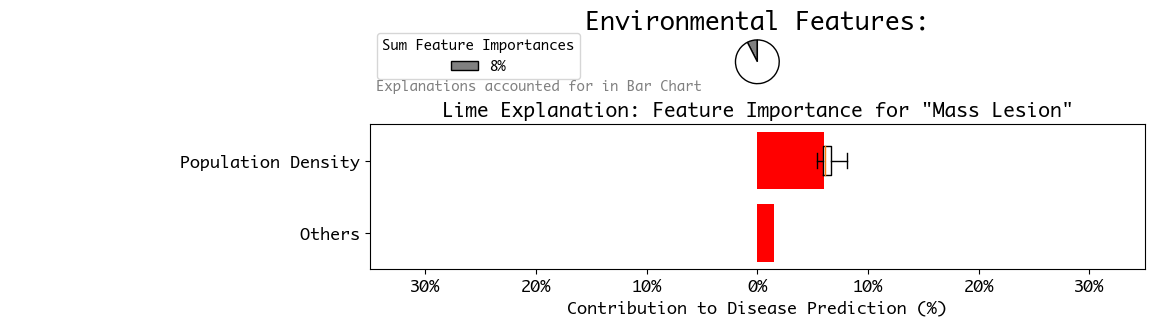

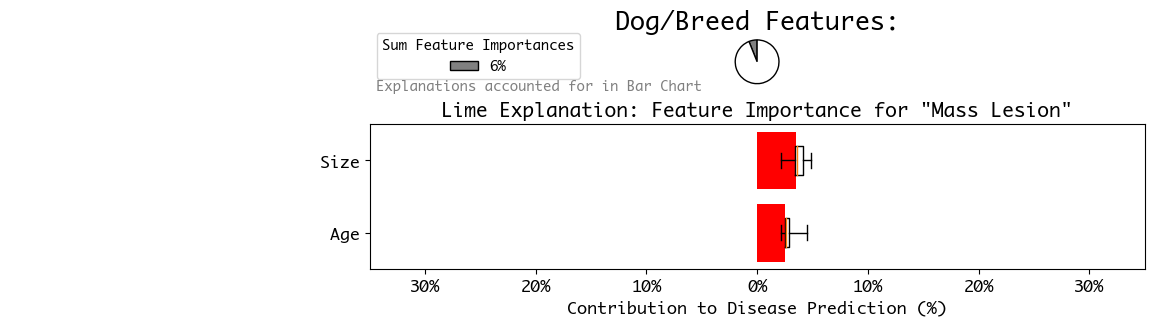

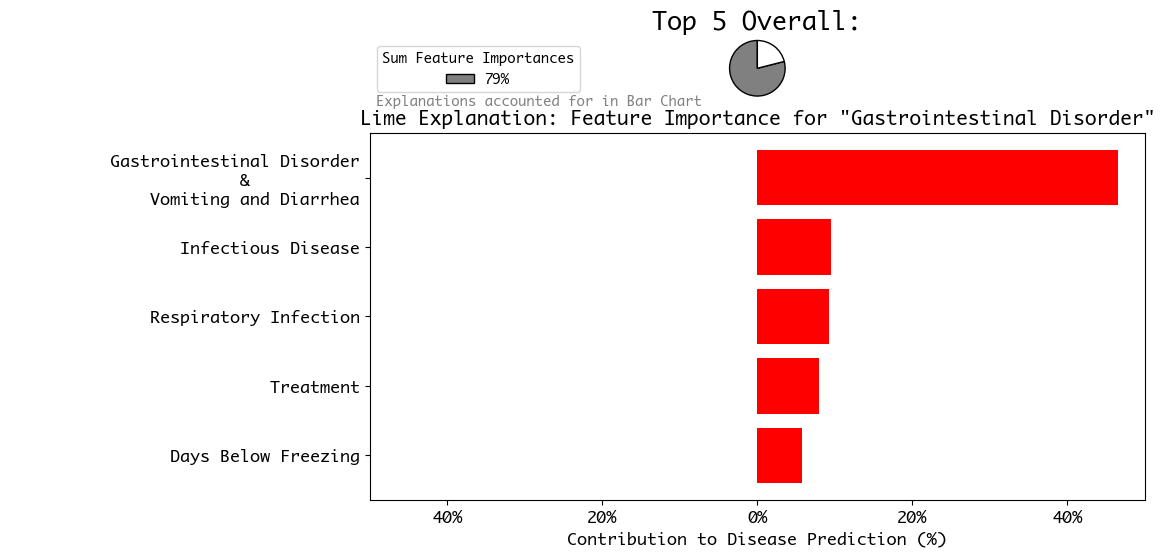

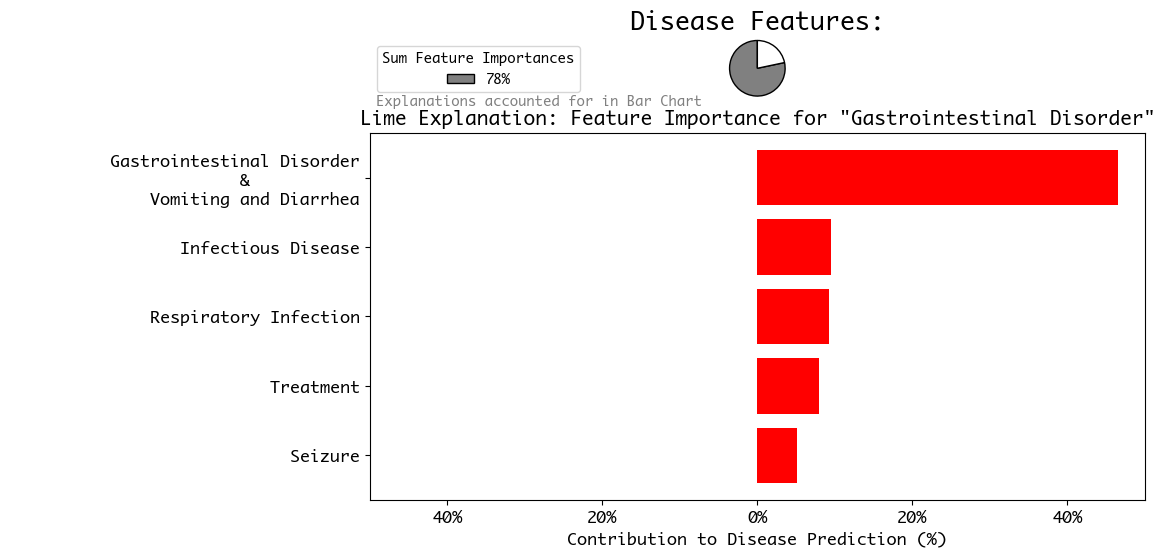

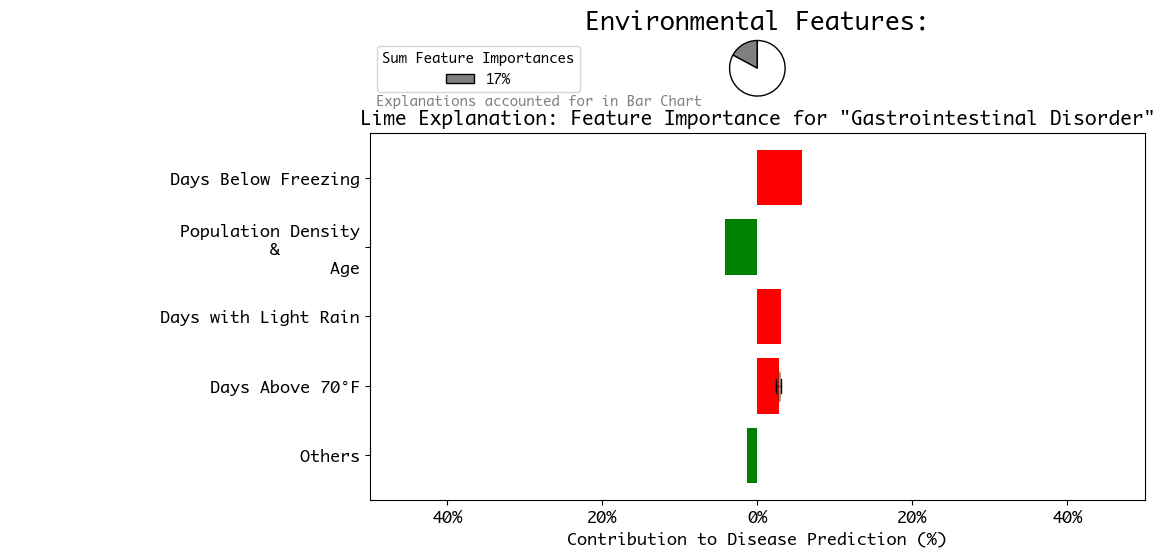

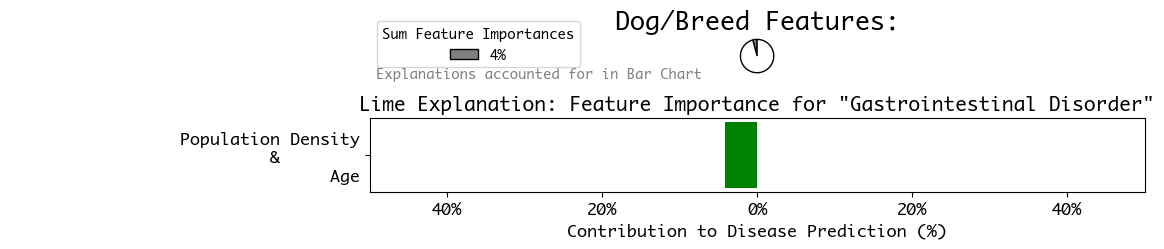

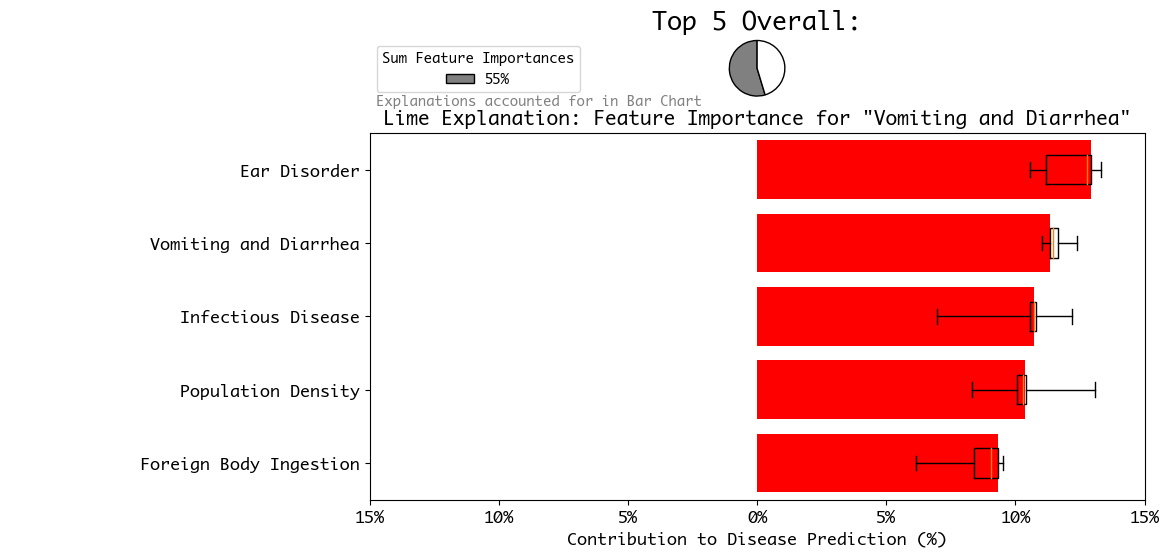

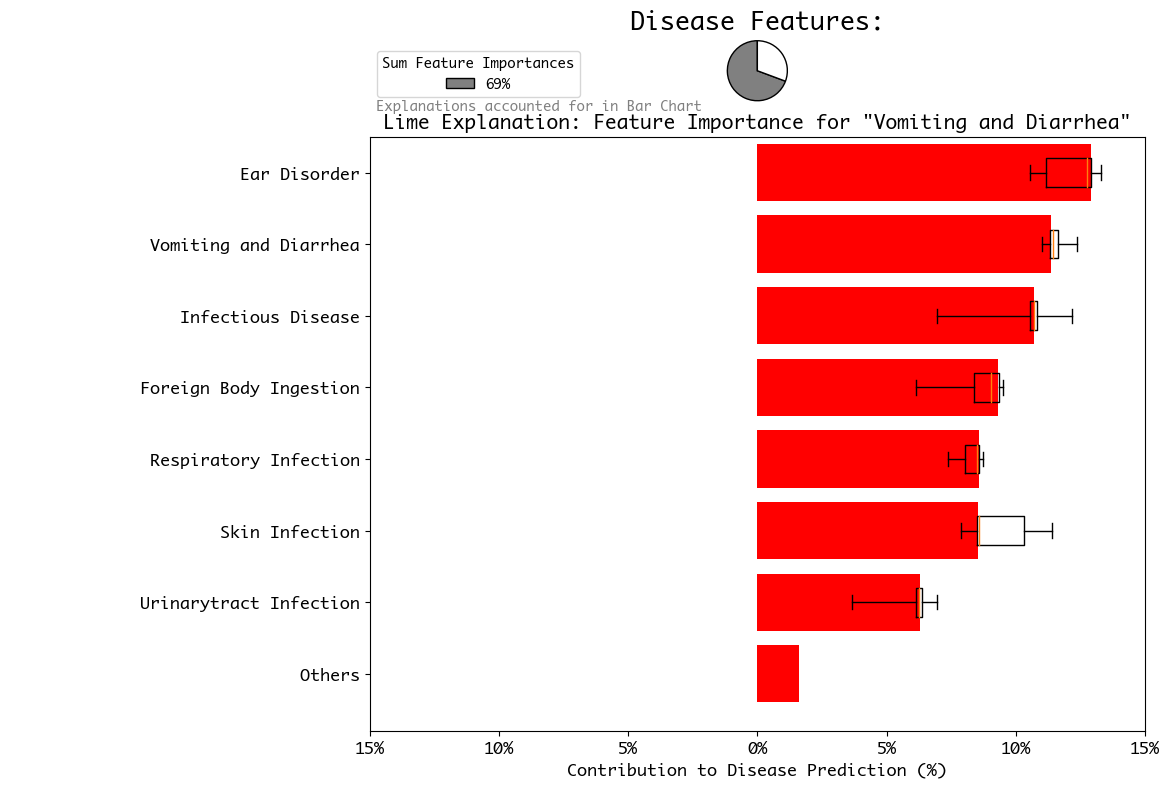

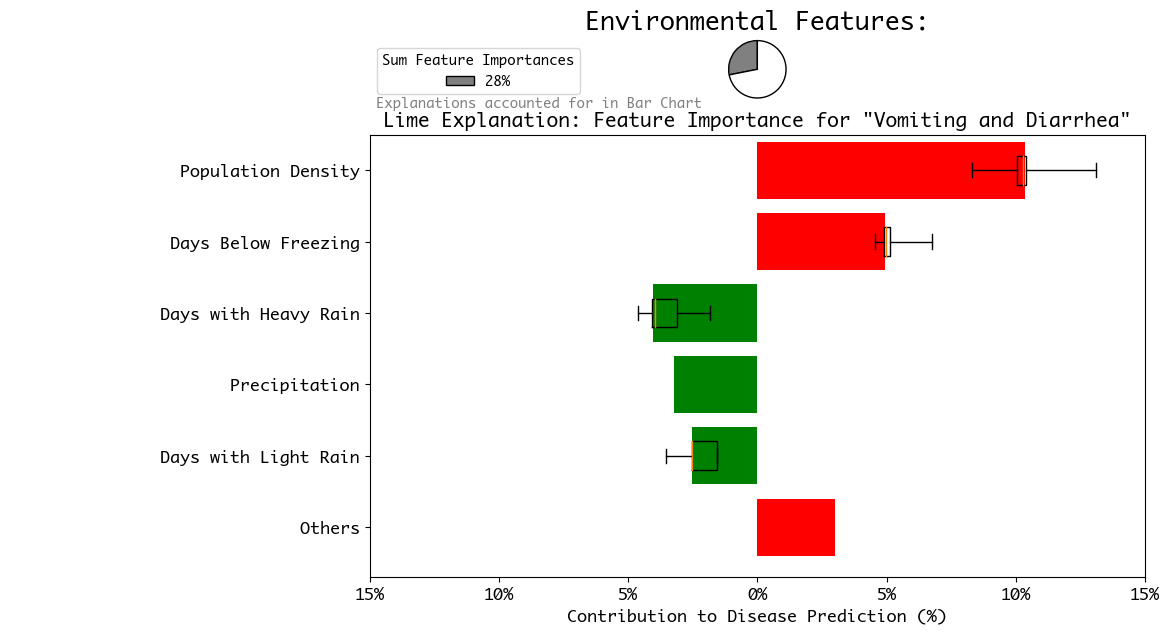

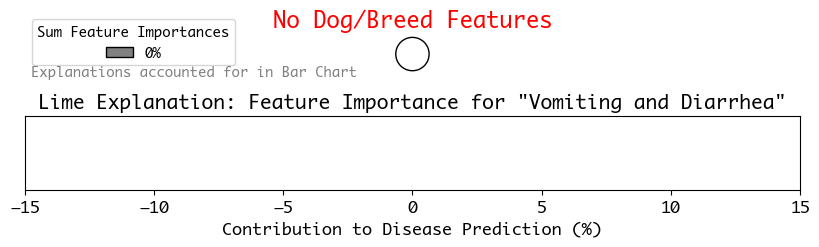

In [139]:
num_runs_x = 10
num_samples_x=1000
pet_number_x=9563
sample_x = x_train.iloc[pet_number_x]

results_x, explanation_x = run_explain_instance(num_runs_x, num_samples_x, sample_x)
lime_folder_path=save_results_in_folder(x_train,'x_train',pet_number_x, num_runs_x, num_samples_x)
sample_df_x = pd.DataFrame(sample_x).transpose()
plot_top_10_dieases(sample_df_x)
plot_feature_importance(explanation_x,sample_df_x,results_x)

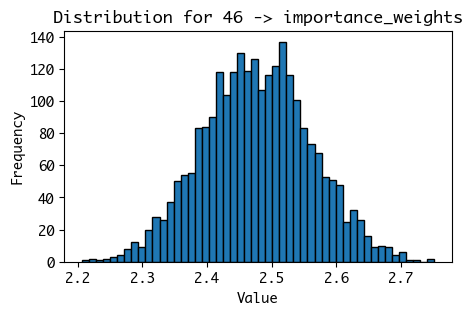

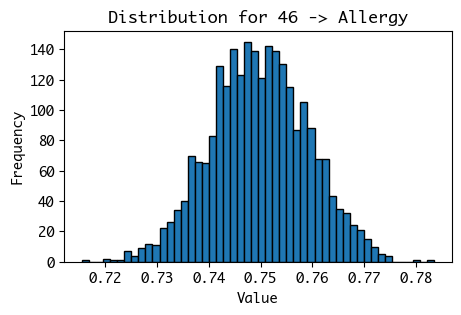

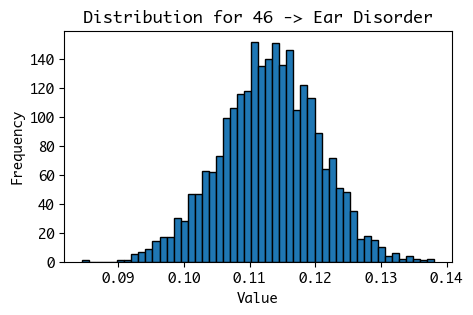

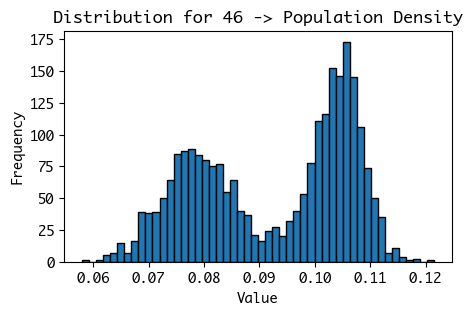

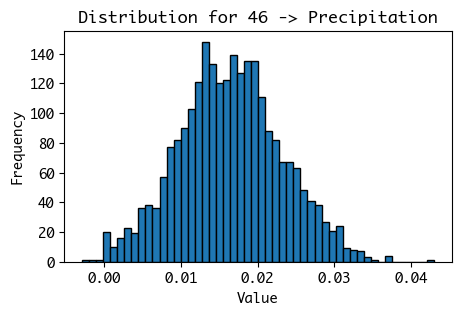

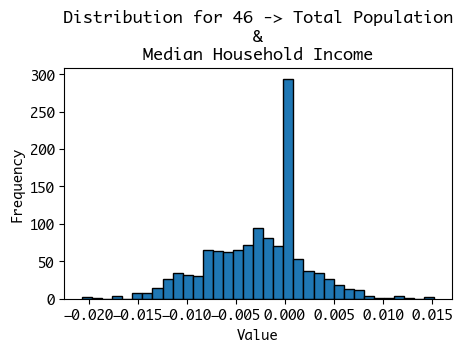

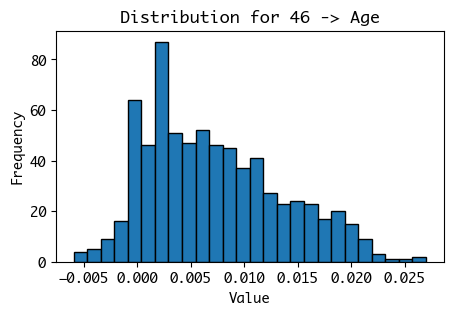

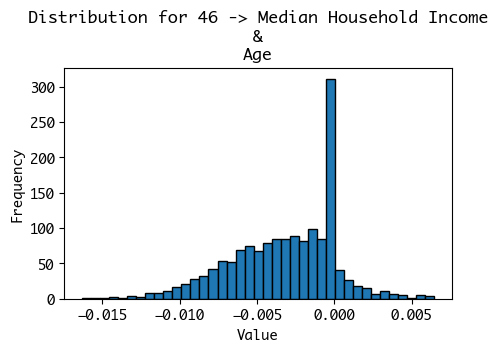

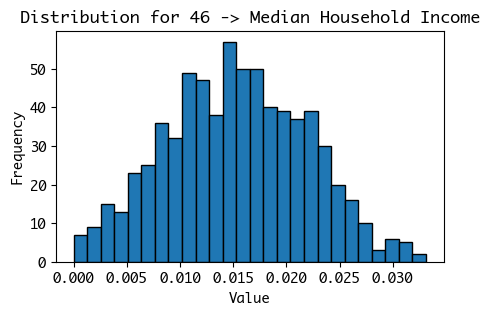

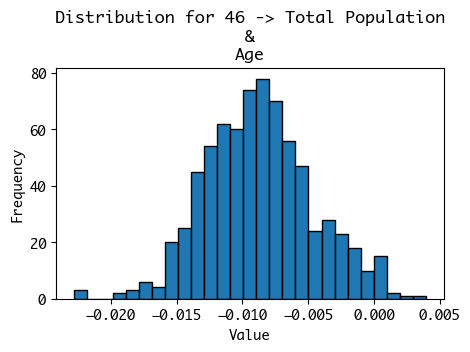

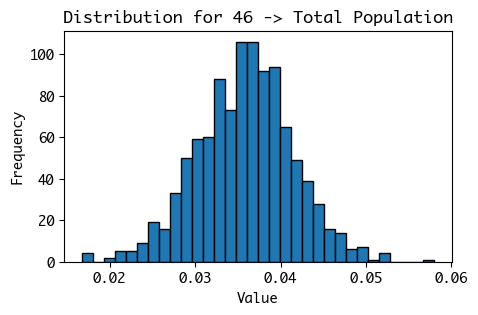

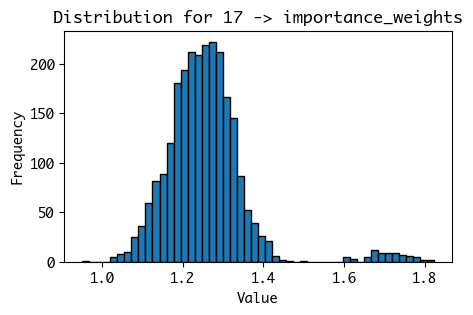

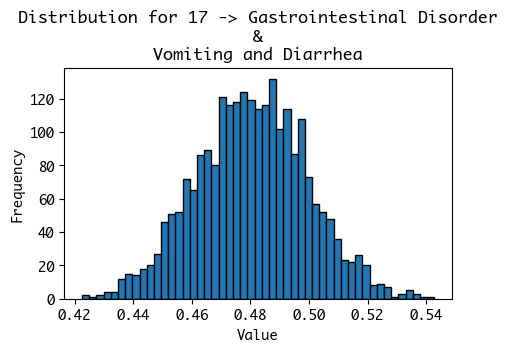

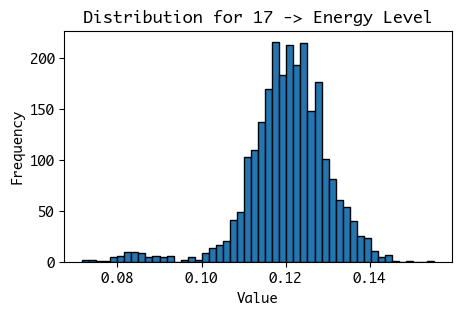

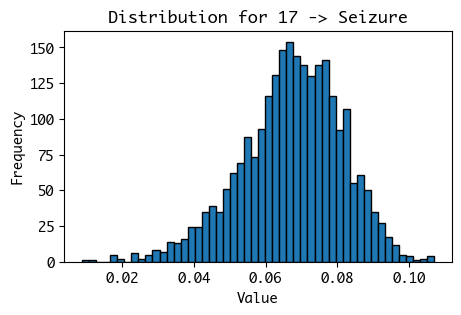

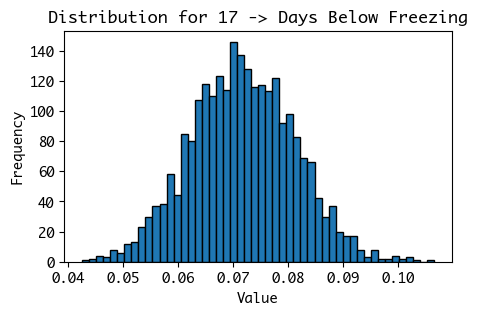

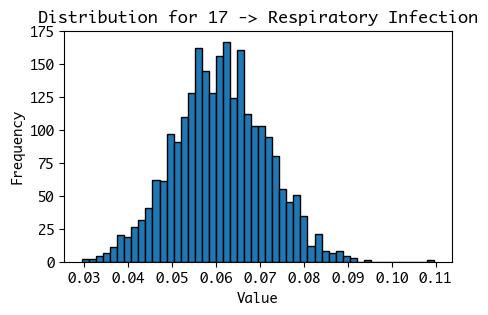

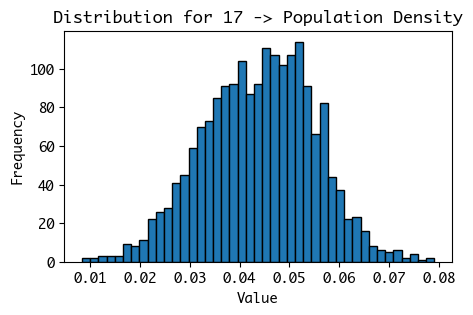

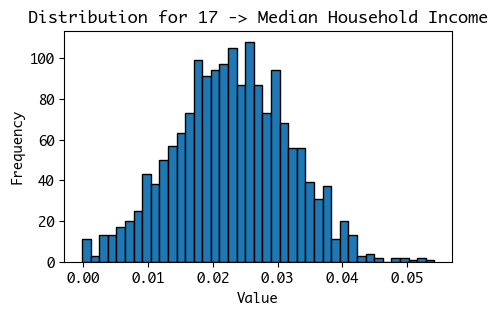

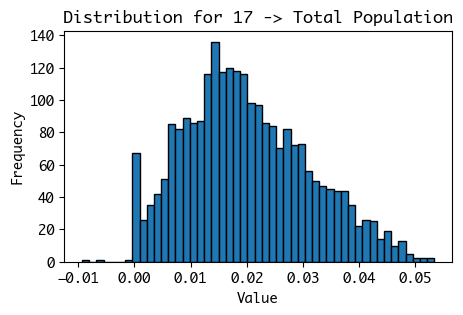

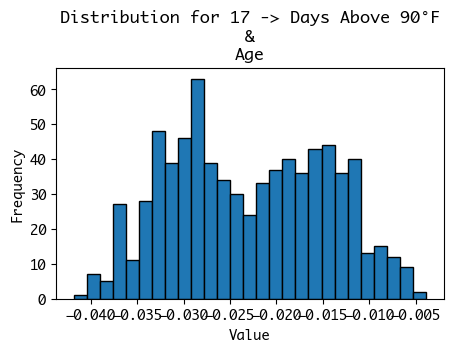

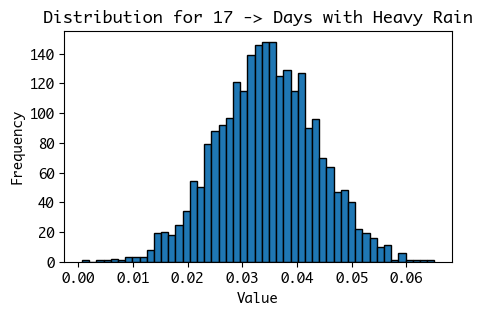

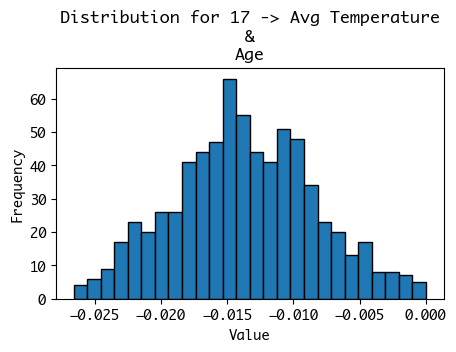

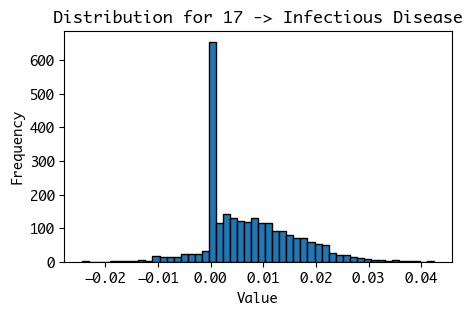

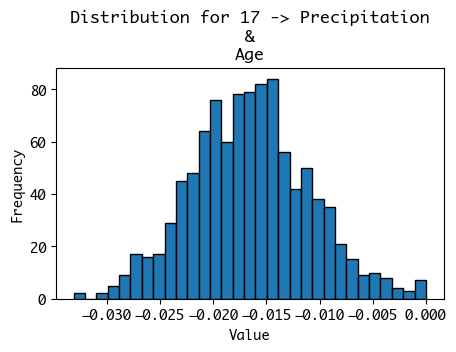

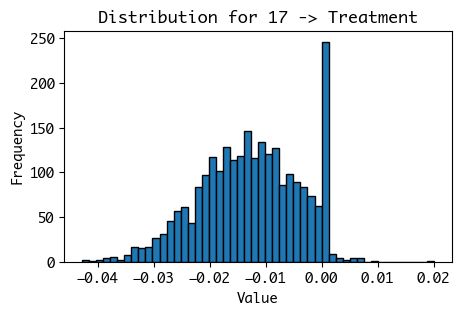

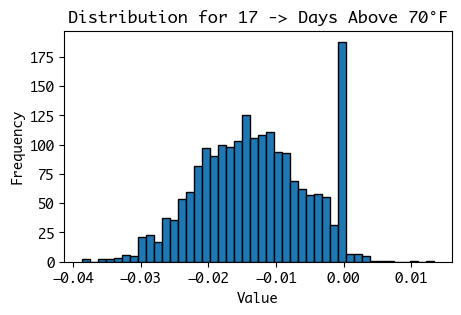

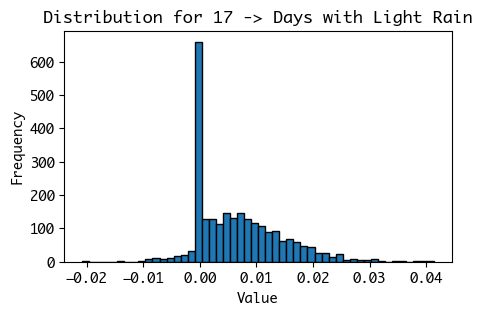

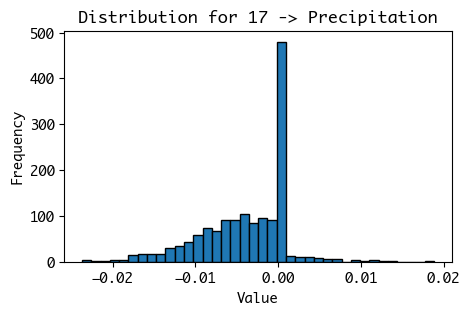

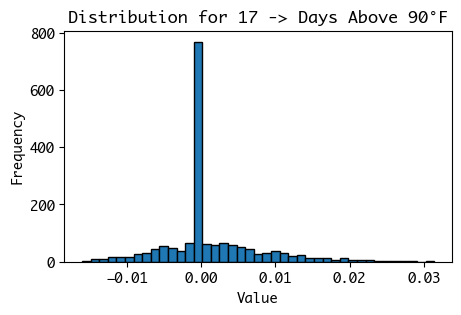

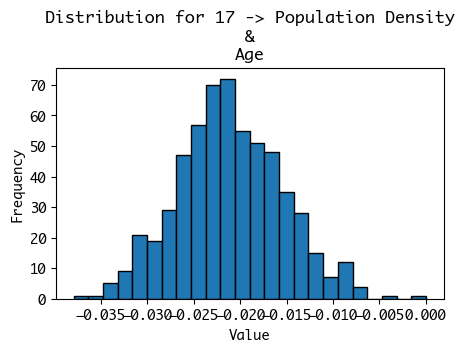

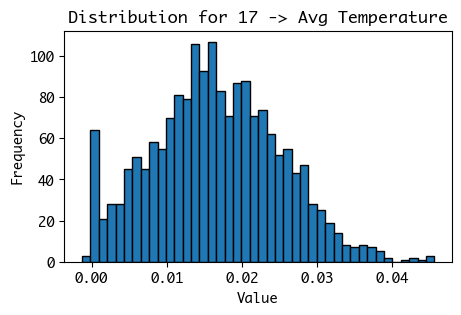

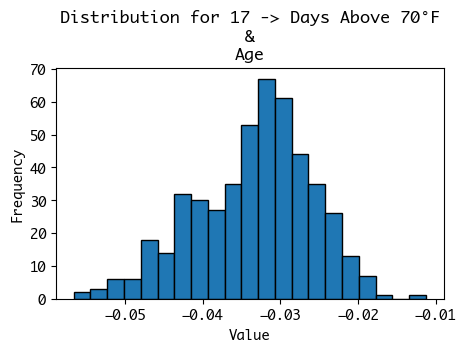

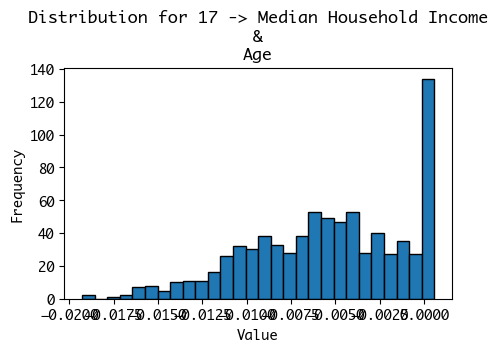

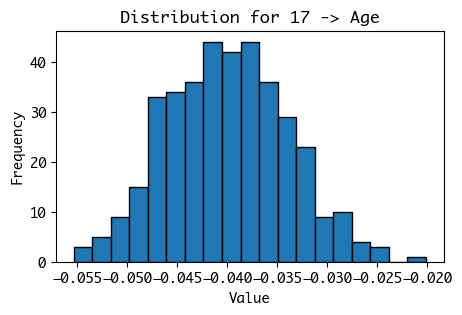

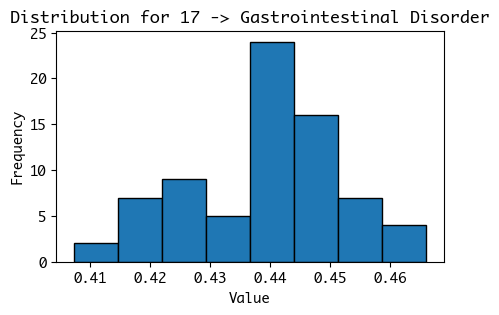

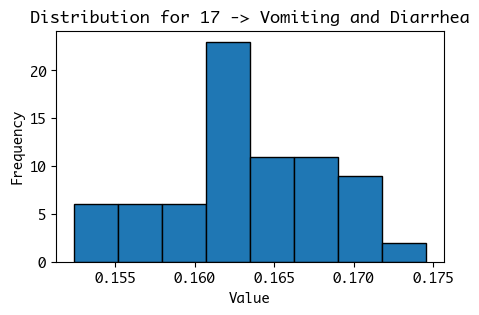

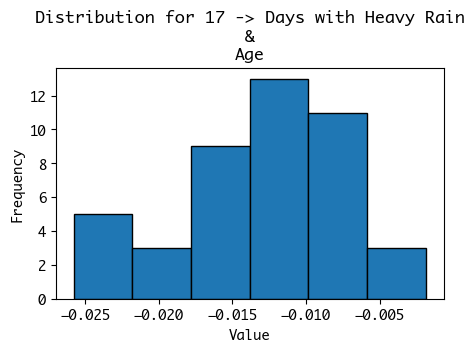

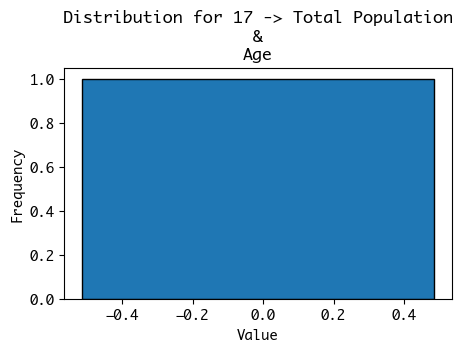

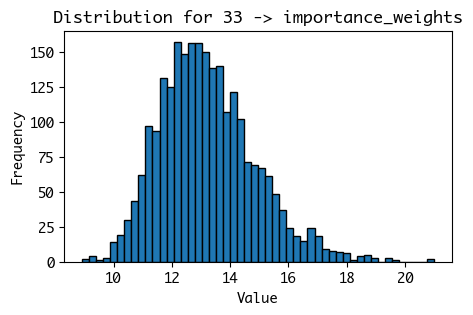

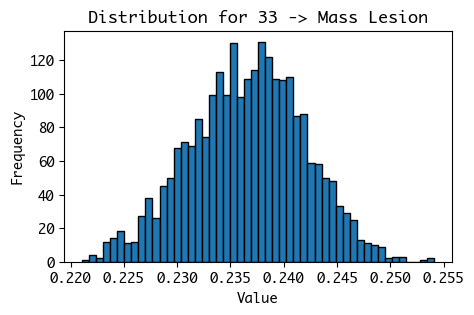

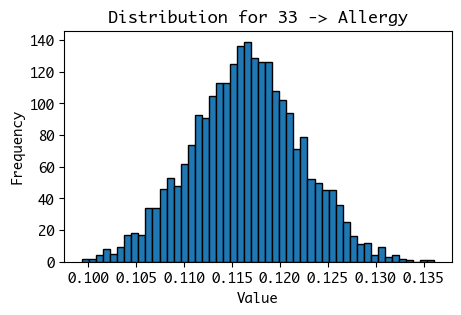

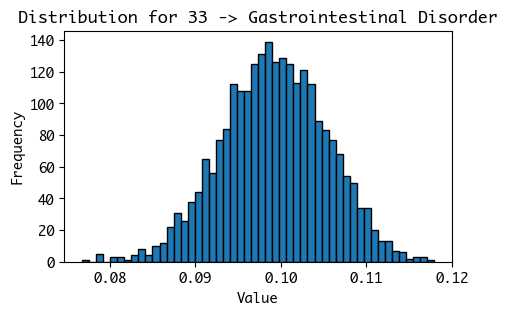

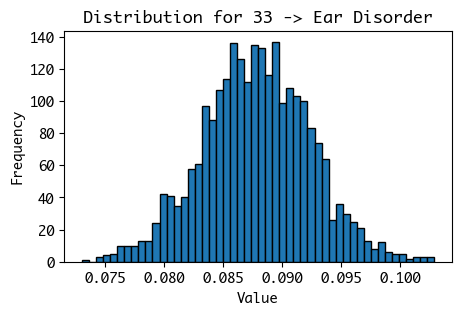

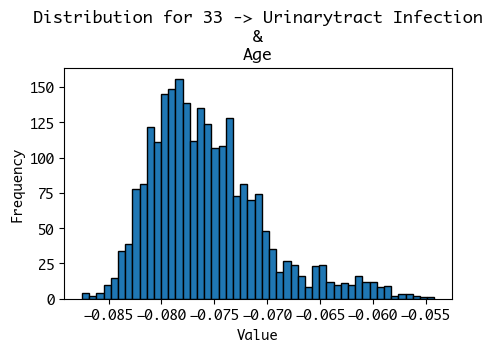

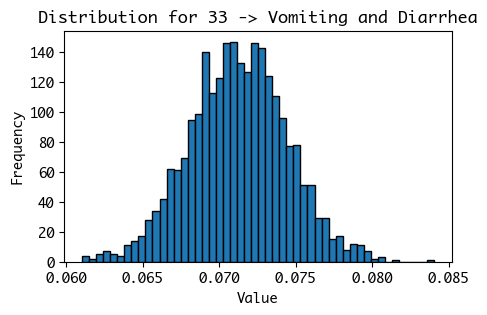

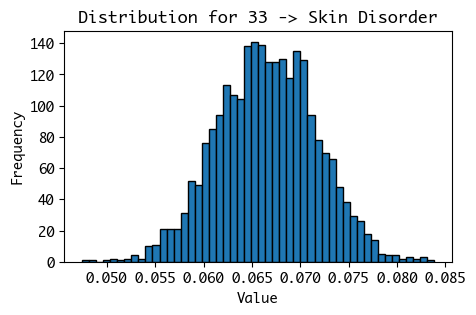

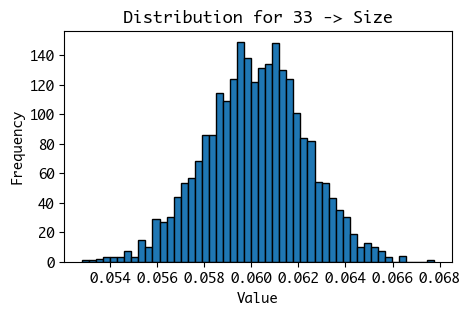

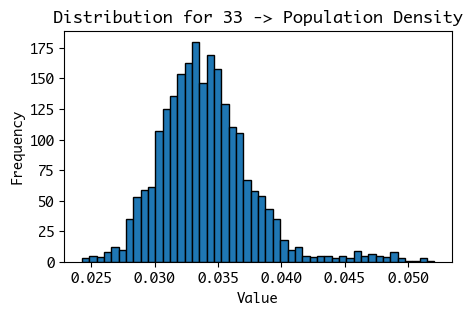

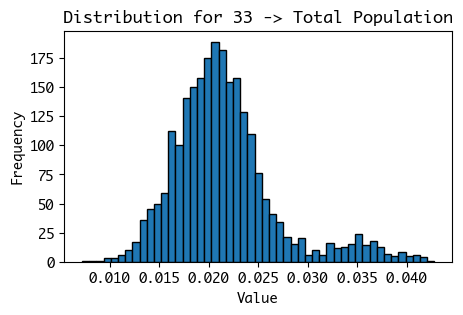

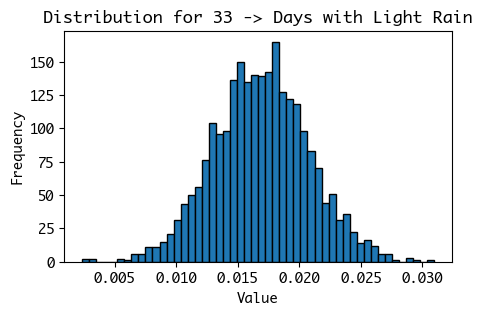

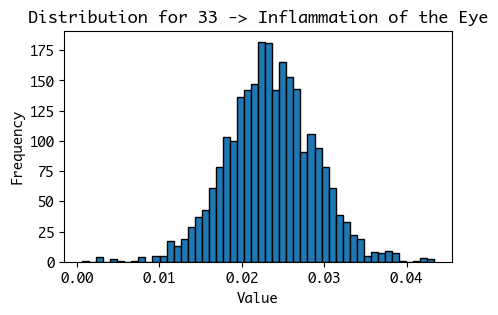

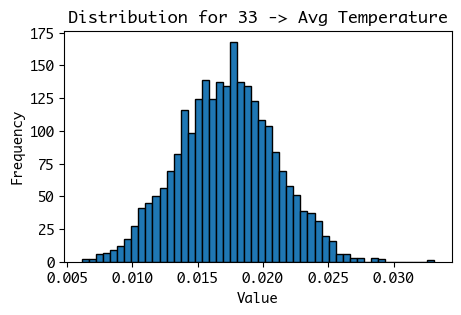

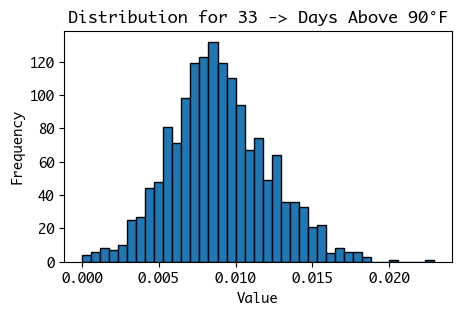

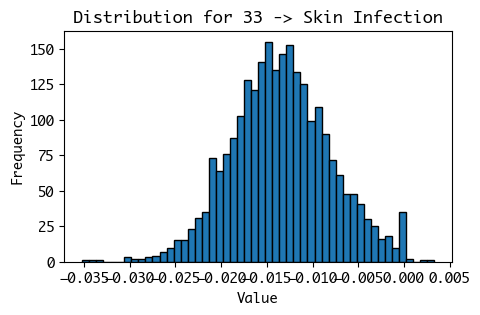

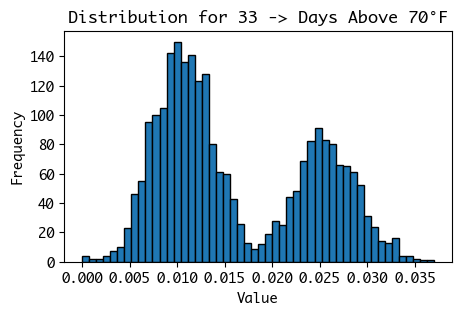

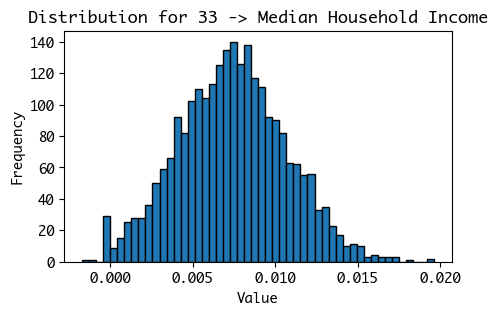

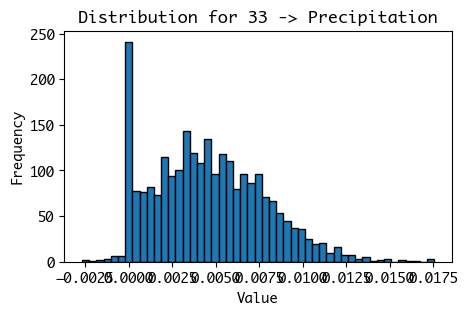

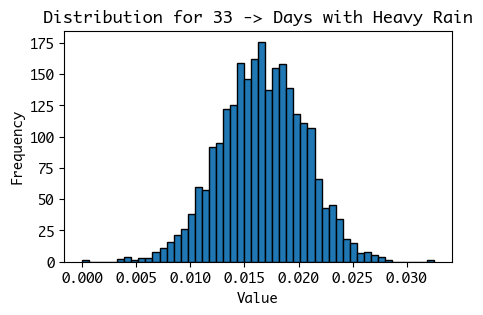

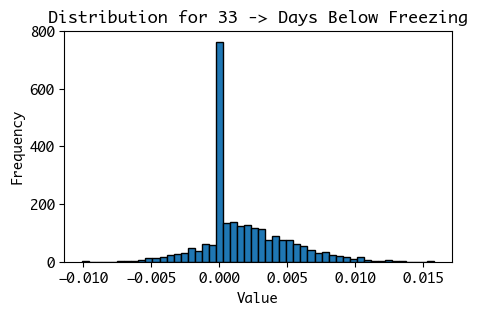

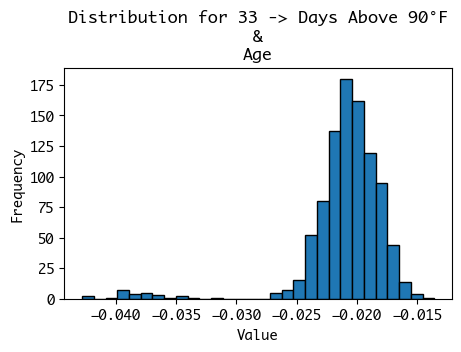

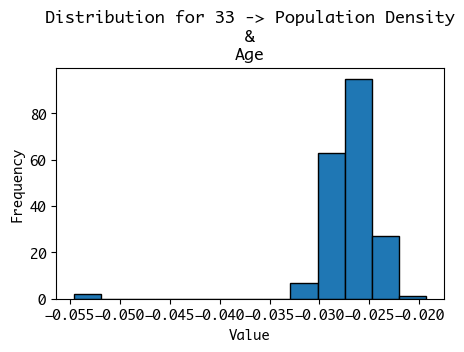

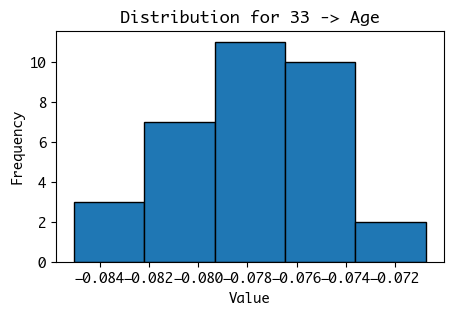

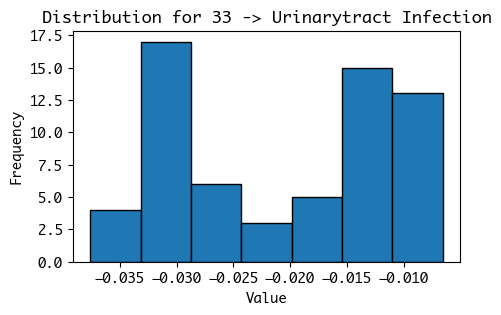

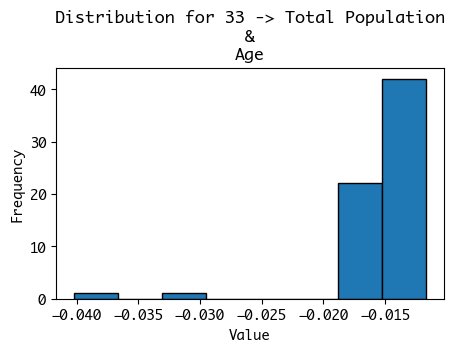

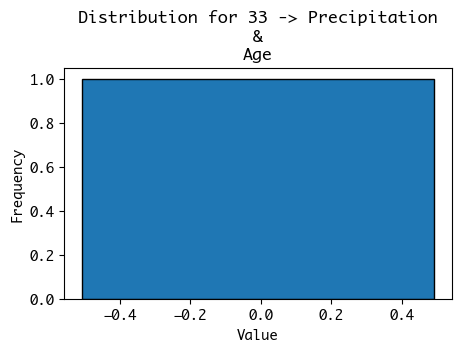

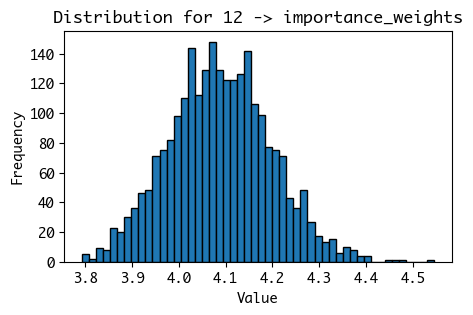

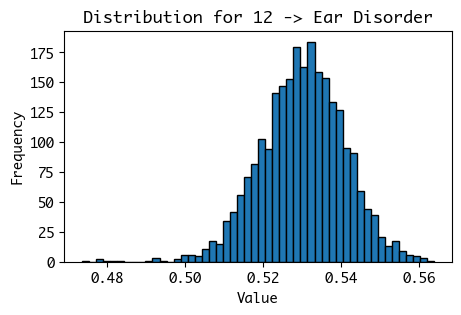

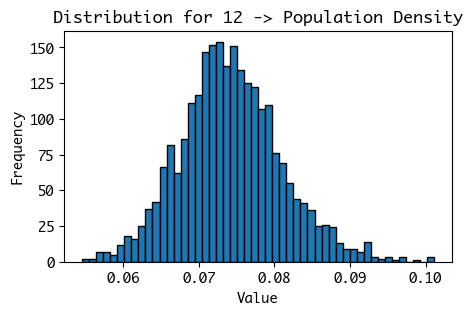

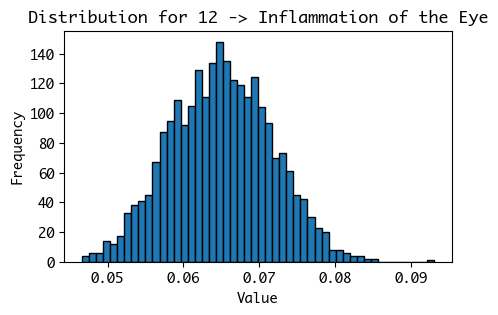

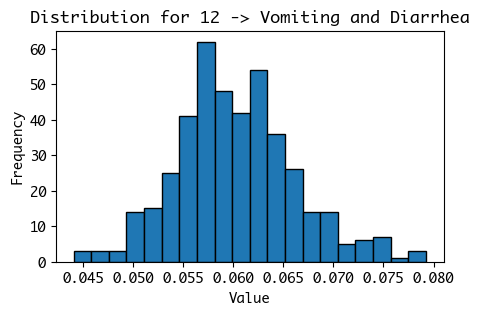

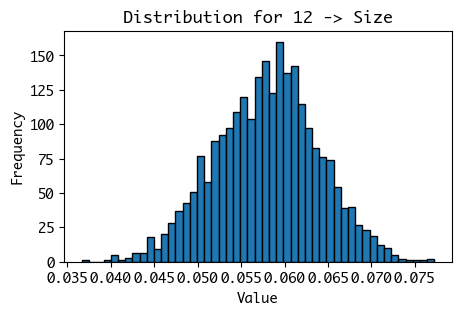

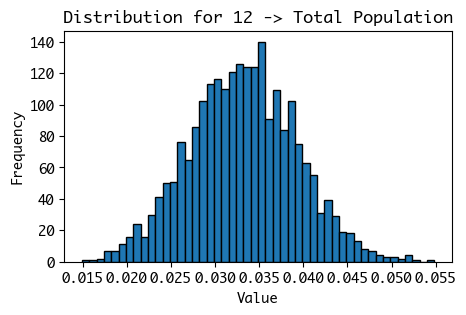

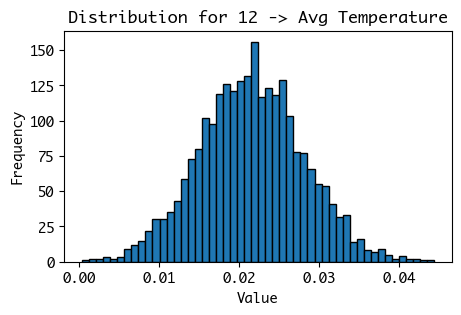

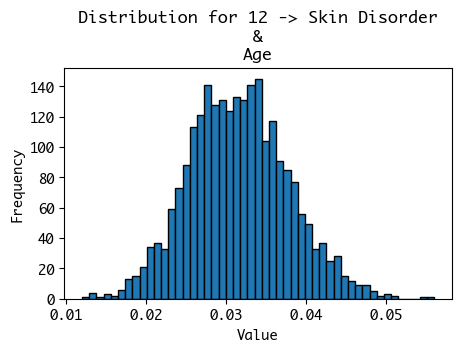

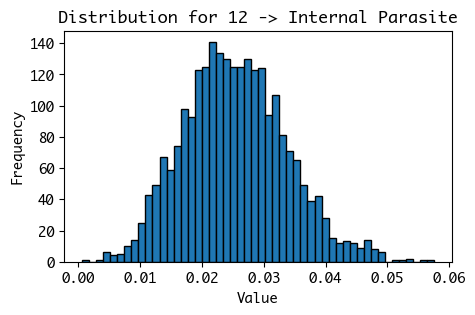

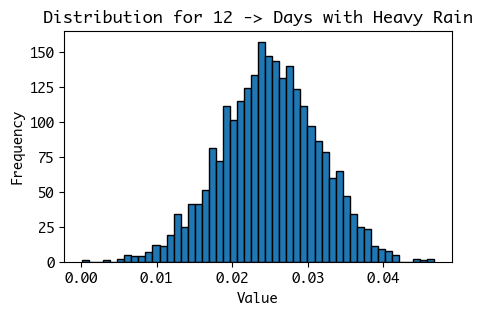

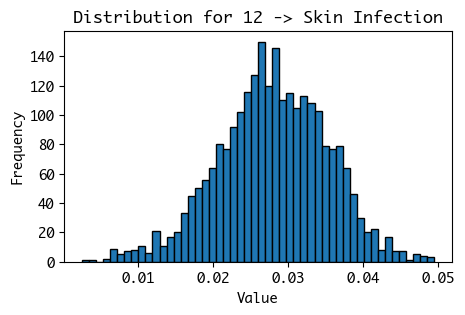

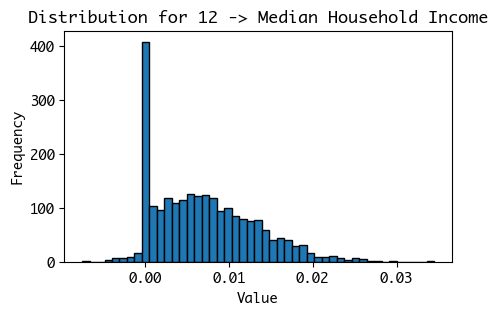

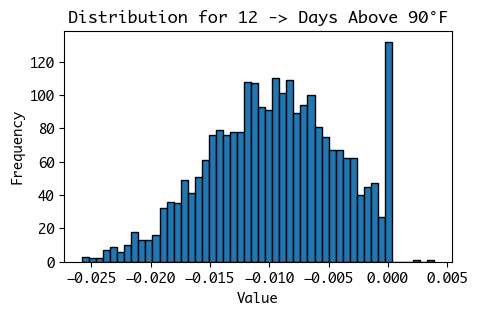

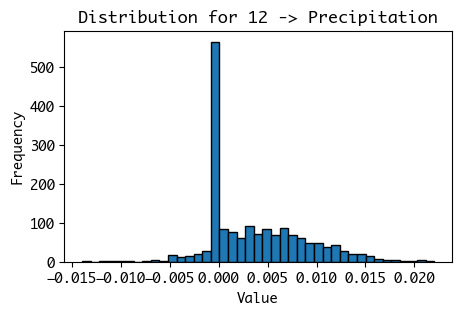

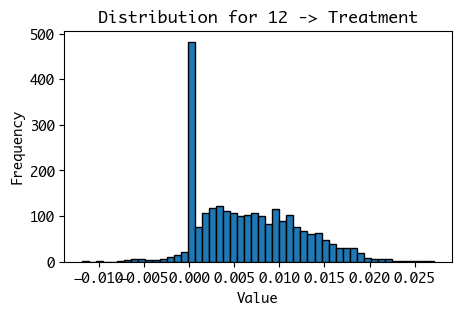

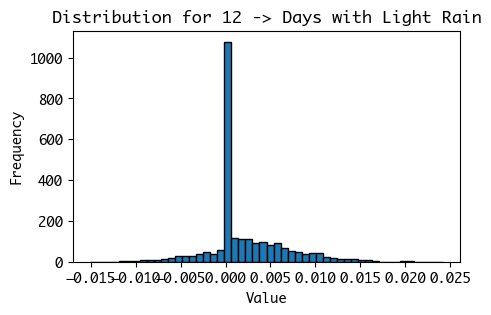

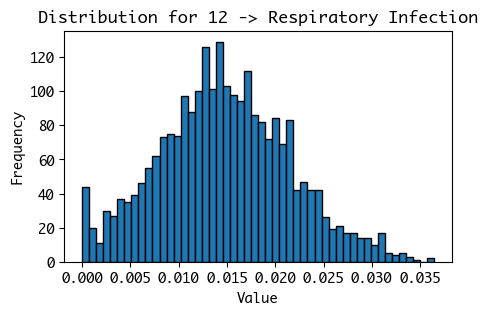

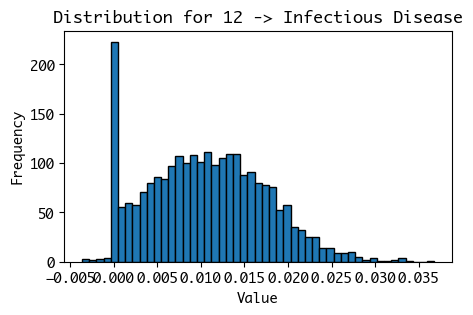

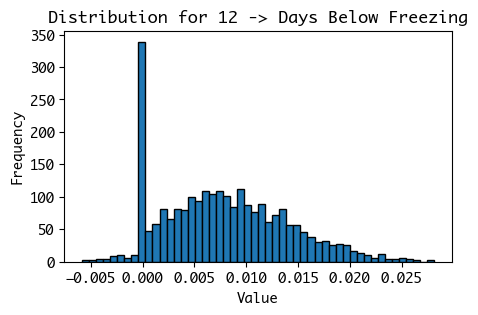

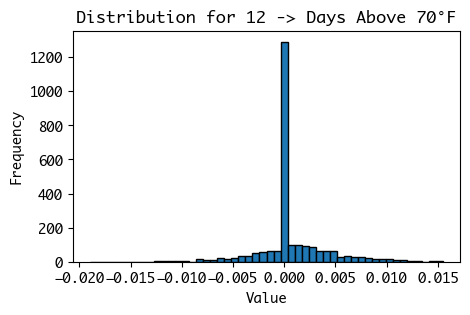

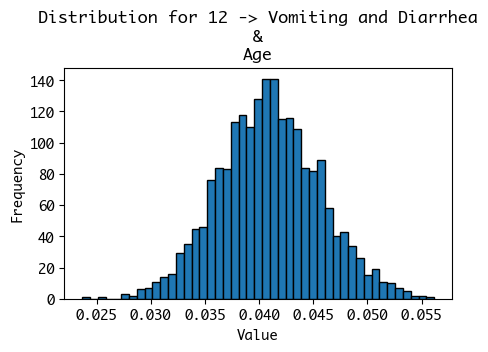

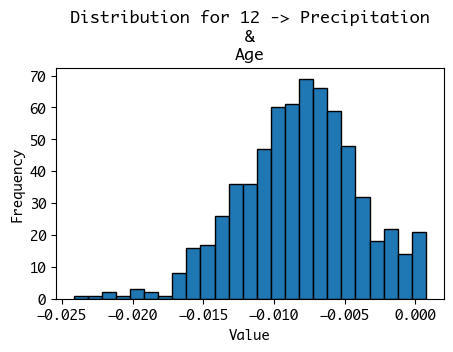

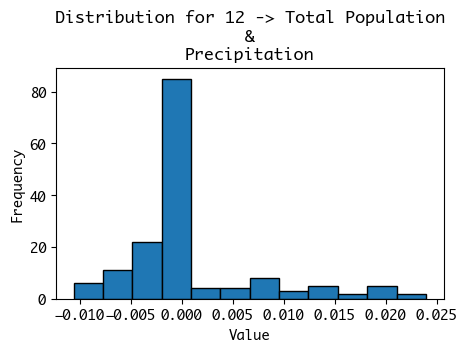

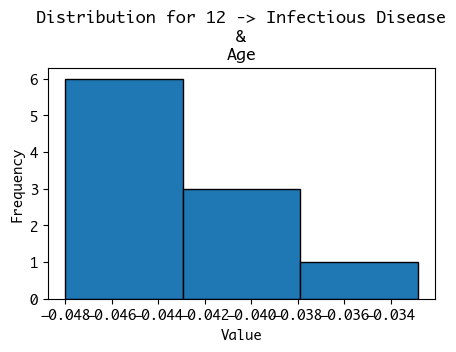

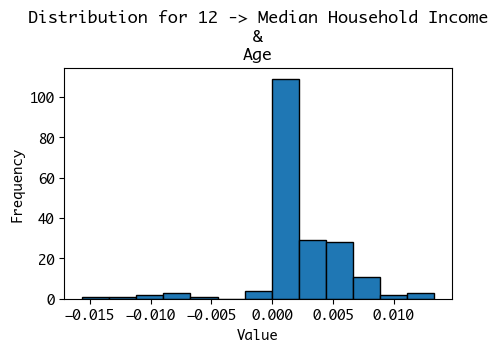

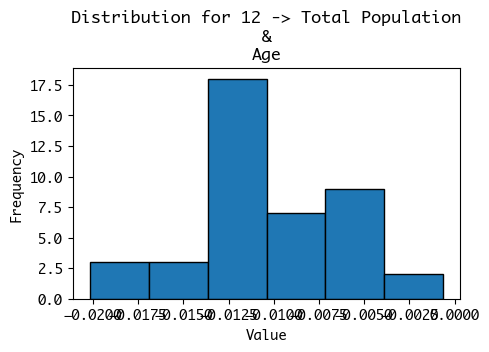

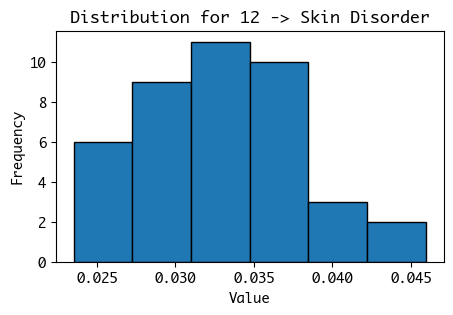

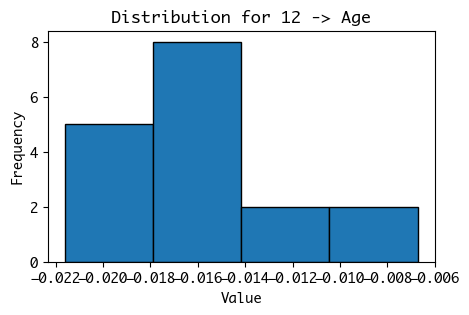

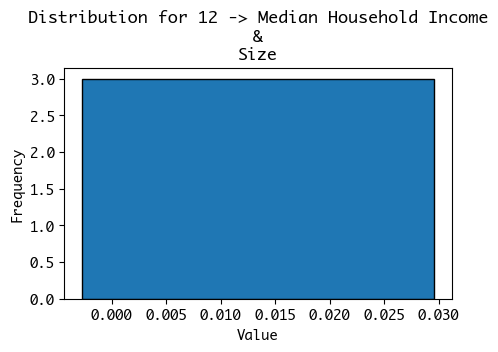

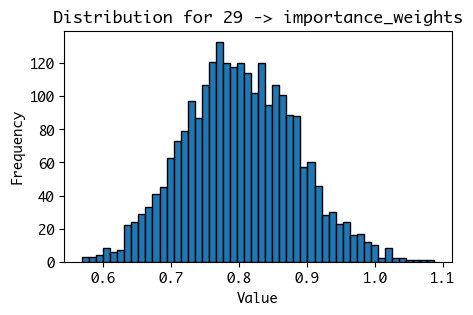

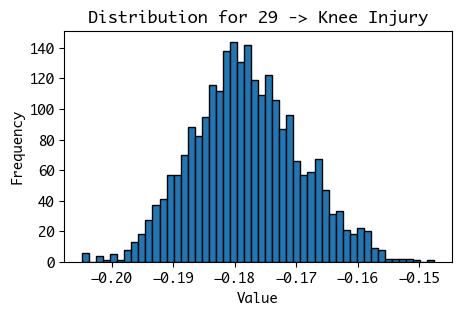

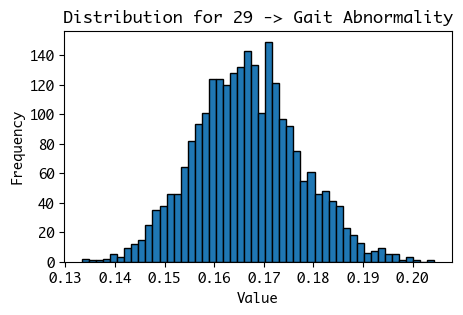

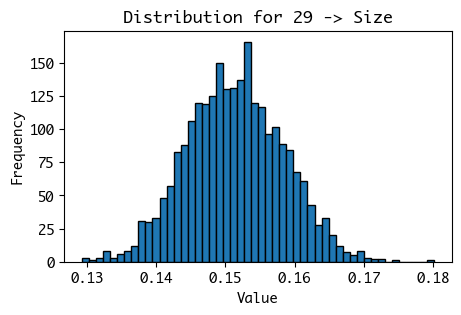

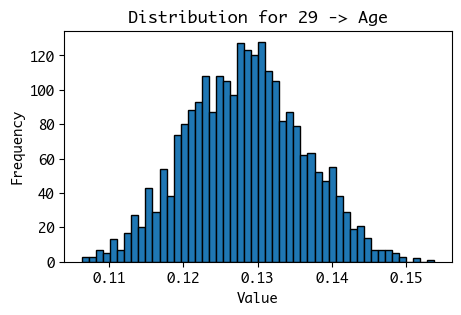

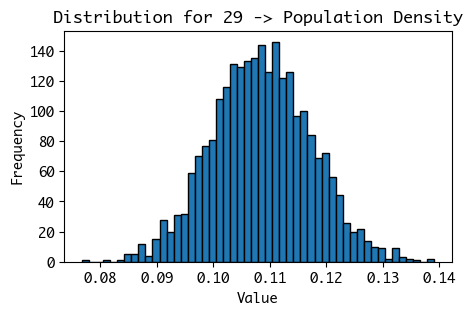

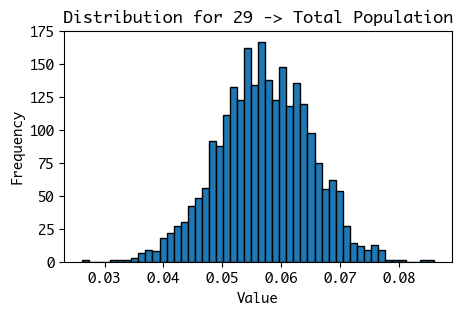

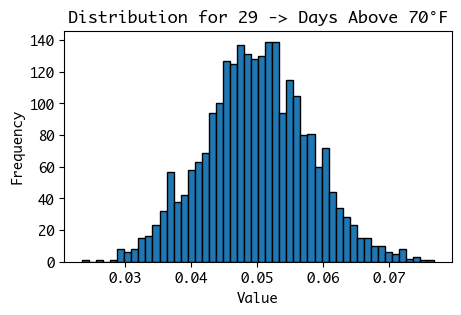

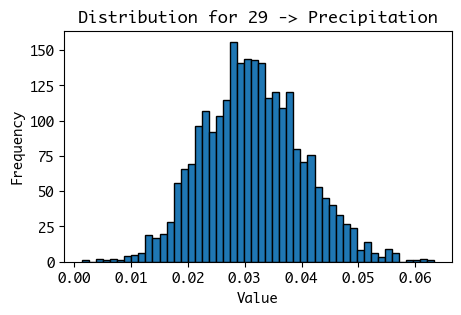

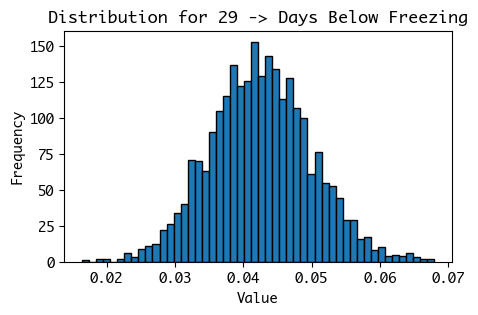

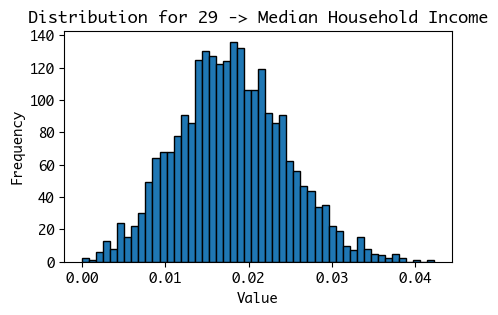

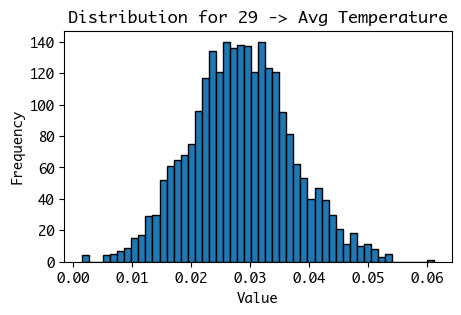

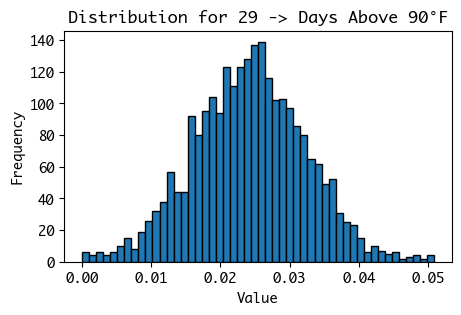

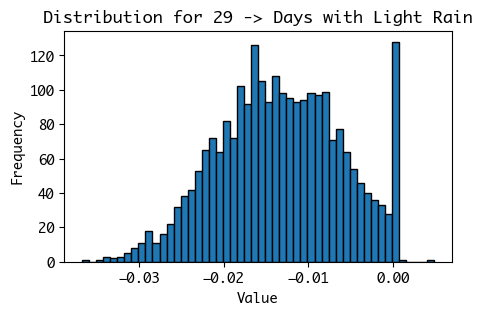

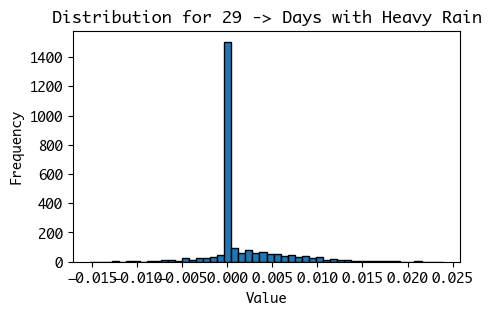

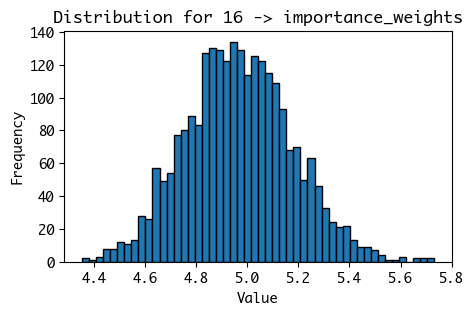

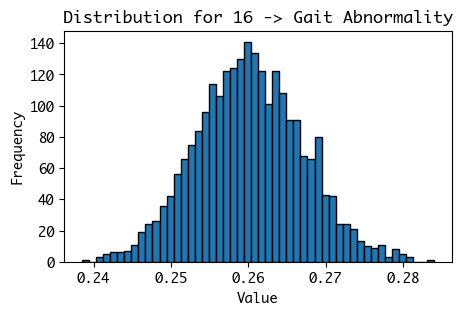

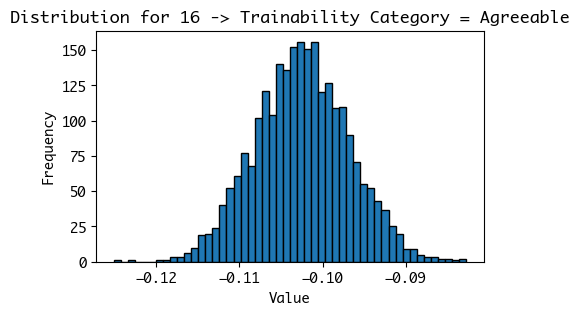

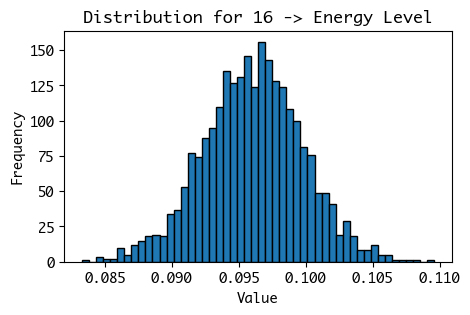

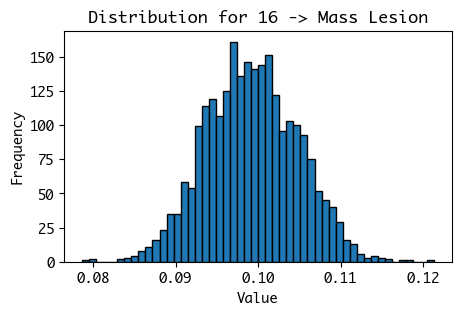

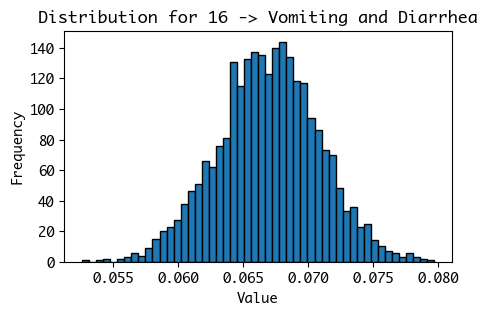

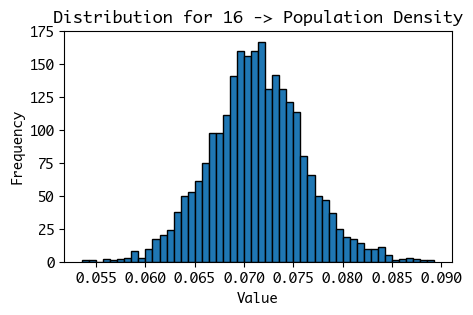

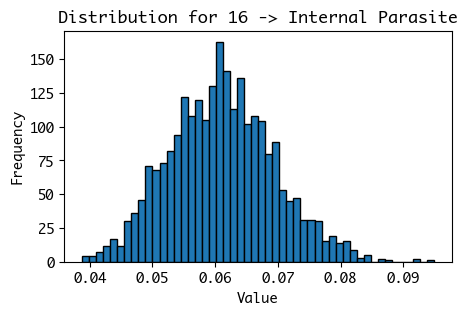

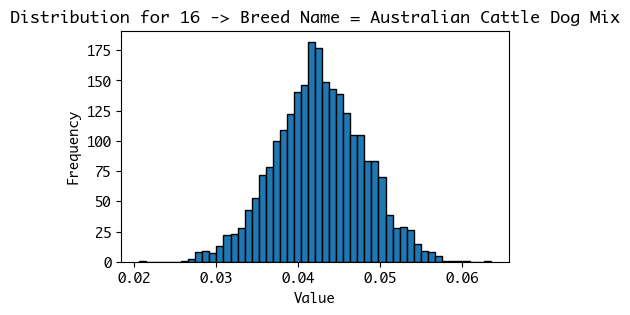

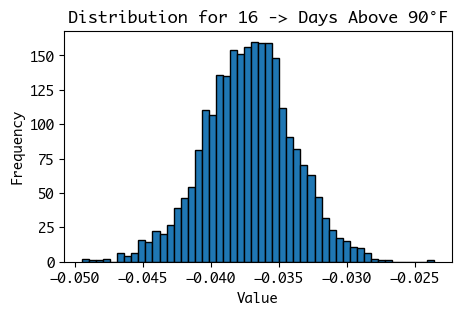

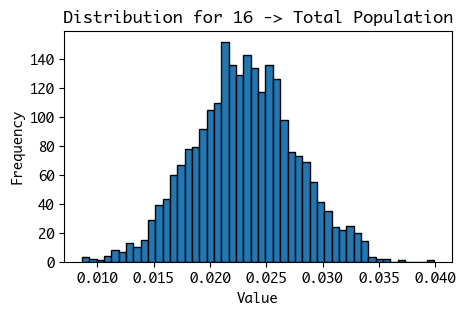

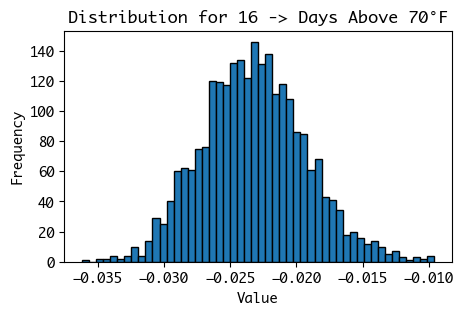

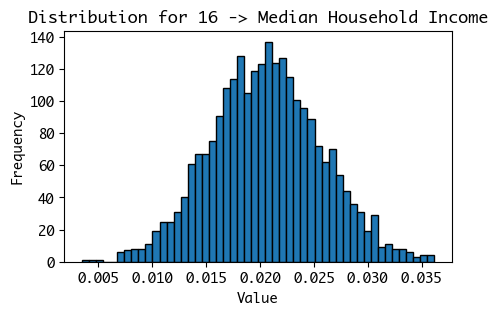

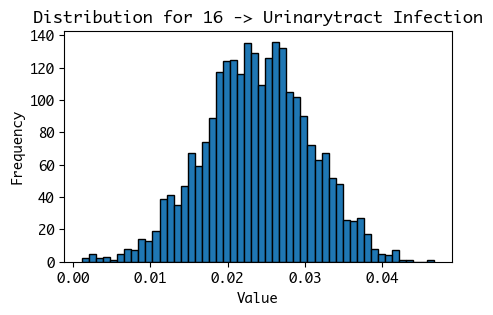

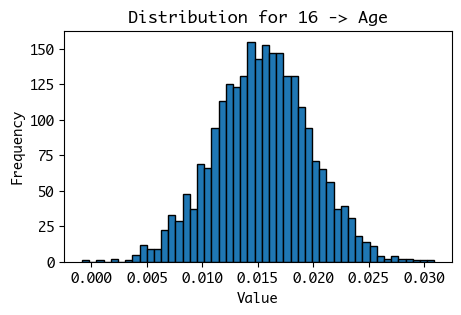

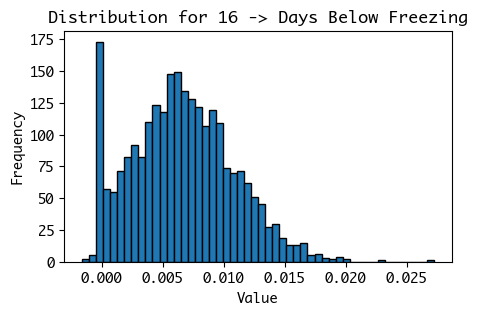

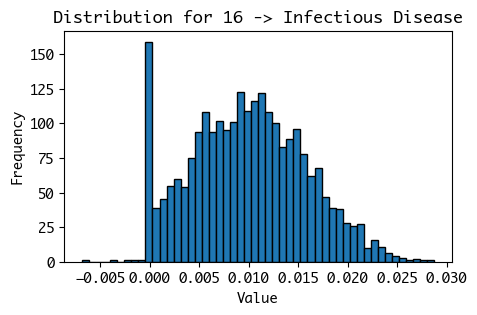

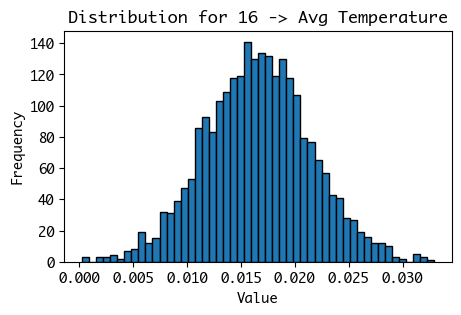

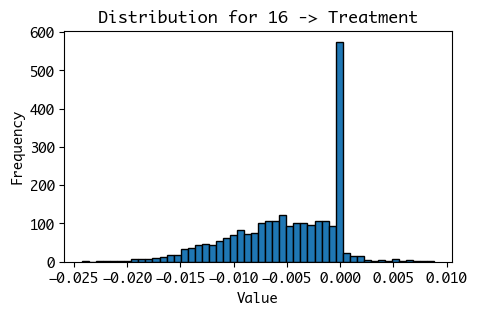

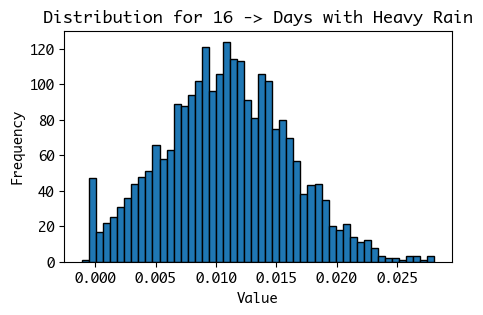

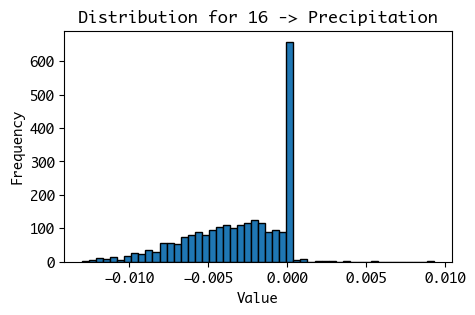

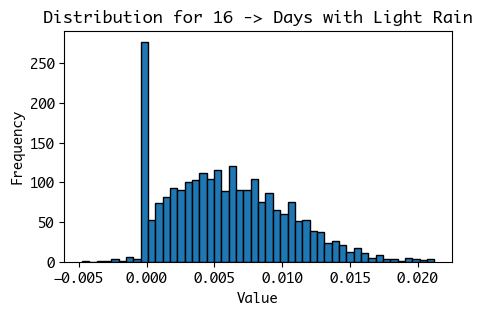

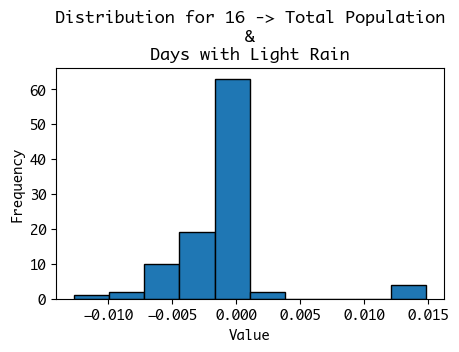

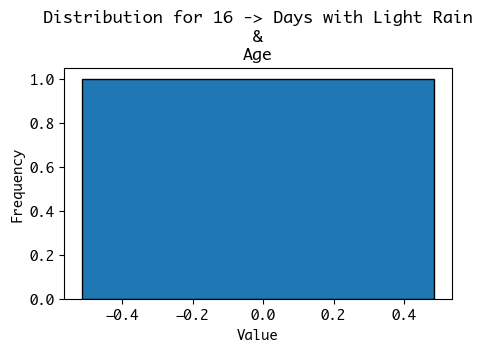

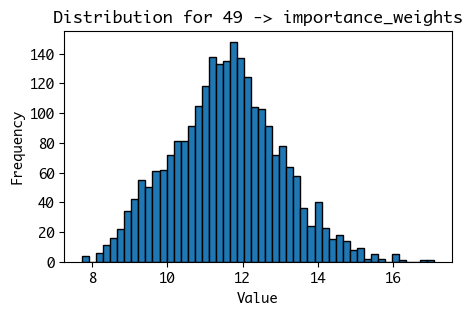

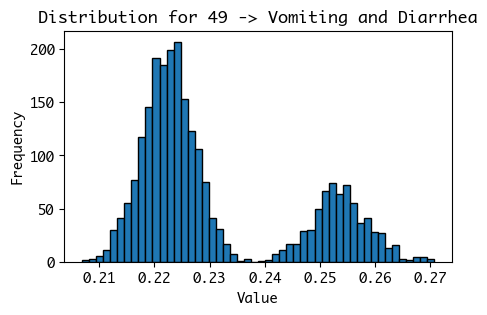

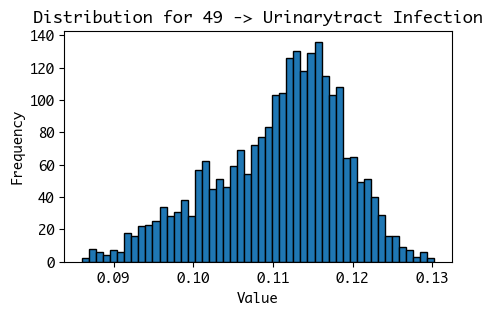

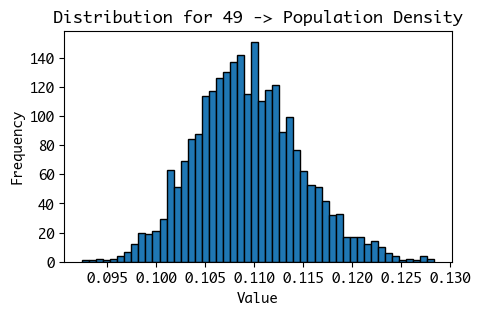

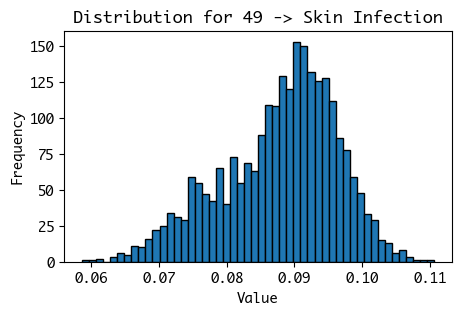

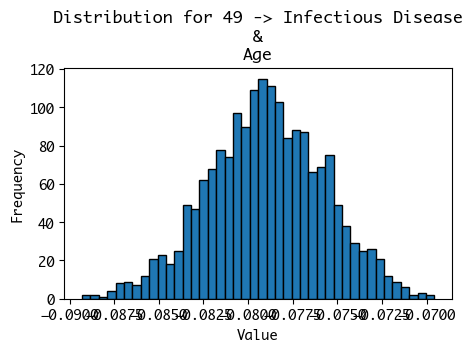

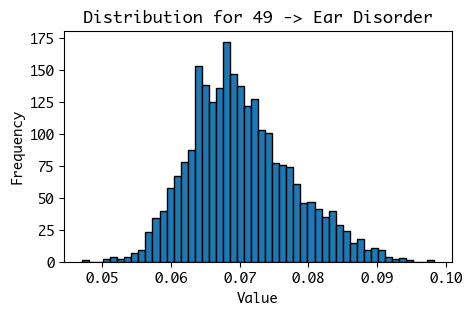

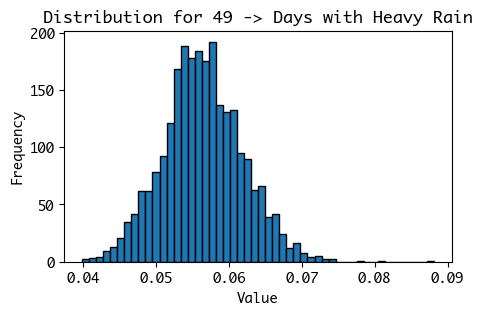

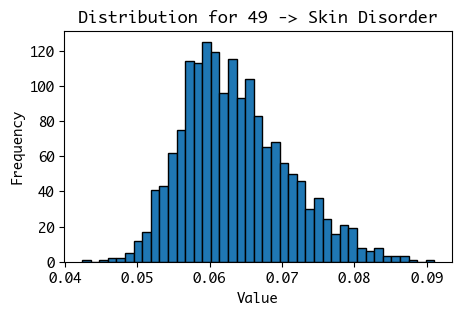

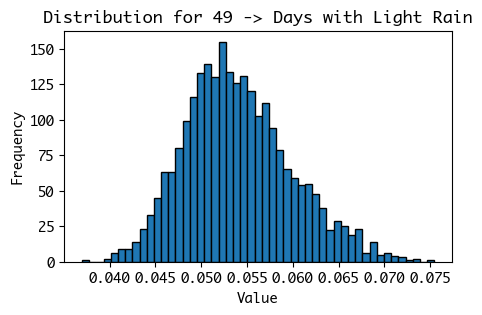

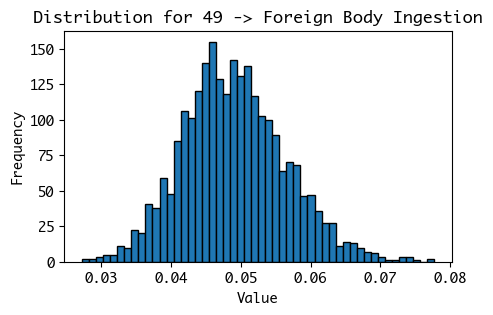

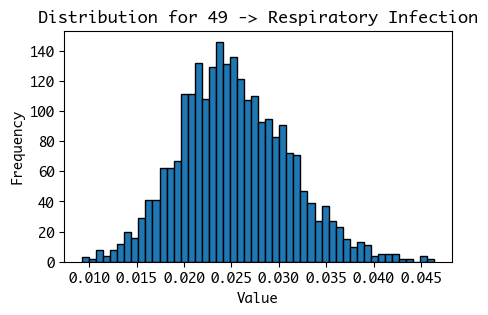

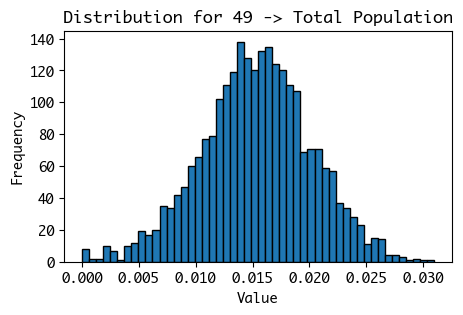

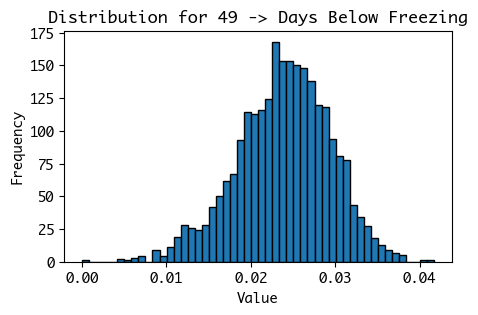

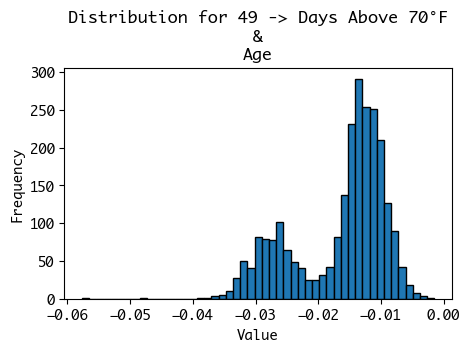

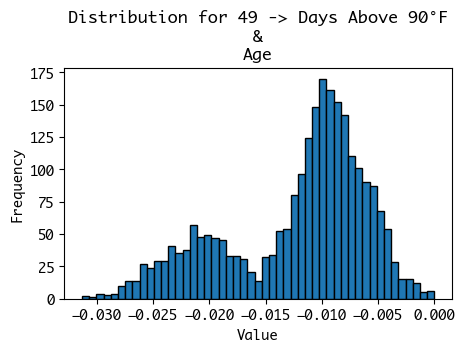

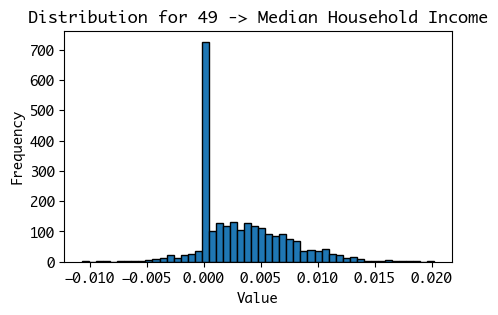

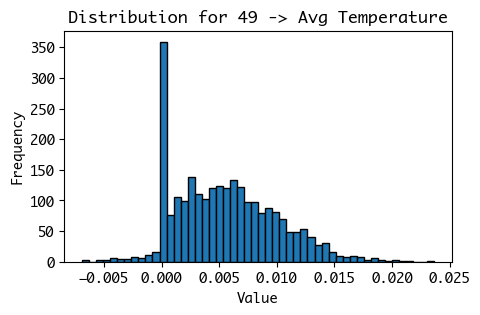

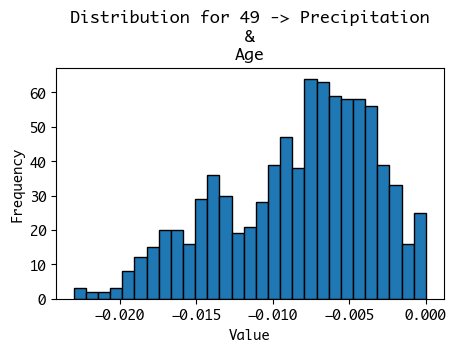

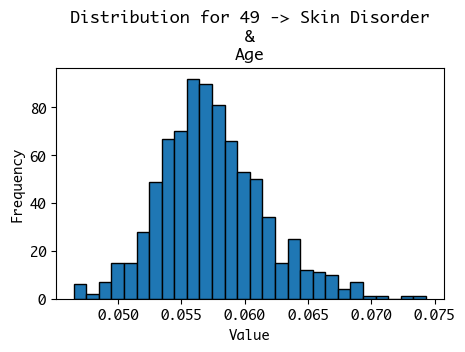

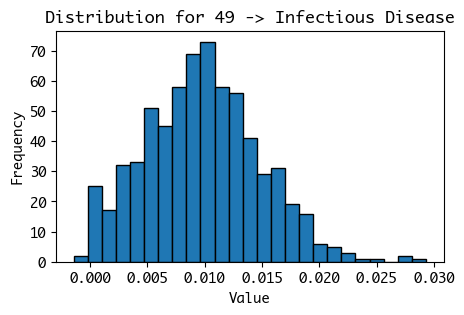

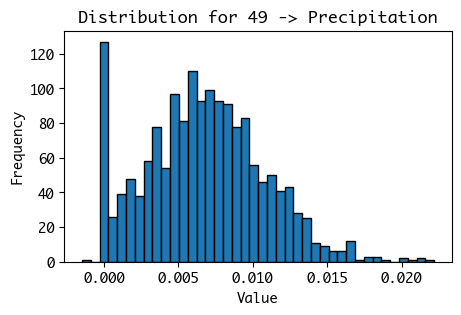

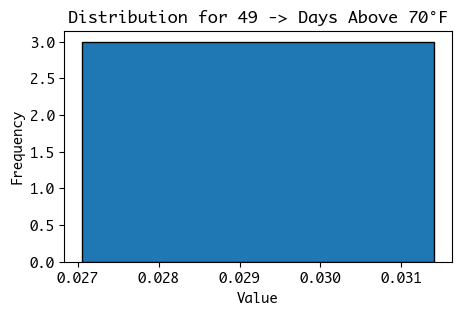

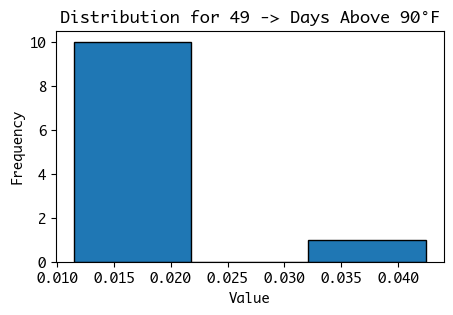

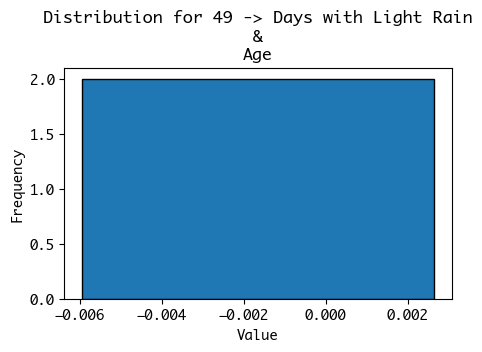

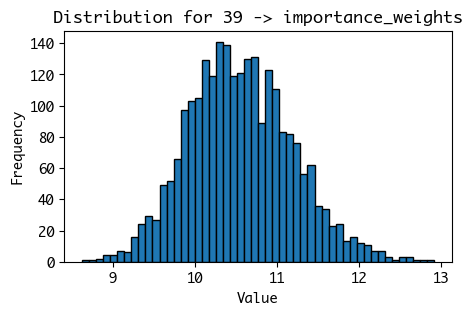

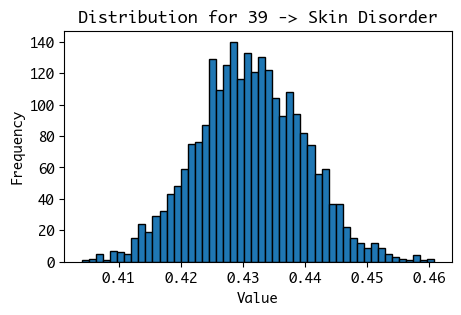

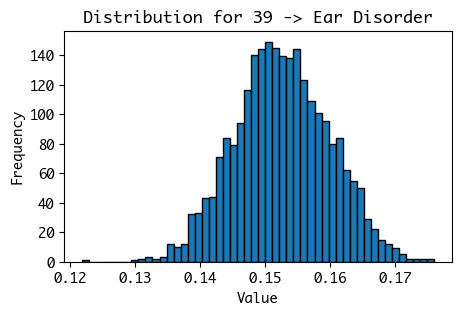

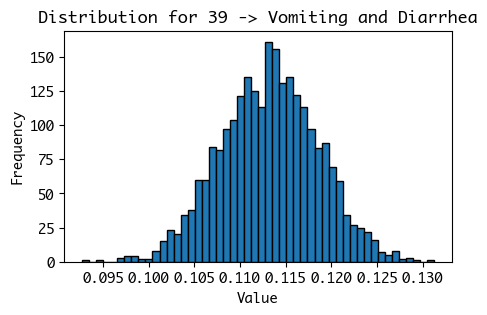

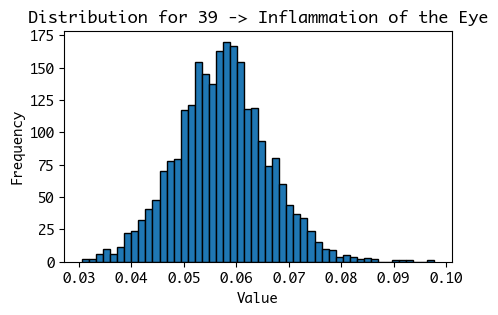

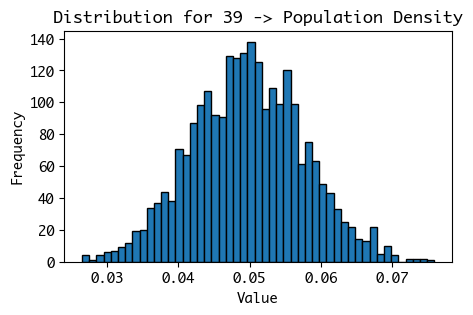

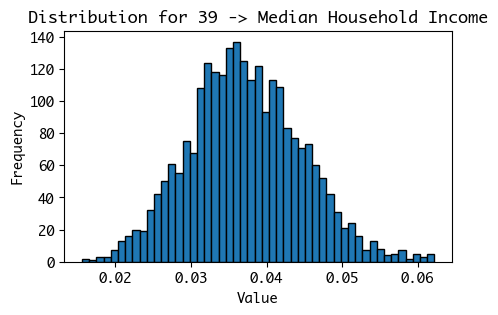

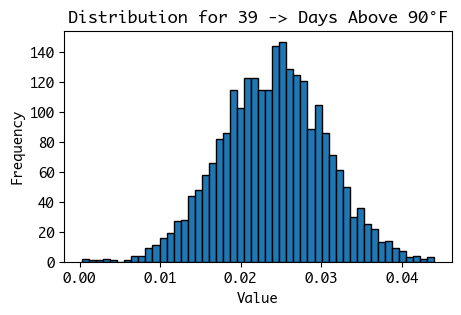

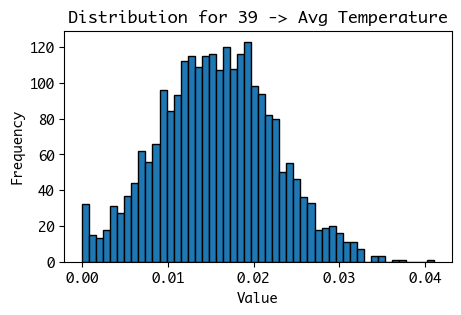

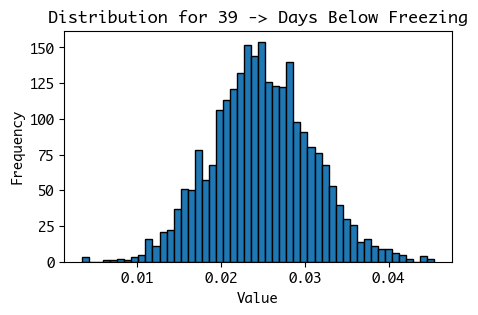

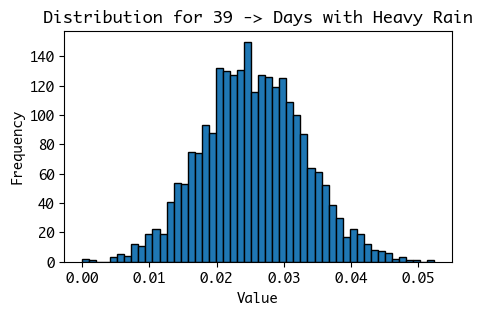

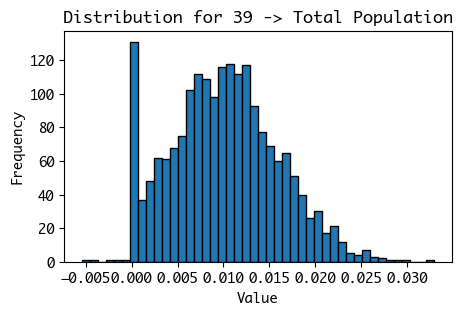

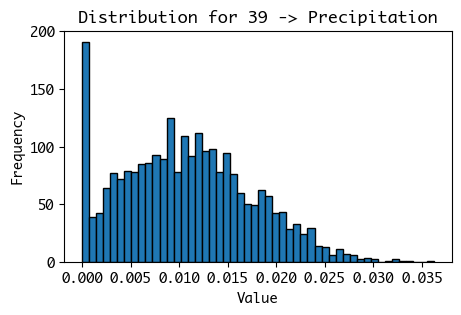

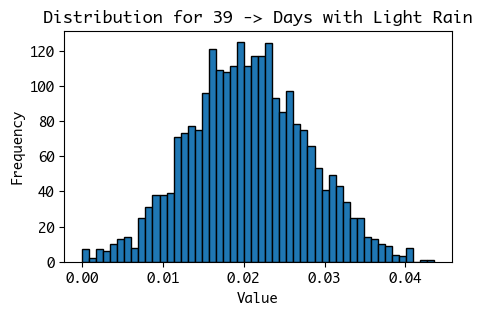

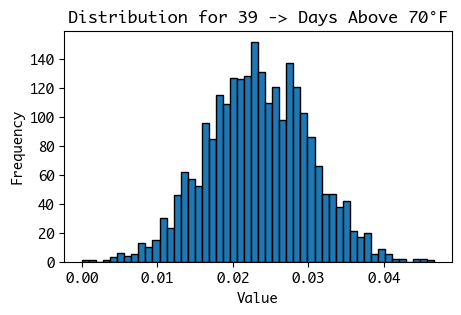

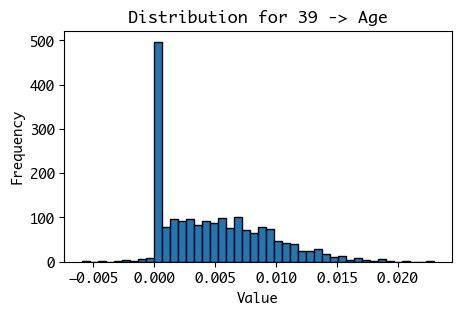

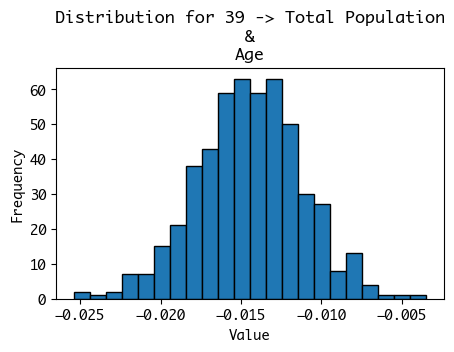

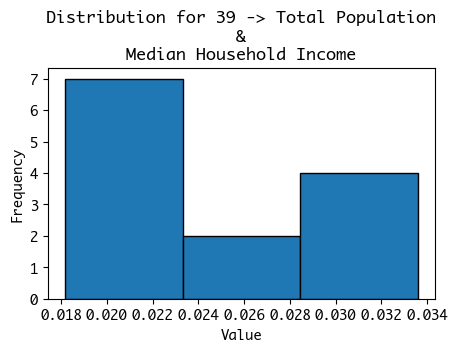

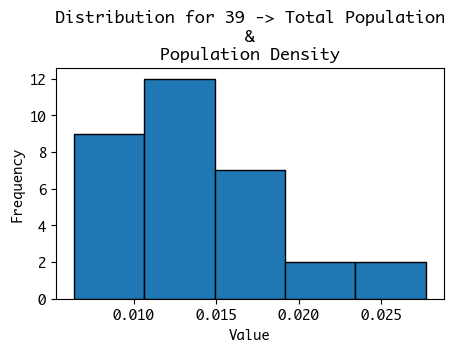

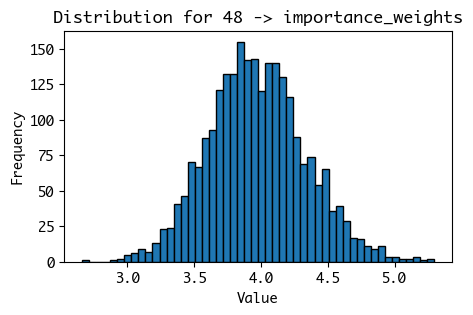

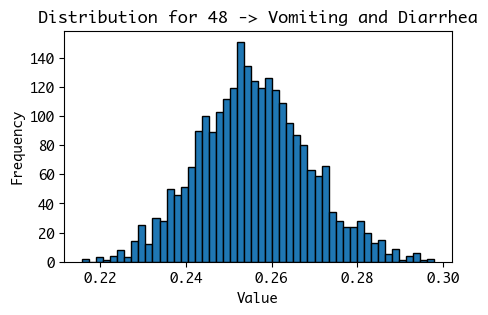

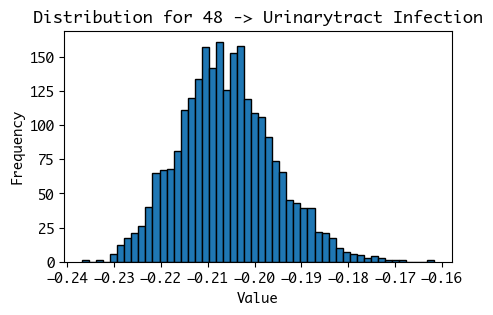

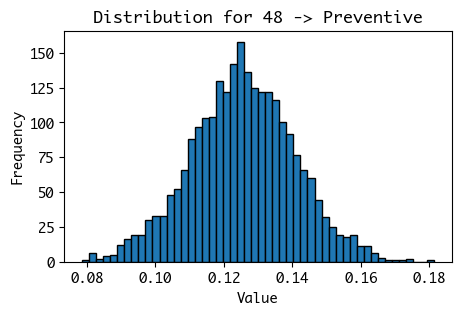

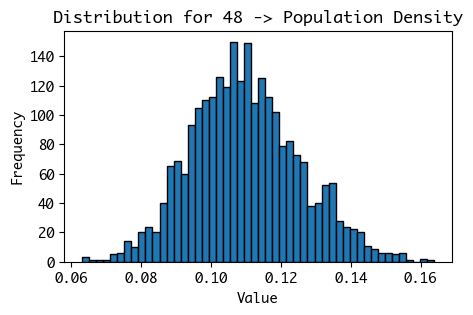

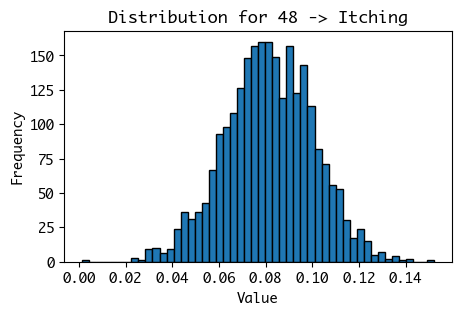

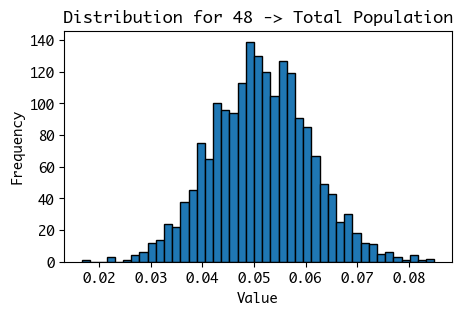

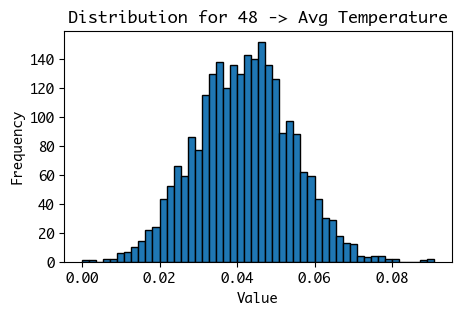

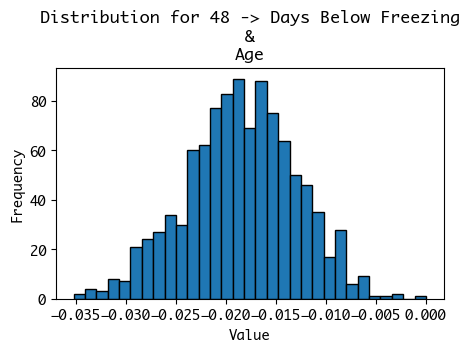

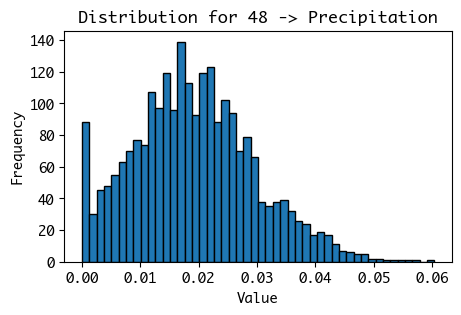

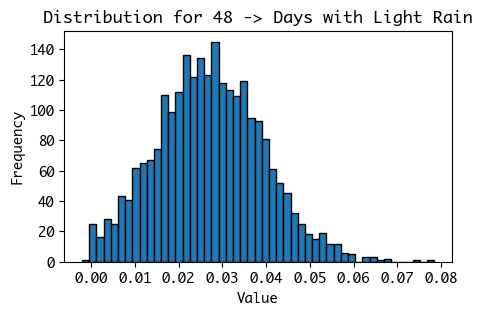

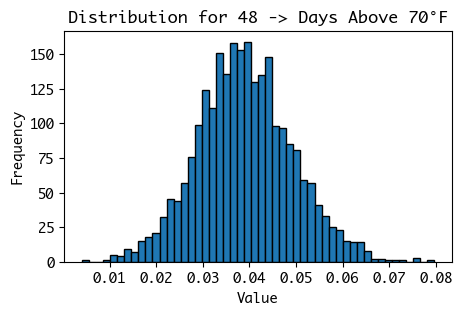

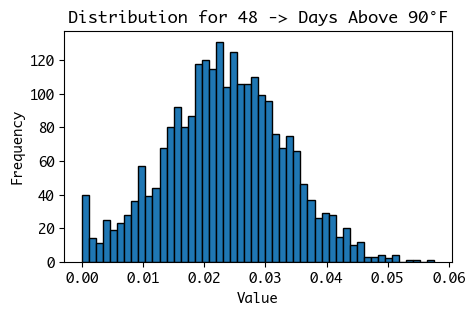

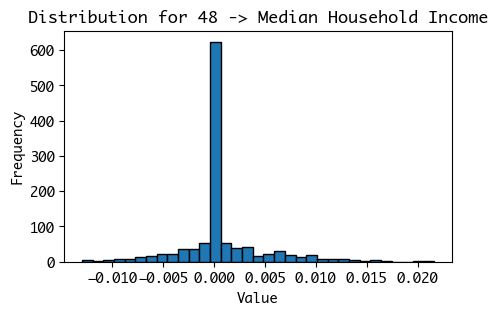

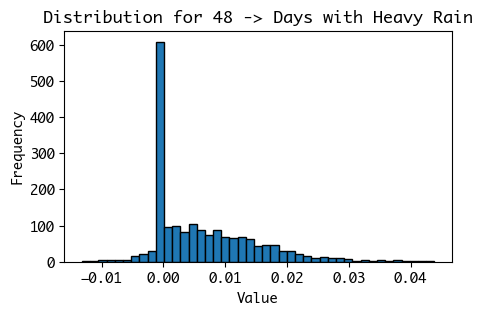

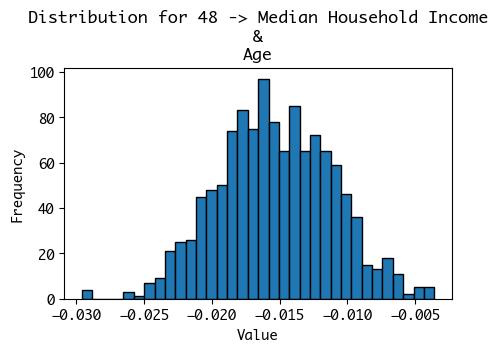

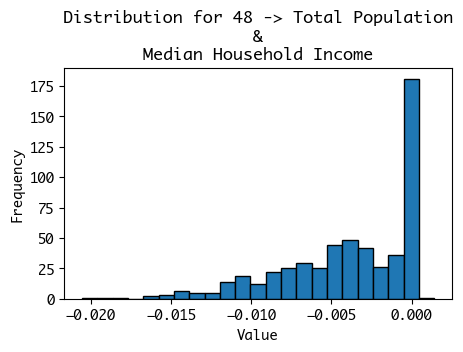

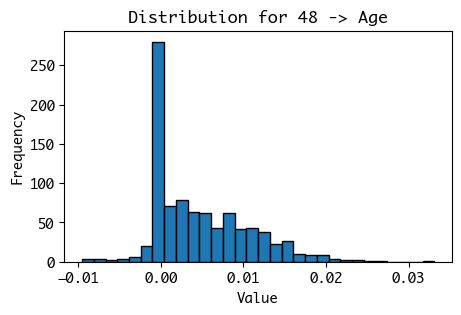

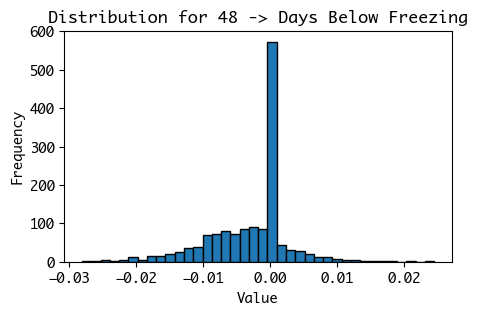

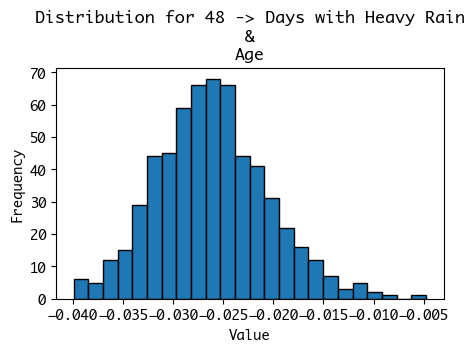

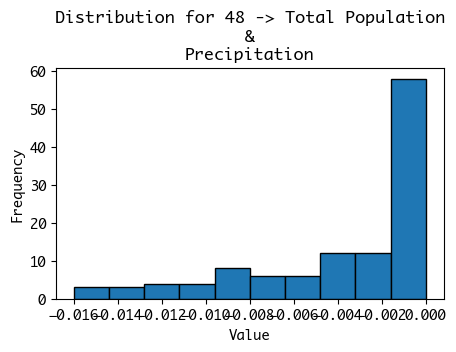

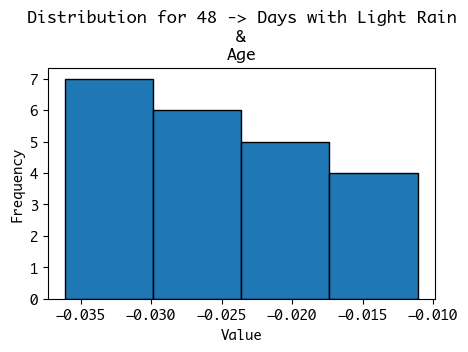

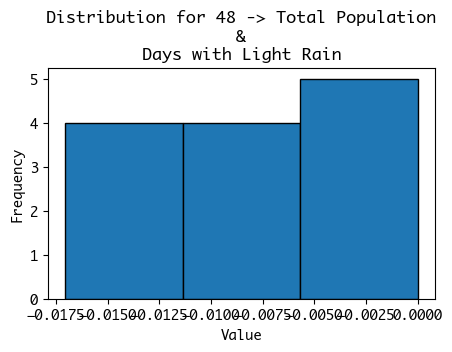

In [32]:
def plot_histograms(results):
    for key, nested_dict in results.items():
        for nested_key, values in nested_dict.items():
            
            values = [v for v in values if not np.isnan(v)]
            
            num_bins = int(np.sqrt(len(values)))
            
            # Plot the histogram
            plt.figure(figsize=(5, 3))
            plt.hist(values, bins=num_bins, edgecolor='black')
            plt.title(f'Distribution for {nested_key}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.show()

plot_histograms(results)

In [86]:
pd.set_option('display.max_columns', None)

def highlight_nonzero(val):
    color = 'yellow' if val != 0 else ''
    return f'background-color: {color}'

# Apply your highlighting function

#x_test[x_test['PetId'] == 'can566064dante'].style.applymap(highlight_nonzero) #1116 vomiting and diarrhea
#x_test[x_test['PetId'] == 'us565866bodie'].style.applymap(highlight_nonzero) # 2912 goloden retriever // cancer, hip, skin, heart
#x_test[x_test['PetId'] == 'us189128louie'].style.applymap(highlight_nonzero) # 2450 arthirits
# x_train[x_train['PetId'] == 'us1484bailey'].style.applymap(highlight_nonzero) # 6039 cancerous tumor>15%
#x_train[x_train['PetId'] == 'us1528835hamilton'].style.applymap(highlight_nonzero) # 7244 behavioraldisroder>15%
#x_train[x_train['PetId'] == 'us147810rocky'].style.applymap(highlight_nonzero) # 4628 diabetes>8% and many more illnesses
#x_train[x_train['PetId'] == 'us106606thumbelina'].style.applymap(highlight_nonzero) # 2032 heartdisroder>30%
#x_train[x_train['PetId'] == 'us116110darwin'].style.applymap(highlight_nonzero) # 2619 paindisorder+heartdisroder>20%
#x_train[x_train['PetId'] == 'us1439722remy'].style.applymap(highlight_nonzero) # 3889 knee>20%
#x_train[x_train['PetId'] == 'us148379gigi'].style.applymap(highlight_nonzero) # 5728 tooth>20%
# x_train[x_train['PetId'] == 'us188912bodhisatvva'].style.applymap(highlight_nonzero) # 9563 arthritis>20%
# x_train[x_train['PetId'] == 'us1129884louie'].style.applymap(highlight_nonzero) # 2449 analglanddisorder>20%
# x_train[x_train['PetId'] == 'us1479534noah'].style.applymap(highlight_nonzero) # 4929 \out analglanddisorder>20%
# x_train[x_train['PetId'] == 'us1523835vivian'].style.applymap(highlight_nonzero) # 6325 itching>40%

# x_train[x_train['PetId'] == 'us100528tye'].style.applymap(highlight_nonzero) # 1754 bloodcancer>10%
# x_train[x_train['PetId'] == 'us143740coco pop	'].style.applymap(highlight_nonzero) # 3418 inflammation>10%
# x_train[x_train['PetId'] == 'us1479534noah'].style.applymap(highlight_nonzero) # 4930 injuries>20%
# x_train[x_train['PetId'] == 'us1523591luke'].style.applymap(highlight_nonzero) # 6229 leg and injuries>20%
# x_train[x_train['PetId'] == 'us1528286amelia'].style.applymap(highlight_nonzero) # 6325 Letahrgy>20%
# x_train[x_train['PetId'] == 'can156676tucker'].style.applymap(highlight_nonzero) # 519 respiratoryinfections>20%
# x_train[x_train['PetId'] == 'can566581stella'].style.applymap(highlight_nonzero) # 1361 respiratoryinfections>40%
# x_train[x_train['PetId'] == 'us2250195phoebe'].style.applymap(highlight_nonzero) # 11075 skindisorder>20%
# x_train[x_train['PetId'] == 'us565583henry'].style.applymap(highlight_nonzero) # 11600 skindisorder>20%
# x_train[x_train['PetId'] == 'us1885021rosco'].style.applymap(highlight_nonzero) # 8899 skindisorder>20%
# x_train[x_train['PetId'] == 'us121186olive'].style.applymap(highlight_nonzero) # 2907 surgical>20%
# x_train[x_train['PetId'] == 'us2246639denali'].style.applymap(highlight_nonzero) # 10670 surgical>20%
# x_train[x_train['PetId'] == 'us1888957bing bing'].style.applymap(highlight_nonzero) # 9508 thyroiddisorder>20%
# x_train[x_train['PetId'] == 'us2250195phoebe'].style.applymap(highlight_nonzero) # 11075 skindisorder>20%


#x_test[x_test['PetId'] == 'us143995kona'].style.applymap(highlight_nonzero) #965 Anxietyorphobia Foreignbodyingestion	 959 Infectiousdiseases	 Skindisorders Internalparasites Vomitinganddiarrhea english bulldog 5,5 years
#x_test[x_test['PetId'] == 'us143664mowgli'].style.applymap(highlight_nonzero) #755-766 no diseases ever	puggle 0,5-11,5 years
#x_test[x_test['PetId'] == 'us148412sunny'].style.applymap(highlight_nonzero) # 1408 arthirits
#x_test[x_test['PetId'] == 'us148331rocky'].style.applymap(highlight_nonzero) # 1382 masslesions leginjury
#x_test[x_test['PetId'] == 'us14424tarja'].style.applymap(highlight_nonzero) #1230 Heartdisorder 
#x_test[x_test['PetId'] == 'us147954sabrina'].style.applymap(highlight_nonzero) #1116 Heartdisorder 
#x_test[x_test['PetId'] == 'us189128louie'].style.applymap(highlight_nonzero) # 2450 arthirits
#x_test[x_test['PetId'] == 'us1479726coco'].style.applymap(highlight_nonzero) # 2447 immunedisorder

#x_test[x_test['PetId'] == 'us144016omar'].style.applymap(highlight_nonzero) # 998 same disease but age 9
#x_test[x_test['PetId'] == 'us1160057melo'].style.applymap(highlight_nonzero) # 547 age 1


# x_test.iloc[:,2:52]
# row_sums = x_test.iloc[:, 2:52].sum(axis=1)
# top_rows = row_sums.sort_values(ascending=False).index[:200]
# top_rows_df=x_test.iloc[top_rows]
# top_rows_df[top_rows_df['BreedName_GoldenRetriever']==1].style.applymap(highlight_nonzero)



def get_high_prob_indexes(x_test, threshold=0.1,disease_idx=0):
    indexes = []
    for idx, row in x_test.iterrows():
        row_df = pd.DataFrame(row).transpose()
        prediction = my_classifier_run(row_df.iloc[:,2:].values)
        if np.any(prediction[0,disease_idx] > threshold):
            indexes.append(idx)
    return indexes
indexes = get_high_prob_indexes(x_train,disease_idx=15)
top_rows_df=x_train.iloc[indexes]
top_rows_df.style.applymap(highlight_nonzero)

top_rows_df[top_rows_df['Foreignbodyingestion']!=1].style.applymap(highlight_nonzero)

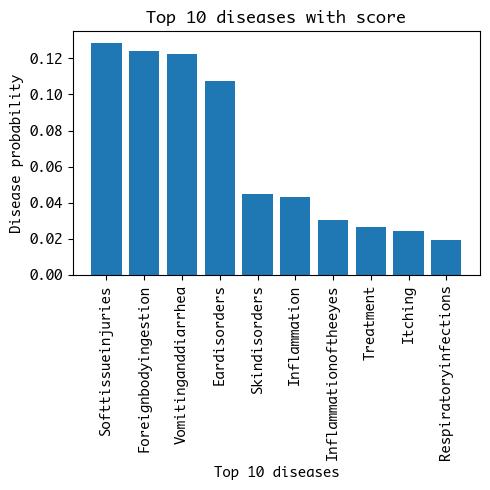

In [87]:
# def plot_top_10_diease(sample_df, save=True):
#     prediction = my_classifier_run(sample_df.iloc[:,2:].values)  # Assuming that your function my_classifier_run() returns an array of predictions
#     sorted_indices = np.argsort(prediction[0])  # Sort the indices
#     second_and_third_indices = sorted_indices[[-1, -3]]

#     second_and_third_disease_scores = prediction[0][second_and_third_indices]
#     second_and_third_diseases = [classifier.features[ind] for ind in second_and_third_indices]  # Assuming classifier.features holds the disease names

#     fig = plt.figure(figsize=(3, 5))
#     plt.bar(second_and_third_diseases, second_and_third_disease_scores)

#     plt.xlabel('Diseases')
#     plt.ylabel('Disease probability')

#     plt.xticks(rotation=90)
#     plt.tight_layout()
#     plt.show()

sample = x_train.iloc[219]
sample_df = pd.DataFrame(sample).transpose()
plot_top_10_dieases(sample_df, save=False)
# # Iterate over columns and find those with a non-zero value
# for col in sample_df.columns:
#     value = sample_df.loc[sample_df.index[0], col]
#     if value != 0:
#         print(f"{col}, Value: {value}")

In [348]:
# Recursive function to get all descendants of a given node
def get_all_descendants(tree):
    descendants = []
    children = tree.get("children", [])
    for child in children:
        descendants.append(child.get("name"))
        descendants.extend(get_all_descendants(child))
    return descendants

# Recursive function to traverse the tree and generate mapping from each node to its descendants
def traverse_tree(tree):
    mapping = {}
    node_name = tree.get("name")
    descendants = get_all_descendants(tree)
    
    if node_name in mapping:
        mapping[node_name].extend(descendants)
    else:
        mapping[node_name] = descendants

    # Create a mapping for each child node
    for child in tree.get("children", []):
        child_mapping = traverse_tree(child)
        for key, value in child_mapping.items():
            if key in mapping:
                mapping[key].extend(value)
            else:
                mapping[key] = value

    return mapping
  
# Function to intersect keys list with removal lists and update breed features and removal lists accordingly  
def intersect_and_remove(keys_list, removal_lists, breed_children, breed_features):
    for key in keys_list:
        breed_child_values = set(breed_children[key])
        overlapping_keys = list(breed_child_values.intersection(sum(removal_lists, [])))
        breed_features[key] = overlapping_keys
        # Remove overlapping keys
        for overlap in overlapping_keys:
            for removal_list in removal_lists:
                if overlap in removal_list:
                    removal_list.remove(overlap)
                    
# Load the JSON file
with open('/Users/marvinseiferling/storage/breed_hierarchie/breed_groups.json', 'r') as f:
    trees = json.load(f)

# Create a mapping from each node to its descendants
node_to_descendants = {}
for tree in trees:
    node_to_descendants.update(traverse_tree(tree))     
    
# Process the results
for label in results:
    # Identify keys related to breed information
    search_strings = ['Sub Breed', 'Super Breed', 'Breed Name', 'Breed Type']
    found_breed_keys = []
    for key in results[label]:
        for search_string in search_strings:
            if search_string in key:
                found_breed_keys.append(key)
    
    # Create dictionaries to store breed children and features
    breed_children = {item: node_to_descendants.get(item, []) for item in found_breed_keys}
    breed_features = {item: [] for item in found_breed_keys}
    
    # Separate keys based on breed category
    breed_type_keys = [key for key in breed_children.keys() if 'Breed Type' in key]
    super_breed_keys = [key for key in breed_children.keys() if 'Super Breed' in key]
    sub_breed_keys = [key for key in breed_children.keys() if 'Sub Breed' in key]
    breed_name_keys = [key for key in breed_children.keys() if 'Breed Name' in key]
    
    # Intersect and remove overlapping keys
    intersect_and_remove(breed_type_keys, [super_breed_keys, sub_breed_keys, breed_name_keys], breed_children, breed_features)
    intersect_and_remove(super_breed_keys, [sub_breed_keys, breed_name_keys], breed_children, breed_features)
    intersect_and_remove(sub_breed_keys, [breed_name_keys], breed_children, breed_features)

    # Combine all keys and update breed features accordingly
    breed_features_combined = breed_type_keys + super_breed_keys + sub_breed_keys + breed_name_keys
    breed_features = {key: breed_features[key] for key in breed_features_combined}

{}
{}
{}
{'Breed Type = Spaniel': [], 'Breed Name = Australian Cattle Dog Mix': [], 'Breed Name = Pembroke Welsh Corgi': [], 'Breed Name = Shih Tzu': []}


In [55]:
import re
import json
# Load the Excel file
df = pd.read_excel("/Users/marvinseiferling/storage/01_BreedGroups_V6.xlsx")

# Filter out the necessary columns
df = df[['BreedType', 'SuperBreed', 'SubBreed', 'BreedName']]

# Remove special characters from the dataframe
df.replace({r'[^A-Za-z0-9 ]+': ''}, regex=True, inplace=True)

# Filter out only the rows with the breed names listed
df = df[df['BreedName'].isin(feature_names[128:178])]

# Create a hierarchy based on the columns of the DataFrame
def create_hierarchy(data, columns):
    if len(columns) == 0:
        return []
    
    # Get the current column
    column = columns[0]
    
    # Group the data based on the current column
    grouped = data.groupby(column)
    
    # Initialize the children
    children = []
    
    # For each group, create a new child
    for value, group in grouped:
        if column == 'BreedName':  # If we're at the 'BreedName' level, don't add a 'children' attribute
            child = {"name": f"{column} = {value}"}
        else:
            child = {
                "name": f"{column} = {value}",
                "children": create_hierarchy(group, columns[1:])
            }
        
        # Add the child to the children
        children.append(child)
    
    return children

# Create the hierarchical tree
tree = create_hierarchy(df, ['BreedType', 'SuperBreed', 'SubBreed', 'BreedName'])

# Convert the dictionary to a JSON string
json_data = json.dumps(tree, indent=4)

# Write the JSON data to a file
with open('/Users/marvinseiferling/storage/breed_groups.json', 'w') as f:
    f.write(json_data)


In [12]:
# feature importance without weights
def plot_feature_importances(explanation, sample_dataframe, classifier_results):
    for label in classifier_results:
        label_feature_list = explanation.as_list(label=label)

        # Extract features and their respective scores for this label
        feature_list = [data[0] for data in label_feature_list]
        # Calculate each feature's raw mean score
        raw_mean_scores = [np.mean(classifier_results[label][extract_feature_name(feature)])
                           if extract_feature_name(feature) in classifier_results[label] else 0 
                           for feature in feature_list]
        weighted_mean_scores = [np.sum(np.array(classifier_results[label][extract_feature_name(feature)]) * np.array(classifier_results[label]['importance_weights'])) / np.sum(classifier_results[label]['importance_weights'])
                           if extract_feature_name(feature) in classifier_results[label] else 0 
                           for feature in feature_list]
        # Filter out features with a score of zero
        non_zero_feature_list = [feature for score, feature in zip(weighted_mean_scores, feature_list) if score != 0]
        non_zero_feature_scores = [score for score in weighted_mean_scores if score != 0]

        # Sort features based on the mean scores from results
        sorted_features = [feature for _, feature in sorted(zip(map(abs, non_zero_feature_scores), non_zero_feature_list))]
        
        # Filter out features where any of the values have differing signs
        consistent_sign_features = [feature 
                                    for feature in sorted_features 
                                    if np.min(classifier_results[label][extract_feature_name(feature)]) * np.max(classifier_results[label][extract_feature_name(feature)]) >= 0]
        
        # Get the number of features to take from top and bottom
        feature_count = min(10, len(consistent_sign_features) // 2)

        # extract the top and bottom n features based on their mean importance
        selected_features = consistent_sign_features[:feature_count] + consistent_sign_features[-feature_count:]
        # Calculate total mean score
        total_mean_score = sum([abs(np.mean(classifier_results[label][extract_feature_name(feature)]))
                                if extract_feature_name(feature) in classifier_results[label] else 0 
                                for feature in selected_features])
        
        # Calculate each feature's mean score as a percentage of the total
        mean_scores_percentage = [(np.mean(classifier_results[label][extract_feature_name(feature)]) / total_mean_score) * 100
                                  if extract_feature_name(feature) in classifier_results[label] else 0 
                                  for feature in selected_features]
        
        # Boxplot data: Each feature's scores as percentages of the total
        boxplot_data_percentage = [(classifier_results[label][extract_feature_name(feature)] / total_mean_score) * 100
                                   if extract_feature_name(feature) in classifier_results[label] else [0]
                                   for feature in selected_features]

        color_palette = ['green' if score > 0 else 'red' for score in mean_scores_percentage]
        fig, ax = plt.subplots(figsize=(10, 6))

        feature_positions = np.arange(len(selected_features))

        # Use barh to plot the mean scores (now in percentages)
        ax.barh(feature_positions, mean_scores_percentage, color=color_palette)

        # Adjust boxplot to reflect percentage scores
        ax.boxplot(boxplot_data_percentage, vert=False, positions=feature_positions, widths=0.3, whis=(0, 100))

        # Add a custom formatter for x-axis labels
        formatter = FuncFormatter(lambda x, _: '{:.0f}%'.format(abs(x)))
        ax.xaxis.set_major_formatter(formatter)

        # Labels and title, but change X-axis label to reflect percentage
        ax.set_yticks(feature_positions)
        ax.set_yticklabels(selected_features)
        ax.set_xlabel('Total Contribution to Explanation (%)')  # Adjusted to reflect percentage
        ax.set_title(f'Feature score and importance "{classifier.features[label]}"')

        plt.tight_layout()
        plt.show()

In [12]:
def get_details(sample_df):
    return set(field for field in classifier.features if sample_df[field].item() == 1.0)

In [12]:
def get_ordered_weights(explanation, sample_df, label):
    class_explanation = explanation.as_list(label=label)
    #new function from here
    # Separate feature names and weights
    feature_names, weights = zip(*class_explanation)

    # Initialize an empty list to store the weights
    ordered_weights = []
    original_feature_names=sample_df.columns
    # Loop through each feature in the original feature names
    for original_feature in original_feature_names:
        # Check if the original feature is contained within any of the feature names
        if any(original_feature in feature for feature in feature_names):
            # If it is, find the index of the corresponding feature in the feature_names list
            index = next(i for i, feature in enumerate(feature_names) if original_feature in feature)
            # Append the corresponding weight to the ordered_weights list
            ordered_weights.append(weights[index])
        else:
            # If the original feature is not contained within any of the feature names, append 0 to the ordered_weights list
            ordered_weights.append(0)
    return np.array(ordered_weights)


def local_predictions(explanation,sample_df):
    # Initialize a dictionary to store the local predictions
    n_labels = len(explanation.available_labels())
    n_features = len(sample_df.columns)
    lime_weights = np.zeros((n_labels, n_features))
    local_preds = np.zeros(n_labels)
    
    for i, label in enumerate(explanation.available_labels()):# .available_labels() Returns the list of classification labels for which we have any explanations.
        
        ordered_weights = get_ordered_weights(explanation, sample_df, label)
        
        # Calculate local prediction
        local_prediction = np.dot(ordered_weights, sample_df.T) + explanation.intercept[label]
        #print(label,'label')
        #print(explanation.intercept[label],'intercept')
        # Store the local prediction in the dictionary
        local_preds[i] = local_prediction
        lime_weights[i, :] = ordered_weights
        
    return local_preds,lime_weights


In [28]:
def get_explanation_and_plots(sample):
    explanation = explainer.explain_instance((sample), my_classifier_run, num_features=50, top_labels=10)
    #print(explanation,'explanation')
    sample_df = pd.DataFrame(sample).transpose()
    #print(get_details(sample_df))
    explanation.save_to_file(os.path.join(path_results, "LIME_explanations.html"))
    
    plot_top_10_dieases(sample_df)
    plot_top_bottom_features(explanation,sample_df)
    #pred, weight = local_predictions(explanation,sample_df)
    #print(pred.shape,weight.shape)
    #print(pred,'local prediction')

    #array=sample_df.values
    
    # Get the indices where array > 0
    #indices = np.where(array > 0)

    #print(weight[1,indices[1]])


    #print(array[indices],'values')
    
    #print(np.dot(weight[1,indices[1]],array[indices])+ explanation.intercept[49],'predic')


/Users/marvinseiferling/PycharmProjects/LIME/lime/lime/lime_tabular.py:392: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


[0.03459162 0.02675075 0.01869462 0.01068954 0.01020478 0.01003362
 0.0088703  0.00842009 0.00821972 0.00819774] top_10_disease_scores


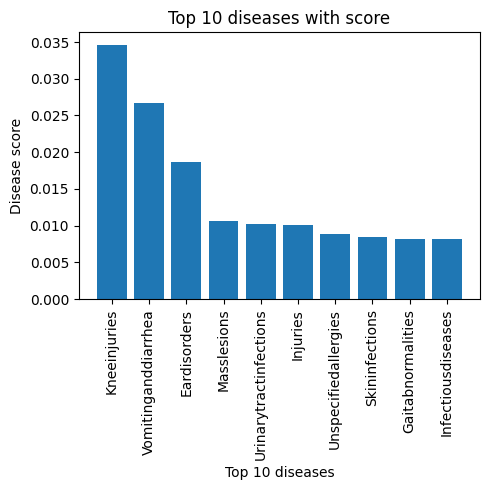

TypeError: plot_top_bottom_features() missing 1 required positional argument: 'feature_names'

In [29]:
#sample = x_test.iloc[x_test["PetId"] == "can416353kirby"]

# x_test.iloc[:, 0].unique().tolist()

# lst = [x for x in x_test.columns if x.startswith('BreedName')]
# lst.insert(0, "No Selection")
# import streamlit as st
#
# st.selectbox("Select pet id", lst)
pet_rows = x_test.iloc[15]
pet_rows

# sample = pet_rows[len(pet_rows) - 1]
get_explanation_and_plots(pet_rows)
#type(pet_rows.iloc[2:])
#print(pet_rows.iloc[2:])

In [21]:
# Get the instance for explanation
instance = x_test.iloc[2].values[2:]
#keep lime model stable
np.random.seed(1234)
# Generate explanation
explanation = explainer.explain_instance(instance, my_classifier_run, num_features=181, top_labels=2)
label=explanation.available_labels()
# Get explanations for class 46
class_explanation = explanation.as_list(label=label[1])

# Separate feature names and weights
feature_names, weights = zip(*class_explanation)

# Initialize an empty list to store the weights
ordered_weights = []
original_feature_names=x_test.columns[2:]
# Loop through each feature in the original feature names
for original_feature in original_feature_names:
    # Check if the original feature is contained within any of the feature names
    if any(original_feature in feature for feature in feature_names):
        # If it is, find the index of the corresponding feature in the feature_names list
        index = next(i for i, feature in enumerate(feature_names) if original_feature in feature)
        # Append the corresponding weight to the ordered_weights list
        ordered_weights.append(weights[index])
    else:
        # If the original feature is not contained within any of the feature names, append 0 to the ordered_weights list
        ordered_weights.append(0)


# Convert weights to a numpy array
weights_array = np.array(ordered_weights)

# Calculate local prediction
local_prediction = np.dot(weights_array, instance) + explanation.intercept[label[1]]

print(local_prediction,'local prediction')

global_prediction = explanation.predict_proba[label[1]]

print(global_prediction,'global_prediction')

print(explanation.intercept,'intercept')


/Users/marvinseiferling/PycharmProjects/LIME/.venv/lib/python3.9/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 -0.5827376733155517 -0.4343839084900612 -0.1766629740154998
 -2.035604882726625 -0.7007214957764812 1.7912203223157928
 -0.3707638418990276 -0.2790028172237049 -1.316725325395983
 -0.8684171524936571 0.6 0.6 0.2 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
 3.819380274748968]
[ 2.99023981e-04  4.97989543e-03 -2.55890742e-03 -4.19165055e-03
  2.42614945e-03  1.00414

In [351]:
len([x for x in x_test.columns if x.startswith('BreedName')])

50

In [53]:
# Using idx explain the x_test instance of that index
idx = 14908

Adrenalinsufficiency                   0.0
Analglanddisorders                     0.0
Anxietyorphobia                        0.0
Arthritis                              0.0
Behavioraldisorders                    0.0
                                    ...   
SuperBreed_ToyOther                    0.0
SuperBreed_WorkingdogsNonsport         0.0
Gender_feminine                        0.0
Gender_masculine                       1.0
Age                               0.854227
Name: 14908, Length: 184, dtype: object


/Users/aanchalchugh/Development/Petplan/LIME/.venv/lib/python3.9/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


{'Sheds_Yes', 'DemeanorCategory_ReservedwithStrangers', 'TrainabilityCategory_Agreeable', 'Country_CAN', 'BreedName_MixedBreedSmallupto22lb', 'AreaType_suburban', 'SuperBreed_MixedSmall', 'BreedType_Mixed', 'Gender_masculine', 'SubBreed_Small'}


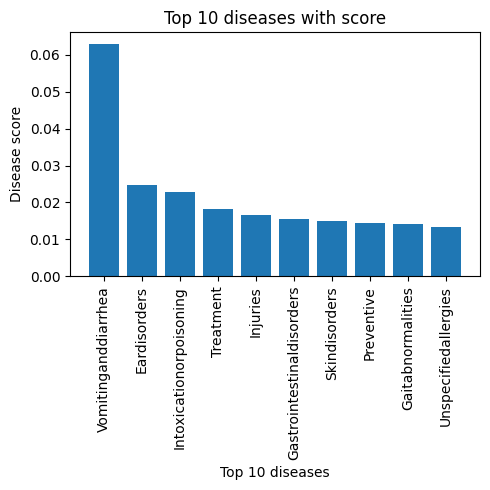

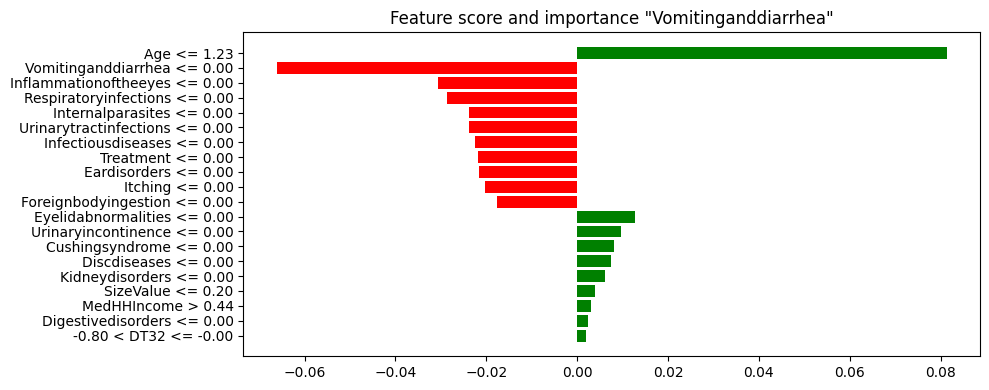

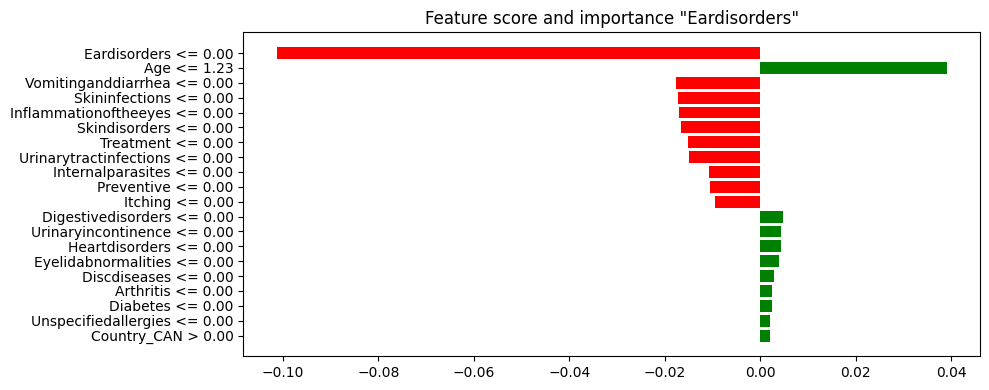

In [54]:
sample = x_test.iloc[idx, 2:]
print(sample)
get_explanation_and_plots(sample)

/Users/aanchalchugh/Development/Petplan/LIME/.venv/lib/python3.9/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


{'SubBreed_Small', 'BreedName_MixedBreedSmallupto22lb', 'TrainabilityCategory_Agreeable', 'DemeanorCategory_ReservedwithStrangers', 'Gender_masculine', 'BreedType_Mixed', 'Sheds_Yes', 'Country_CAN', 'SuperBreed_MixedSmall', 'AreaType_suburban', 'Eardisorders'}


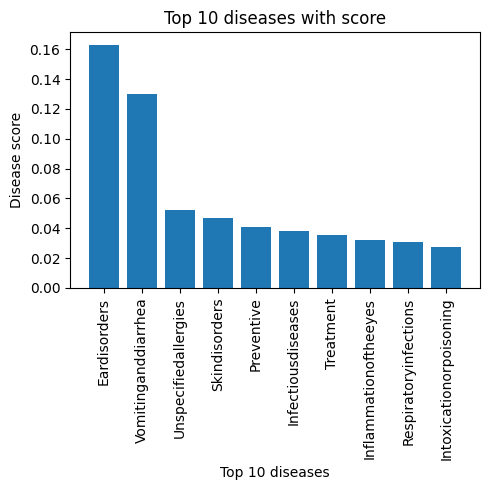

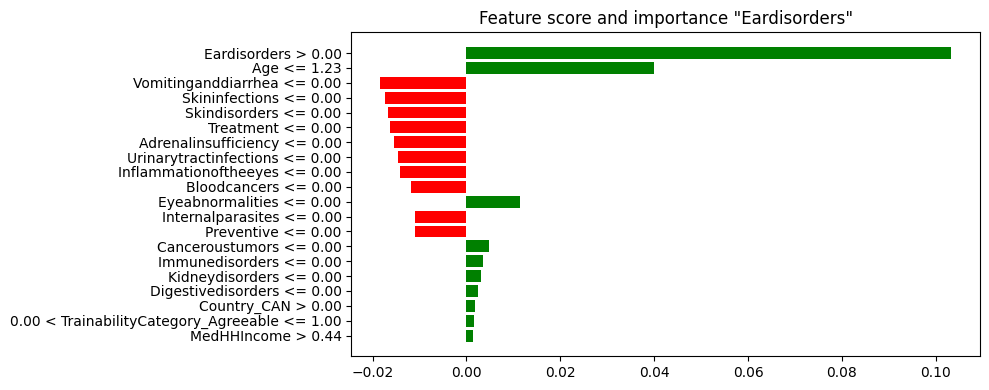

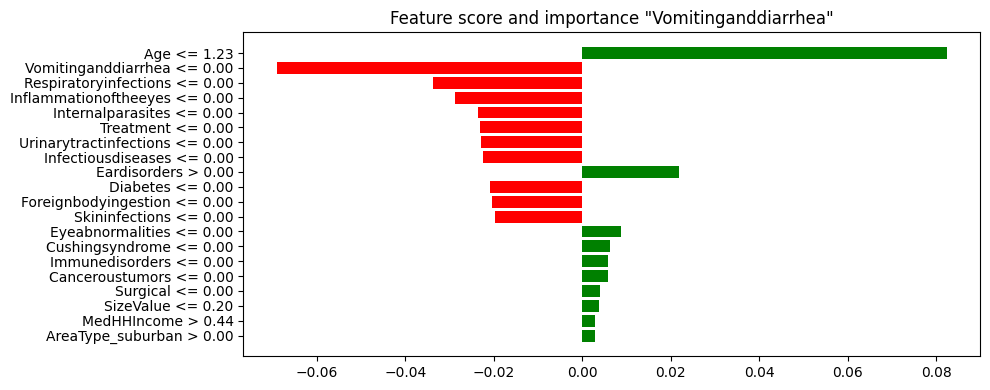

In [46]:
# Change features of dog and run the explanation and plots again

# For example: adding disease Eardisorders to pet health history
sample["Eardisorders"] = 1
get_explanation_and_plots(sample)